# AE98 Electron Beam Shadowgraphy

## Notebook Objectives
The goal of this notebook is to mimic the analysis of Kasim et. al. (2017) to calculate the deflection angle of the electron beam in the AE98 experiment from e- shadowgraphy images.

## 1. Voronoi Tesselation and Lloyd's Algorithm

Voronoi and power diagrams are tesselations of 2D space around a certain number of key points or **sites**. Every point in the space is closest to one of the sites, and so we can divide space into sites and the collection of points those sites. Mathematically, the ith site has a **power cell** defined via

<p align="center">
$|\vec{r}_0 - \vec{r}_{0i}|^2 -w_i \leq |\vec{r}_0 - \vec{r}_{0j}|^2 -w_j$
</p>

for all other sites $j$, where $w_i, w_j$ are the weights of each cell.

In [1]:
import numpy as np
import random
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# set plotting style
%matplotlib inline
plt.style.reload_library()
plt.style.use('ucla_presentations')

# define a handy function for wiping the ticks and labeles off of plot axes
def no_ticks(ax=None):
    if ax is None:
        ax = plt.gca()
    return ax.tick_params(left=False,
                          bottom=False,
                          labelleft=False,
                          labelbottom=False)
# and another for setting the axis limits to stay where they are when plotting multiple things
def freeze_ax(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())
    return


Python packages like scipy have built in functions for Voronoi diagrams, but these do not allow us to use additive weights, which we'll need for the analysis later on. Best to write our own methods for calculating power diagrams so we can tweak and optimize from there.

### A Straightforward First Pass

The most intuitive way to make power diagrams that will be applied to pixellated data is to directly calculate them using numpy arrays (matrices). Then we can take advantage of numpy functions to keep things running quickly. 

This approach works, but it scales with the size of your data and gets very slow when we start using large datasets and many sites. I've kept this all here for posterity and because it demonstrates the mechanics of power diagrams and lloyd relaxation more clearly, but the more mathematically sophisticated approach I'll use later is significantly faster.

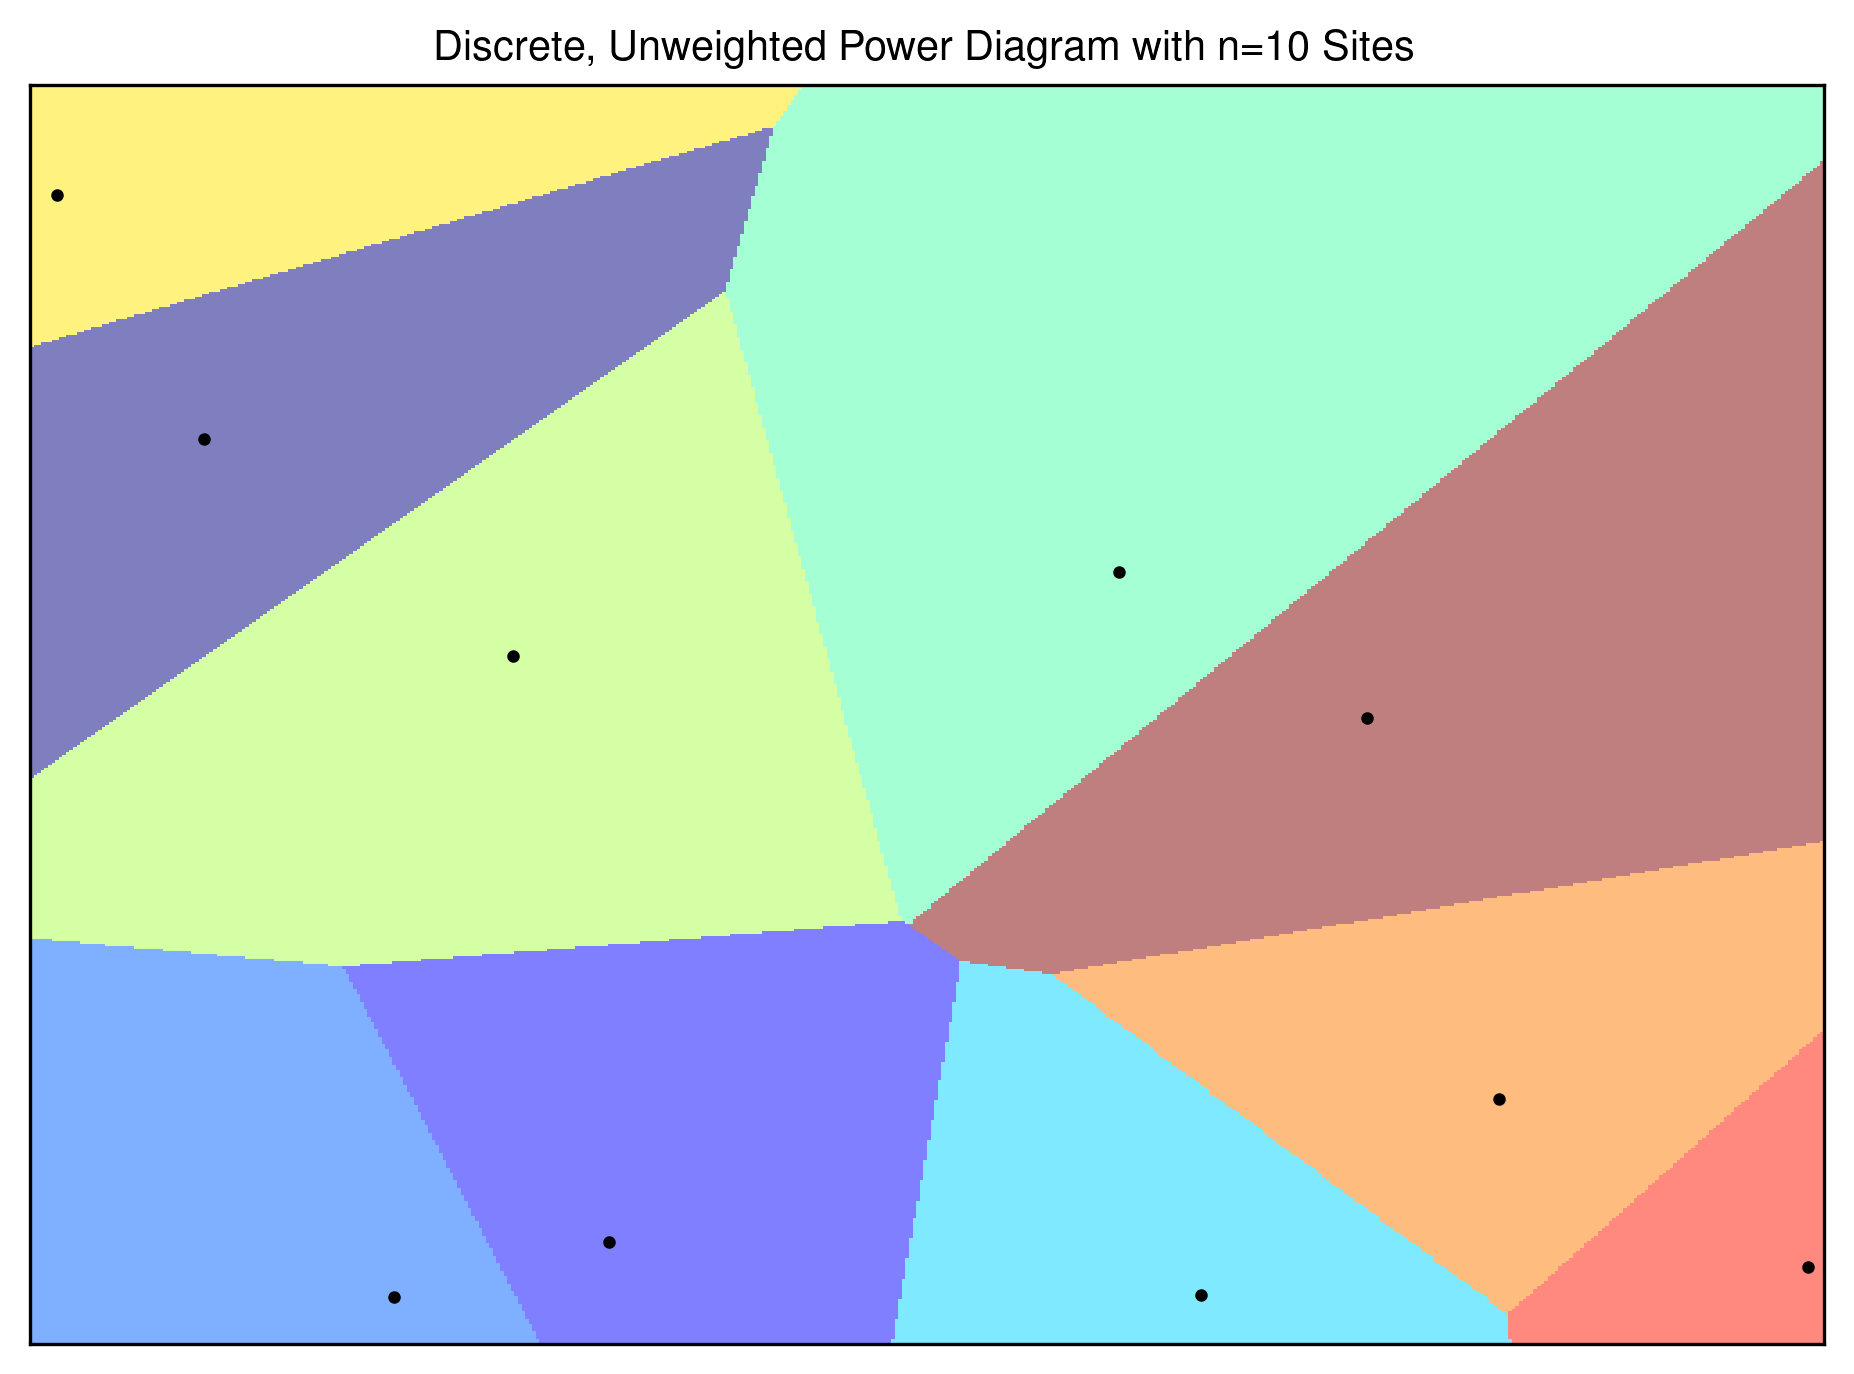

In [2]:
def voronoi_grid(points, shape, weights = 0):
    """
    Generate an array of size (shape, len(points)) that contains the
    indices of each pixel's voronoi cell
    """
    
    # Create arrays of indices with the right shape
    y, x = np.indices(shape)
    y_0, x_0 = points[:,0], points[:,1]
        
    # Calculate the distance from each point to each center
    d2 = (x[:,:,np.newaxis] - x_0[np.newaxis, np.newaxis,:])**2 +\
         (y[:,:,np.newaxis] - y_0[np.newaxis, np.newaxis,:])**2 - weights
    
    #print(f"distances = \n{d2}")

    # Find the index of the nearest center to each point
    nearest_center = np.argmin(d2, axis=2)
    
    #print(f"nearest center = \n{nearest_center}")

    return nearest_center

n=10
h, w = 500, 500
random_y, random_x = np.random.randint(h, size=n), np.random.randint(w, size=n)
points = np.array([random_y, random_x]).T

Y, X = np.indices((h,w))

grid = voronoi_grid(points, (h, w) )

fig, ax = plt.subplots()

ax.pcolormesh(X,Y, grid, cmap='jet', alpha=.5)
ax.plot(random_x, random_y,'ok')
no_ticks(ax)
ax.set_title(f"Discrete, Unweighted Power Diagram with n={n} Sites")
plt.show()


### Lloyd's Algorithm

Lloyd's algorithm is an iterative method for dividing a space into cells of approximately equal area. The method proceeds like this:

1. Distribute a certain number of sites randomly on the plane
2. Construct the Voronoi diagram for those sites
3. Calculate the centroid of each cell
4. Move each site to the centroid of its cell
5. Repeat from step 2 until a stop condition is met.

Here's a quick demonstration of just one iteration of Lloyd's algorithm so you can see the way this works:

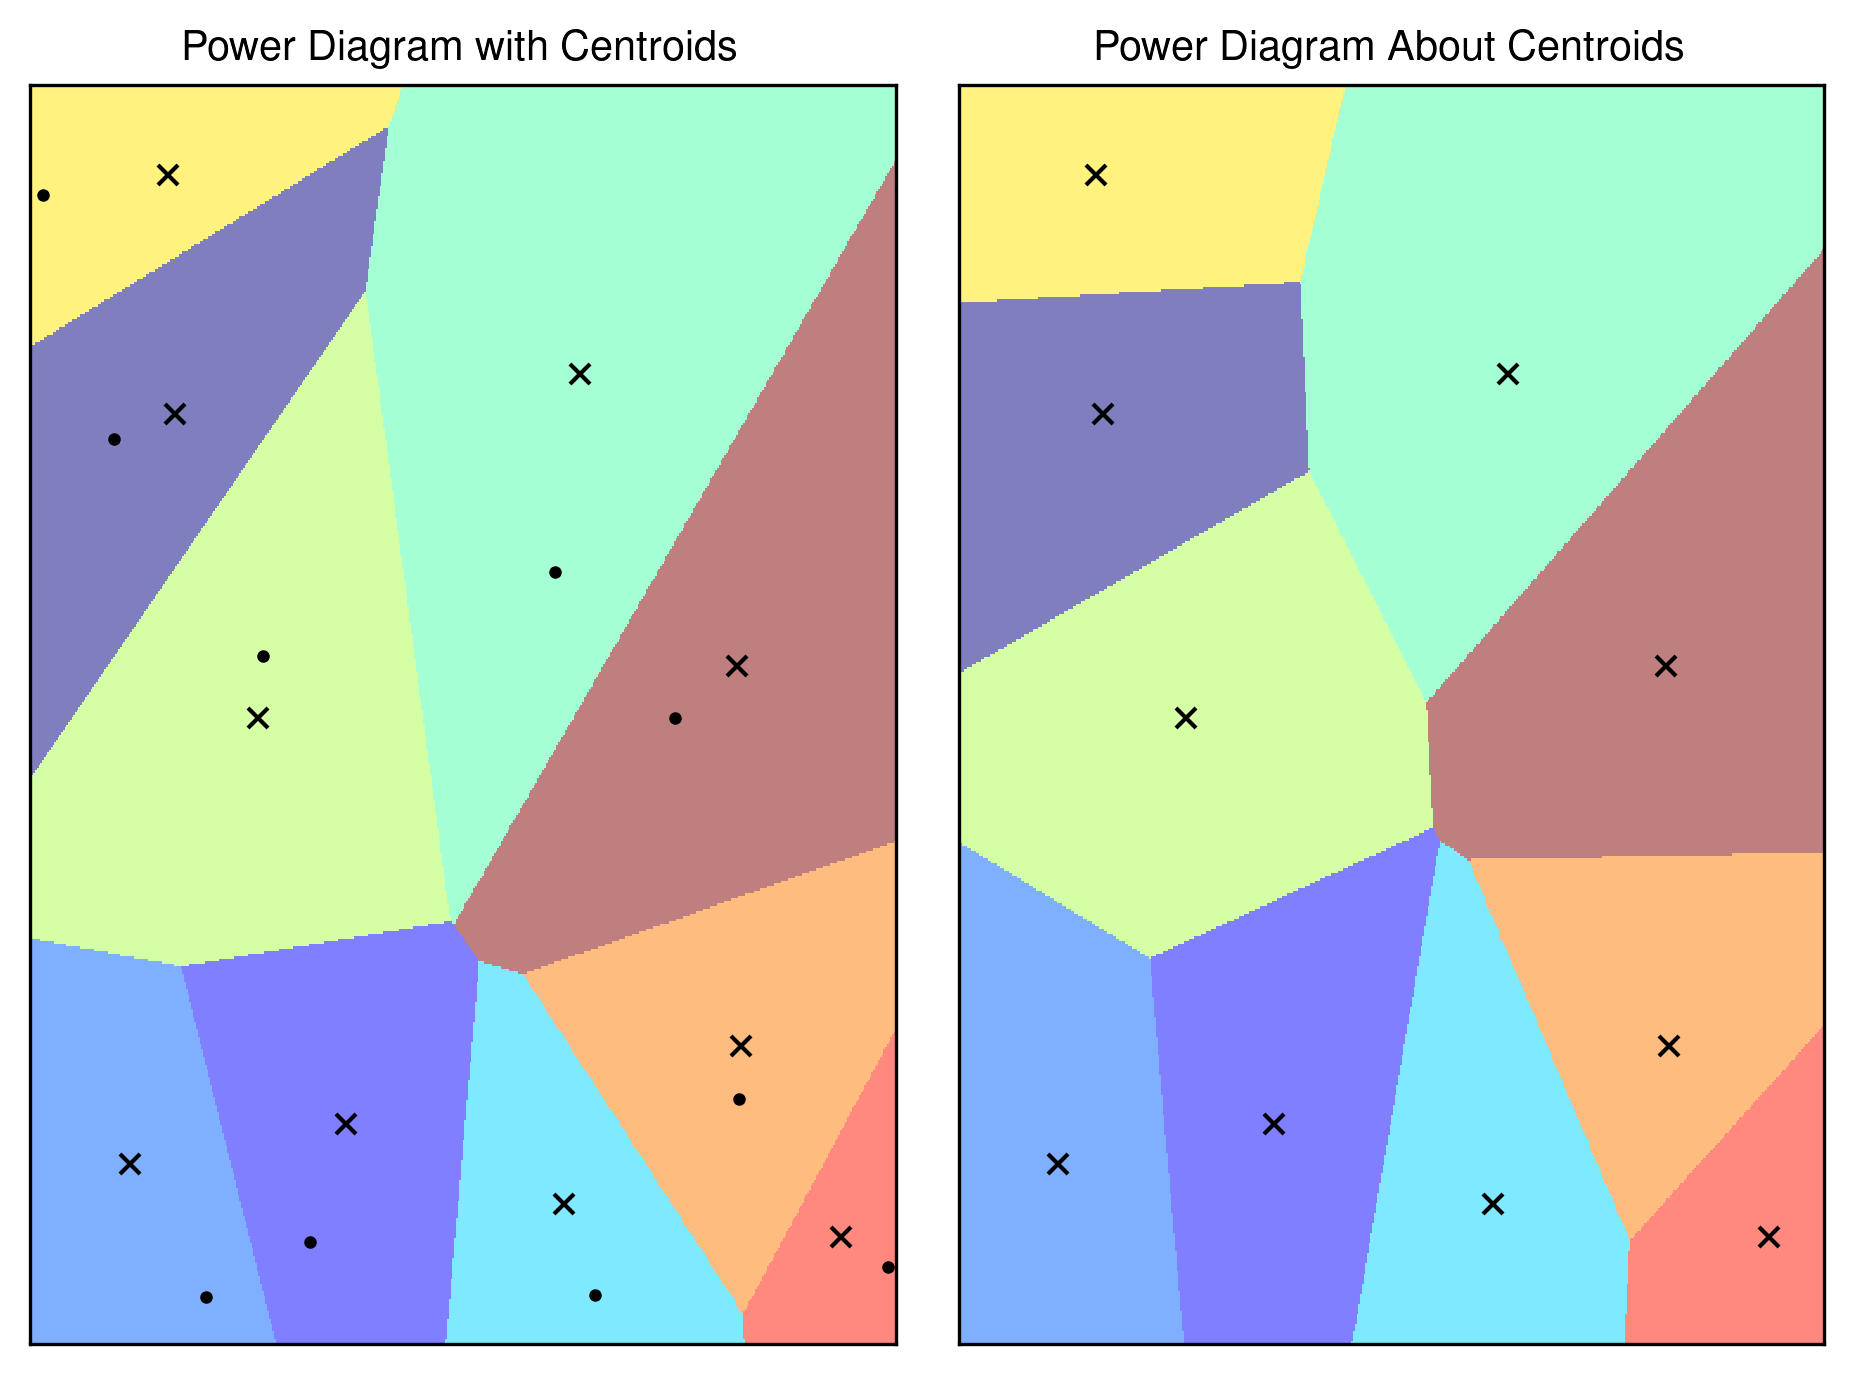

In [3]:
def find_centroids(n, grid):
    """
    Takes a 2D array of voronoi cell indices and calculates the centroid position of each cell
    """
    centroids = np.zeros((n,2), dtype=int)
    
    # Loop over the number of cells

    for i in range(n):
        # First we need to get all the points in a region
        points = np.argwhere(grid == i)
        # Get the number of points in the centroid
        num = points.shape[0]
        #print(f"for i = {i} found {num} points in cell:\n\tx = {points[:,1]}, y = {points[:,0]}")
        centroids[i] = np.rint( np.sum(points, axis=0) / num)
        #print(f"\tFound centroid = ({centroids[i,1]},{centroids[i,0]})")
    
    return centroids


centroids = find_centroids(n, grid)

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.pcolormesh(X,Y, grid, cmap='jet', alpha=.5)
ax1.plot(random_x, random_y,'ok', label='Sites')
ax1.plot(centroids[:,1], centroids[:,0],'kx', markersize=5, label='Centroids')
no_ticks(ax1)
ax1.set_title(f"Power Diagram with Centroids")
#ax1.legend()
    
grid_c = voronoi_grid(centroids, (h, w) )

ax2.pcolormesh(X,Y, grid_c, cmap='jet', alpha=.5)
ax2.plot(centroids[:,1], centroids[:,0],'kx', markersize=5, label='Centroids')
no_ticks(ax2)
ax2.set_title(f"Power Diagram About Centroids")
plt.show()

Centroids no longer changing at i=31 iterations


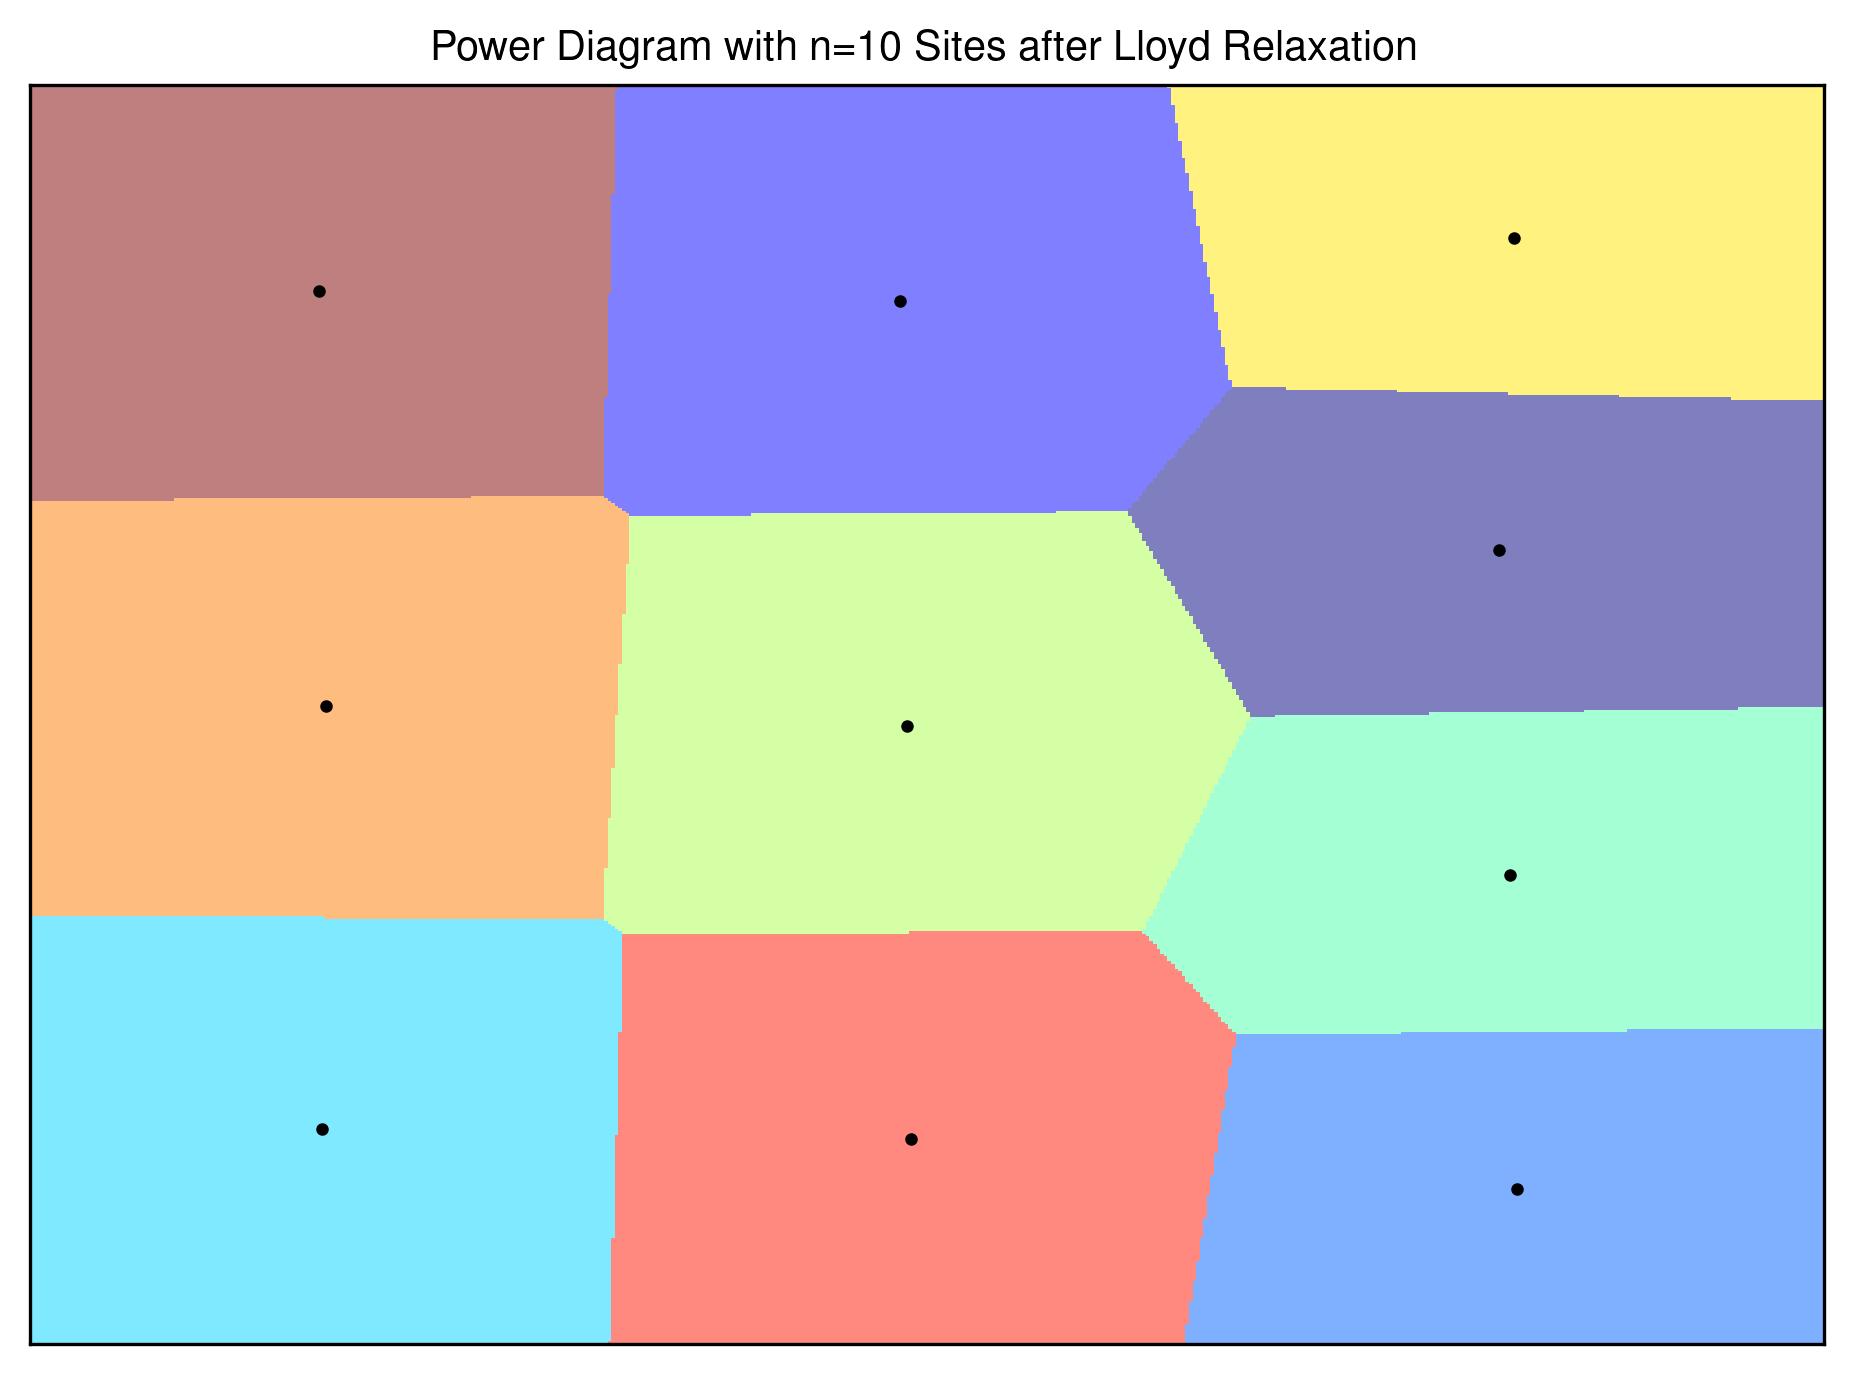

In [4]:
def lloyd_distribute(n, shape, allowance = 0.1, MAXDEPTH = 1000):
    """
    Throw n sites onto a grid with shape, and use lloyd's algorithm to distribute them evenly
    within an allowance of the perfectly split area in each cell
    """
    
    ideal_volume = (shape[0] * shape[1]) / n
    threshold = ideal_volume * allowance
    Y, X = np.indices(shape)

    h, w = shape
    
    # Generate n random sites to start with
    random_y, random_x = np.random.randint(h, size=n), np.random.randint(w, size=n)
    random_points = np.array([random_y, random_x]).T

    grid = voronoi_grid(random_points, shape)
    

    centroids = find_centroids(n, grid)
    for i in range(MAXDEPTH):

        grid = voronoi_grid(centroids, shape)
        old_centroids = np.copy(centroids)
        centroids = find_centroids(n, grid)
        if np.array_equal(centroids,old_centroids):
            print(f"Centroids no longer changing at i={i+1} iterations")
            break
    
    return grid, centroids

lgrid, lpoints = lloyd_distribute(n, (h,w))

lgrid_offset = np.roll(np.roll(lgrid+1, 1, axis=0), 1, axis=1)-(lgrid+1)
y_edges, x_edges = np.nonzero(lgrid_offset)
#print(f"edges = {edges}")

grad_y, grad_x = np.gradient(lgrid)
edges = grad_x**2 + grad_y**2
y_edges, x_edges = np.nonzero(edges)
fig, ax = plt.subplots()

ax.pcolormesh(X,Y, lgrid, cmap='jet', alpha=.5)
#ax.pcolormesh(X,Y, edges, cmap='jet', alpha=1)
#ax.plot(x_edges, y_edges, 'k.', alpha=1)
ax.plot(lpoints[:,1], lpoints[:,0],'ok')
no_ticks(ax)
ax.set_title(f"Power Diagram with n={n} Sites after Lloyd Relaxation")
plt.show()



### Deeper Down the Geometry Hole

Scipy doesn't have a built-in way to calculate weighted Voronoi diagrams, so we can't *easily* take advantage of the more sophisticated algorithms written in C++ for this analysis. However, a fun property of Voronoi diagrams can help us out here. 

**A 2D Voronoi diagram is equivalent to the intersection of half-planes given by the projection of each site onto a 3D paraboloid.**

We can manipulate this paraboloid to give the weighting we want while still taking advantage of scipy's speedy C++ integrations using convex hull algorithms.

#### Delaunay Triangulation

The **dual** of a Voronoi diagram is the **Delaunay Triangulation**, shown in green here:

<p style="text-align:center;"><img src="voronoi_delaunay.png" alt="voronoi and delaulay diagrams" width="300"></p>

The Delaunay triangulation is the projection of the convex hull of the sites when lifted onto a hyperboloid, so if we use a weighted hyperbola equation to lift the sites from 2D to 3D and calculate the convex hull, we then have the weighted Delaunay triangulation on the 2D plane. Once we have these triangles, we can get the Voronoi or Power diagram from there.

This diagram from Hang Si's lecture notes demonstrates this projection onto the hyperbola:

<p style="text-align:center;"><img src="delaunay_projection.png" alt="delaulay diagram from 3D projection" width="500"></p>

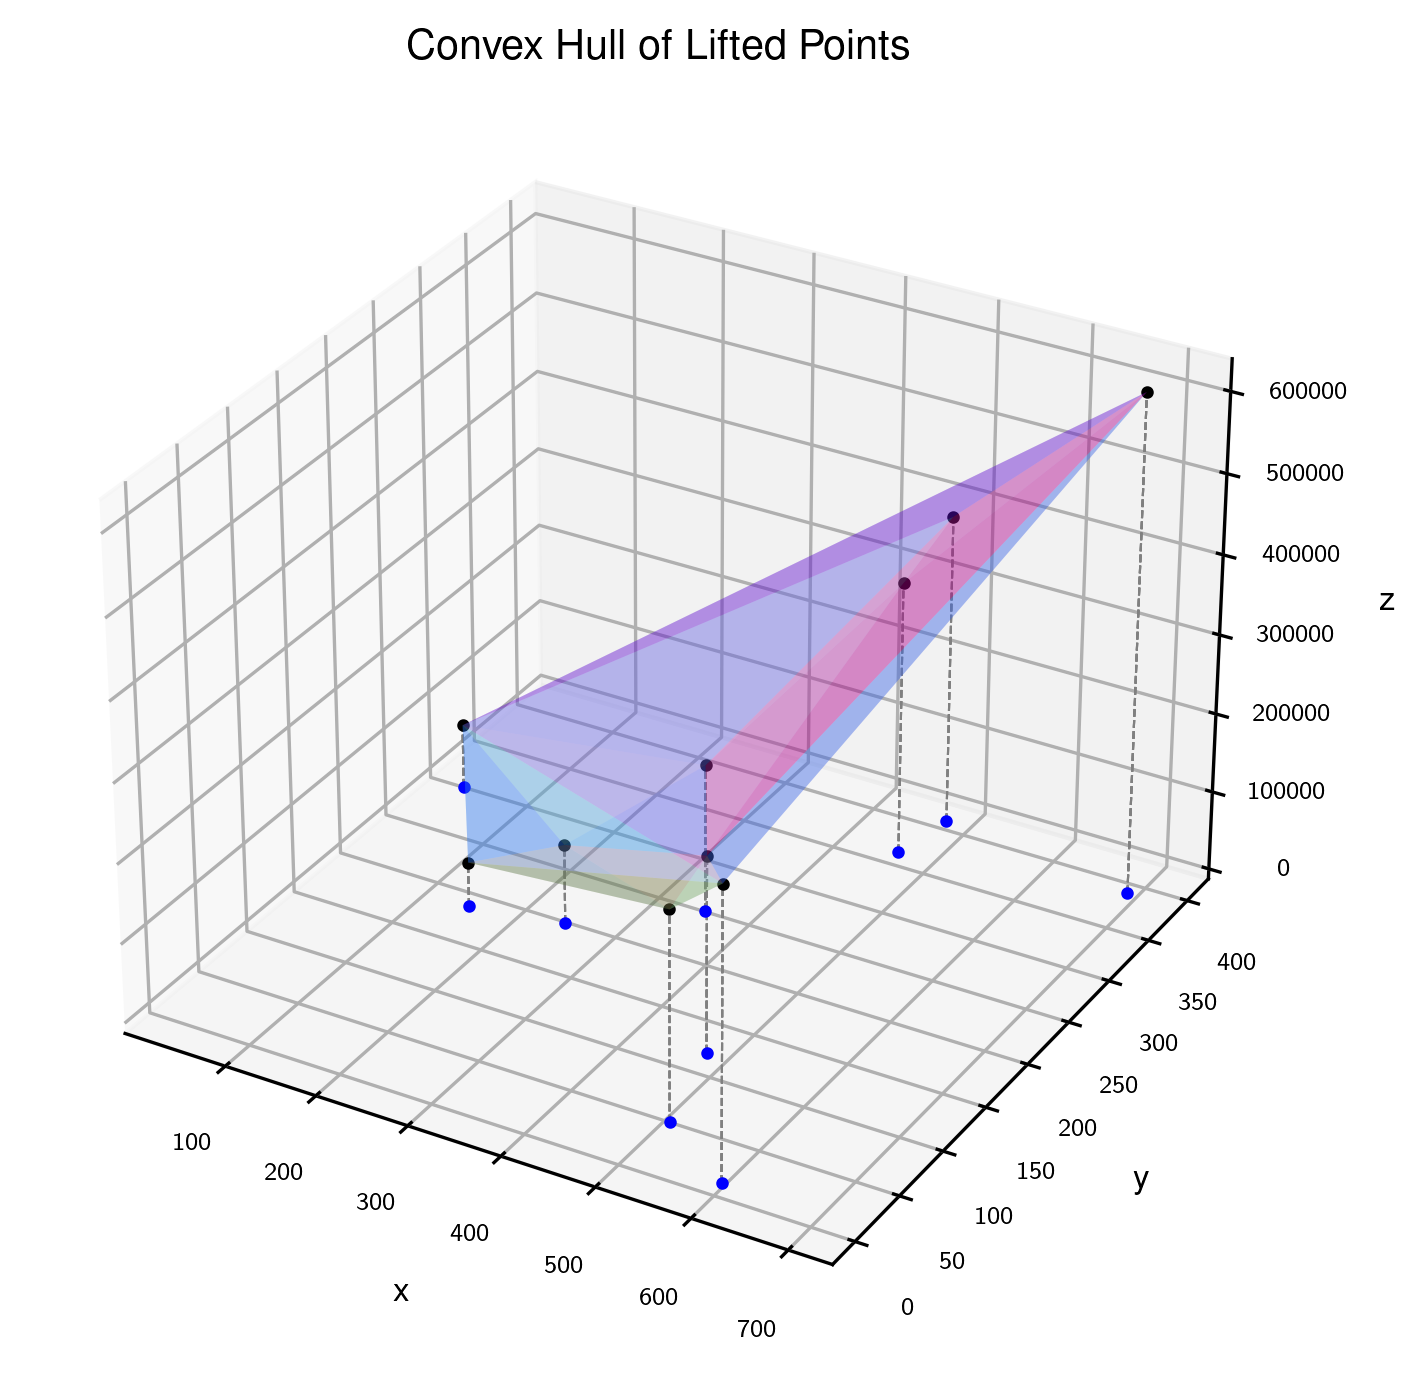

In [5]:
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib as mpl


# First we need to lift  our 2D points onto a weighted hyperbola
def lift_points(points, weights):
    """
    Lift 2D points onto 3D paraboloid for calculating weighted 
    Delaunay triangulations and Voronoi diagrams
    
    Arguments:
        points: 2D numpy array of point coordinates with shape (N, 2)
        weights: 1D numpy array of length N holding each points corresponding weight
        
    Returns:
        3D numpy array of coordinates with shape (N, 3) where the third column is 
        the z projection
    """
    z = np.sum(points * points, axis=1) - weights
    return np.hstack((points, z[np.newaxis,:].T))
    
# Demonstrating the data structure real quick
n=10
h, w = 500, 700
random_y, random_x = np.random.randint(h, size=n), np.random.randint(w, size=n)
points_xy = np.fliplr(np.array([random_y, random_x]).T)
#print(f"2D Points = \n{points_xy}")
weights = np.array([1,1,5,1,1,10,1,3,8,1])*500
#weights = np.zeros(n)
points_xyz = lift_points(points_xy, weights)
#print(f"Projection to 3D = \n{points_xyz}")

# Plot the 3D convex hull
fig = plt.figure()
ax = plt.axes(projection='3d')

hull = ConvexHull(points_xyz)

colors = mpl.cm.get_cmap(name='rainbow')(np.linspace(0,1,len(hull.simplices)))
for i, s in enumerate(hull.simplices):
    for j in s:
        x, y = [points_xyz[j,0],points_xyz[j,0]],[points_xyz[j,1],points_xyz[j,1]]
        ax.plot(x, y, [0,points_xyz[j, 2]], '--', color='grey', lw=0.5)
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot_trisurf(points_xyz[s, 0], points_xyz[s, 1], points_xyz[s, 2], color=colors[i], alpha=.25)

ax.plot(points_xyz[:, 0], points_xyz[:, 1], points_xyz[:, 2], 'ko')
ax.plot(points_xyz[:, 0], points_xyz[:, 1], 0, 'bo')
    
# Make axis labels
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
ax.set_title('Convex Hull of Lifted Points')
plt.show()

The convex hull objects returned by scipy have the property <code>equations</code>, which is an array containing the normal vector $V$ and offset $b$ of each face of the hull, such that for any point $\vec{x}$ inside the convex hull,  $\vec{V}\cdot \vec{x} + b < 0$.

This means that any *lower-facing* faces of the hull will have normal vectors with negative z-components.

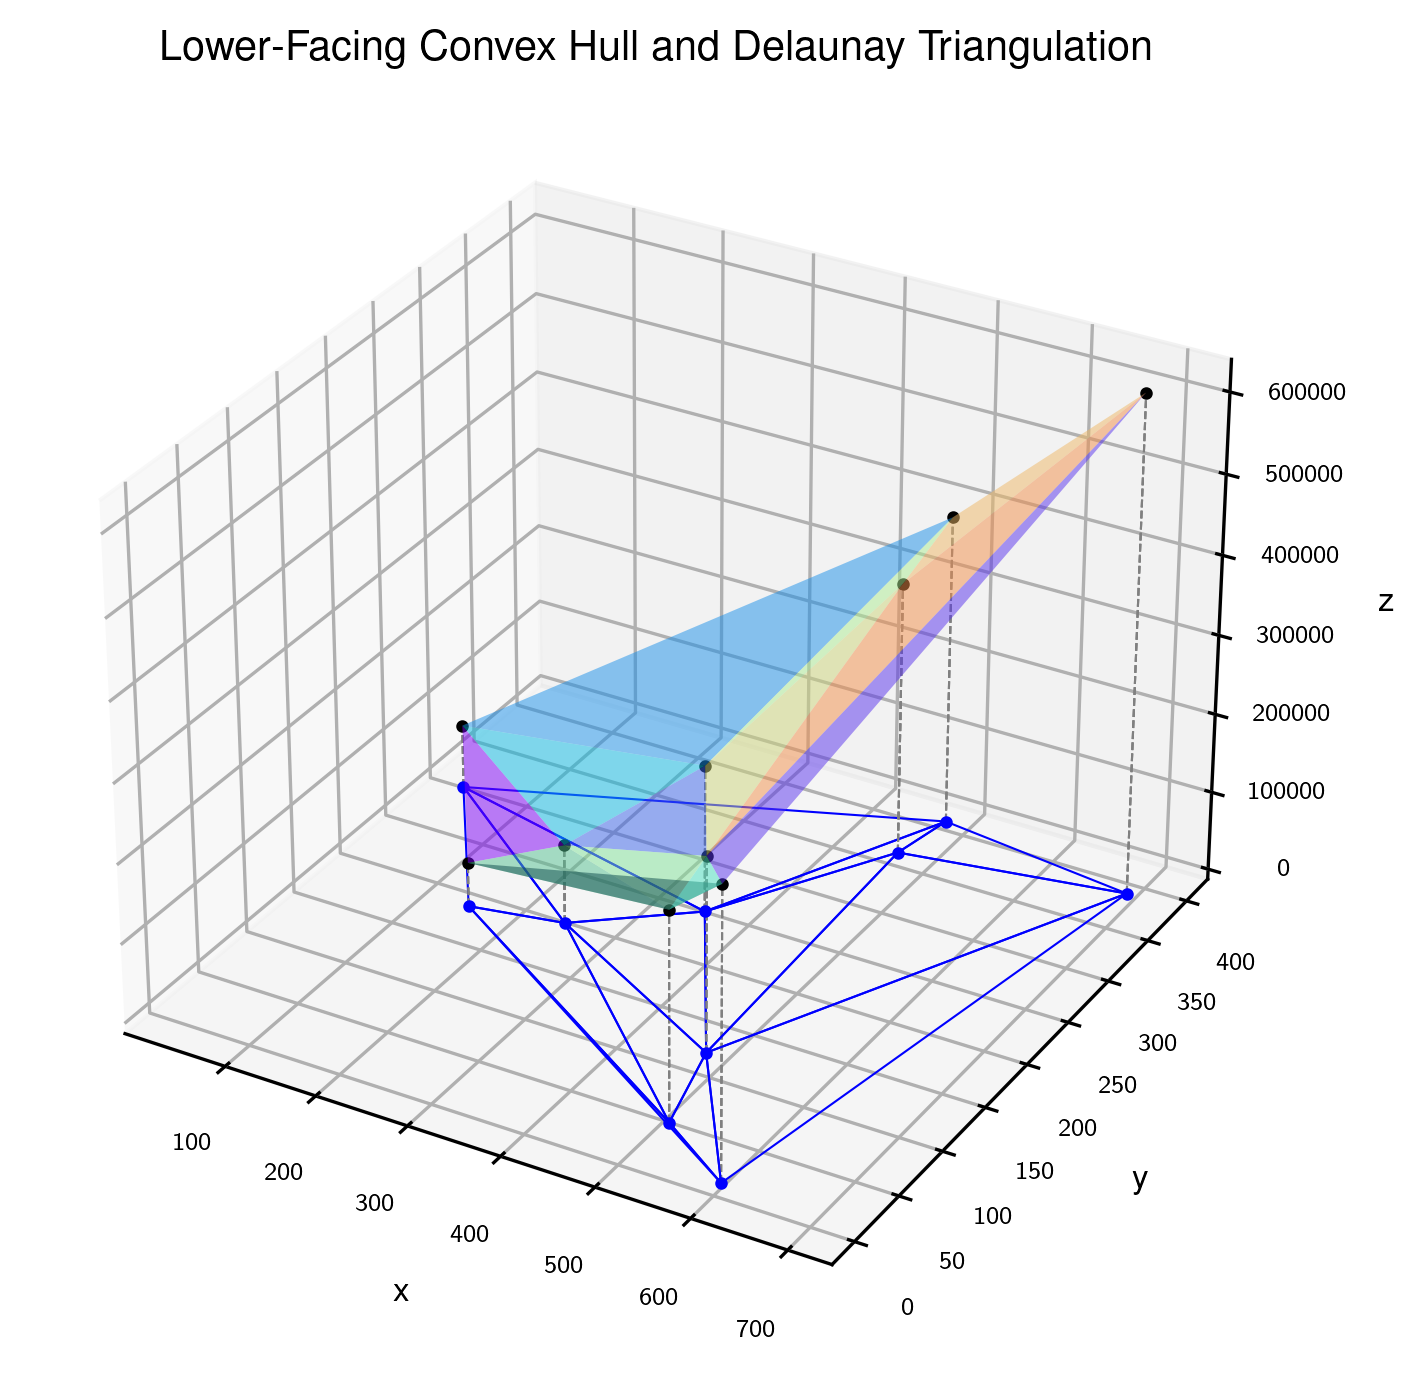

In [6]:
# Now we need to determine which faces of the convex hull are pointing down
def get_lower_facing(hull):
        return np.where(hull.equations[:,2] < 0)[0]
    
#print(f"Normal vectors of faces, (Vx, Vy, Vz, b): \n{hull.equations}")

lowers = get_lower_facing(hull)
# Plot the 3D convex hull
fig = plt.figure()
ax = plt.axes(projection='3d')

for i, s in enumerate(hull.simplices[lowers]):
    for j in s:
        x, y = [points_xyz[j,0],points_xyz[j,0]],[points_xyz[j,1],points_xyz[j,1]]
        ax.plot(x, y, [0,points_xyz[j, 2]], '--', color='grey', lw=0.5)
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot_trisurf(points_xyz[s, 0], points_xyz[s, 1], points_xyz[s, 2], color=colors[i], alpha=.5)
    
    # Projecting these back to z=0 gives the Delaunay Triangulation
    ax.plot(points_xyz[s, 0], points_xyz[s, 1], 0, 'b-', lw=0.5)

ax.plot(points_xyz[:, 0], points_xyz[:, 1], points_xyz[:, 2], 'ko')
ax.plot(points_xyz[:, 0], points_xyz[:, 1], 0, 'bo')
    
# Make axis labels
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
ax.set_title('Lower-Facing Convex Hull and Delaunay Triangulation')
plt.show()

#### Calculating the Dual Graph

Now we have a weighted Delaunay triangulation, and we need to find the dual of this plot to get the weighted Voronoi diagram.

The vertices of each Voronoi cell are defined by the **weighted circumcenters** of all the triangles surrounding the site.

The coordinates of the unweighted circumcenter are

\begin{align}
U_x &= \frac{1}{D}\big((A_x^2 + A_y^2)(B_y - C_y)+(B_x^2 + B_y^2)(C_y - A_y)+(C_x^2 + C_y^2)(A_y - B_y)\big) \\
U_y &= \frac{1}{D}\big((A_x^2 + A_y^2)(C_x - B_x)+(B_x^2 + B_y^2)(A_x - C_x)+(C_x^2 + C_y^2)(B_x - A_x)\big) \\
D &= 2\big(A_x(B_y - C_y) + B_x(C_y - A_y) + C_x(A_y - B_y)\big)
\end{align}

However to take into account the weights this point is offset by *half the local gradient of the linear function defined by the three weights of the vertices*. In other words if $\boldsymbol{c}_{ijk}^0$ is the unweighted circumcenter, the weighted circumcenter is
\begin{align}
\boldsymbol{c}_{ijk} = \boldsymbol{c}_{ijk}^0 - \frac{1}{2}\big(\nabla w\big)_{ijk}
\end{align}

In reality we've *already calculated* the weighted circumcenters, because we have the normal vectors $\vec{V} = (V_x, V_y, V_z)$ of each face of the 3D convex hull. Projecting these vectors back down to the $z=0$ plane gives the weighted circumcenter for one of our triangles:
\begin{align}
\vec{c} = -\frac{ \vec{V}_\perp}{2 V_z}
\end{align}

We can double check this weighting by returning to the definition of a power diagram: each edge of a cell is defined by the intersection of the circles centered at two neighboring sites, with radii given by $\sqrt{w_i}$.

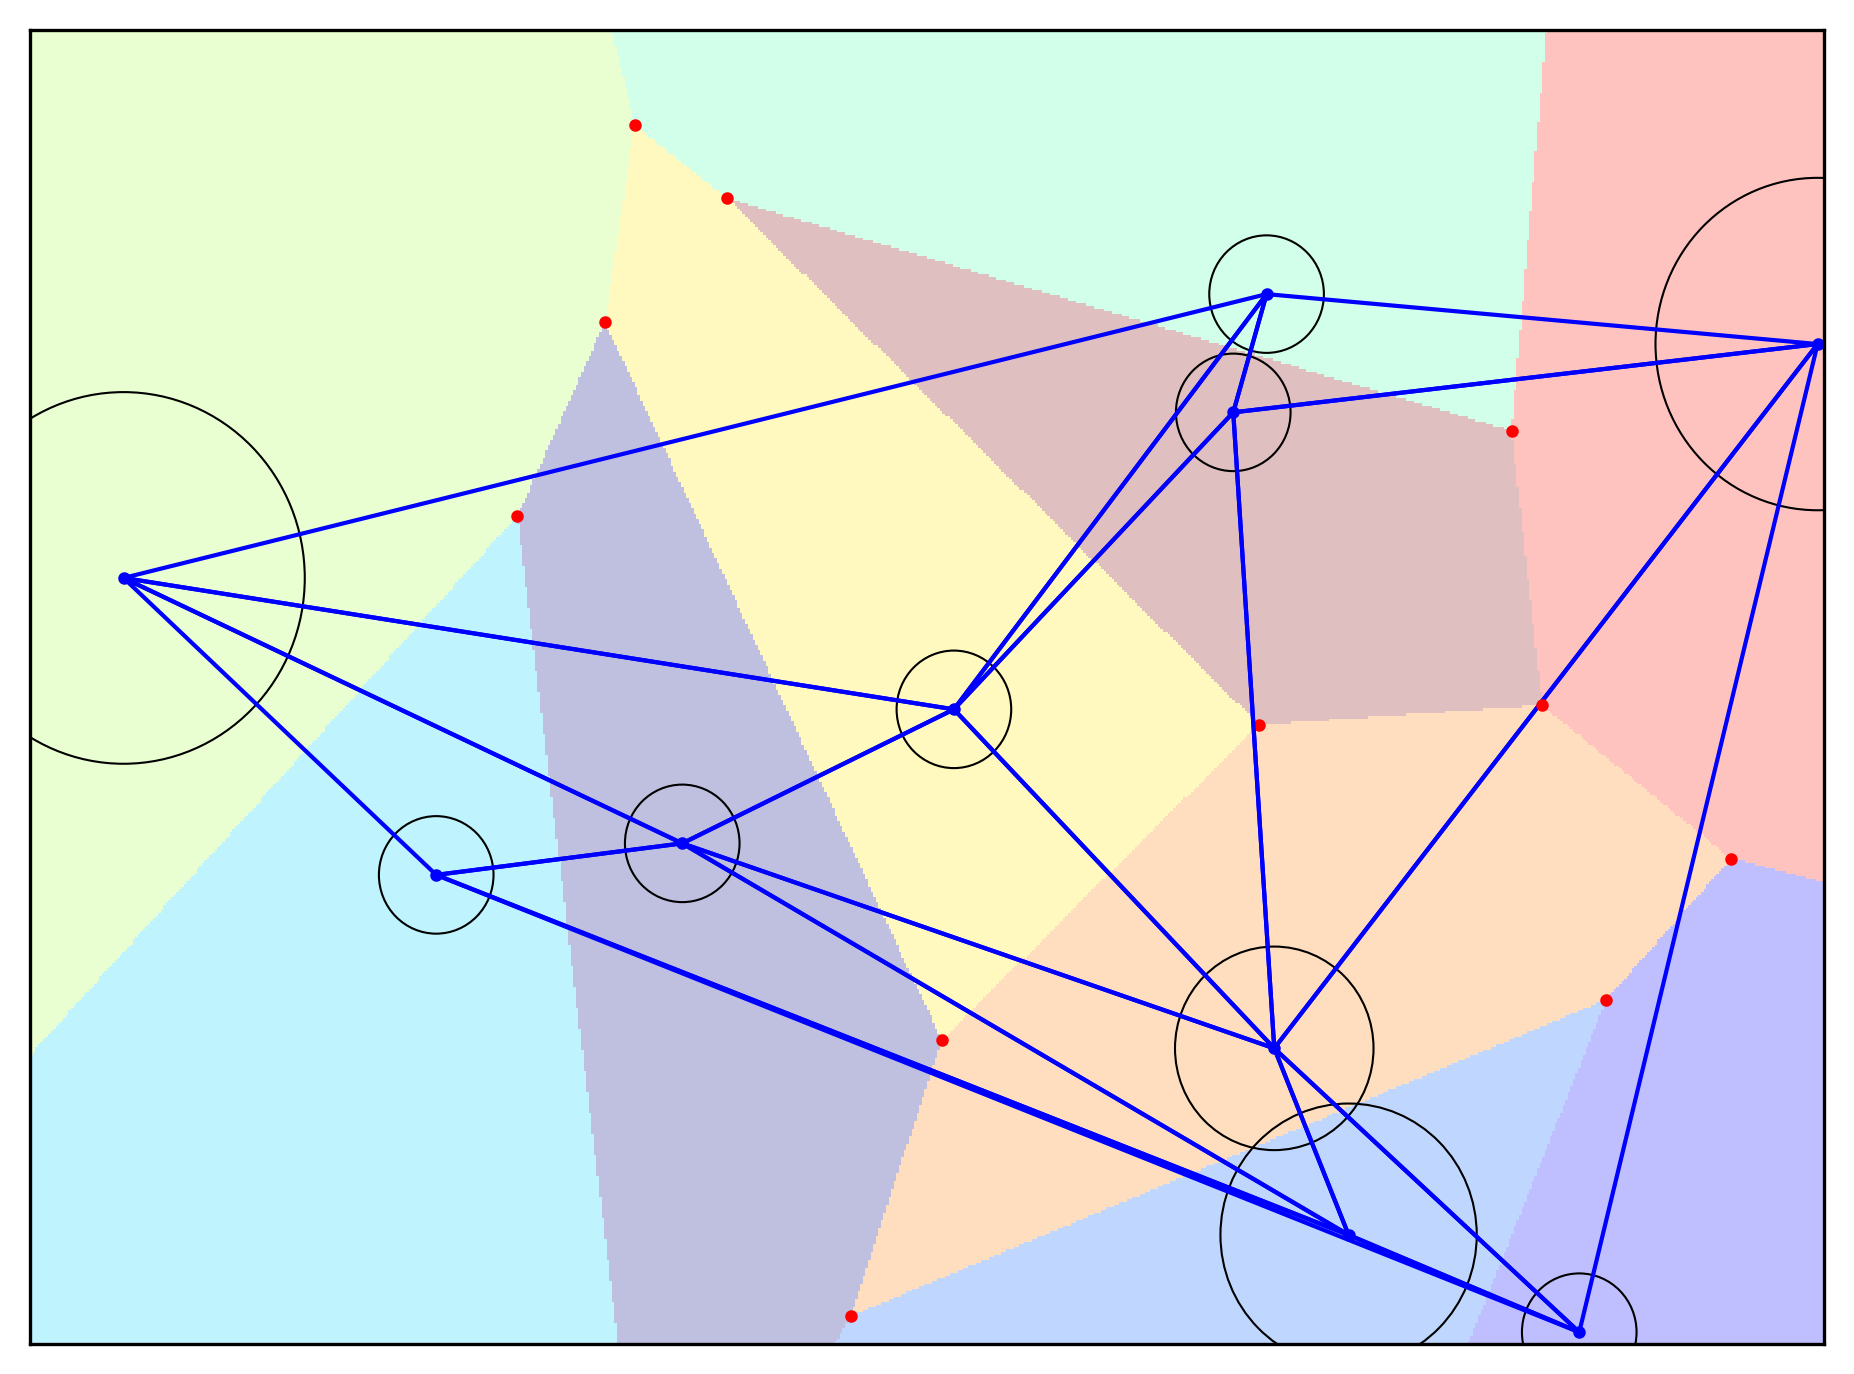

In [7]:
def circumcenter(points):
    """
    Calculates the unweighted circumcenter of the triangle defined by points
    Arguments:
        points: 2D ndarray of triangle vertices with form [[Ax, Ay],[Bx, By],[Cx, Cy]]
    
    Returns:
        circumcenter: [cx, cy] coordinates of the triangle's circumcenter
    """
    
    # Get the permutation needed for Ax(By - Cy), etc
    shifted = np.roll(points, -1, axis=0) - np.roll(points, 1, axis=0)
    flipped = np.fliplr(shifted)
    flipped[:,1] *= -1
    
    # Calculate the magnitude squared of each vertex vector
    mag = np.sum(points**2, axis=1)
    
    # Calculate the circumcenter
    D = 2 * np.sum(points[:,0] * flipped[:,0])
    return (mag @ flipped) / D


# Plot the circumcenter of each Delaunay triangle, including Voronoi cells from the old method to
# check our work

fig, ax = plt.subplots()
grid = voronoi_grid(np.fliplr(points_xy), (h, w), weights)
Y, X = np.indices((h, w))
ax.pcolormesh(X,Y, grid, cmap='jet', alpha=.25)
ax.set_ylim(ax.get_ylim())
ax.set_xlim(ax.get_xlim())

# Grab the normal vectors of each face
eqns = (hull.equations[lowers])

for i, s in enumerate(hull.simplices[lowers]):
    # Show the difference between weighted and unweighted circumcenters
    cc = circumcenter(points_xyz[s, :-1])
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    
    # Projecting these back to z=0 gives the Delaunay Triangulation
    ax.plot(points_xyz[s, 0], points_xyz[s, 1],  'b-')
    
    # Unweighted circumcenters in light red
    #ax.plot(cc[0], cc[1], 'o', c = (1,.5,.5))
    
    # Get the weighted circumcenters from the convex hull
    verts = -0.5 * eqns[i, :2] / eqns[i, 2]
    ax.plot(verts[0], verts[1], 'ro')


# Draw the weights of each site
for point, weight in zip(points_xy, weights):
    ax.add_patch(plt.Circle((point[0], point[1]), np.sqrt(weight), color='black', fill=False, lw=0.5))
ax.plot(points_xyz[:, 0], points_xyz[:, 1], 'bo')
ax.set_aspect('auto')

no_ticks(ax)
plt.show()

#### What about the edges?

Right now we have several Voronoi cells with vertices that are infinite. As you can see in the plot above, this weighted circumcenter calculation does not give us the vertices along the edges of the box. In order to determine those vertices, we can take two different approaches:

1. Mirror the sites over each edge of the bounding box before calculating the convex hull so that there will always be Voronoi edges on the boundaries.
2. Calculate the unit vectors for the infinite edges and project those lines to the edges of the box.

The first approach is the easiest to implement, but it means we have to calculate five times as many sites in every single voronoi diagram. We're going for speed, here, so the second option is the only option.

Instead of mirroring our points to clip to the bounding box, we can be a little more intentional about the way we calculate the edges of the Delaunay triangulation and resulting Voronoi diagram so that these infinite edges are taken into account. 

If we can calculate the direction that these infinite edges are going, we can use the equation of that line to define a vertex at some distance away that is guaranteed to be outside our box. Then we can clip the cells that intersect the box using a well known polygon-clipping method called the Sutherland-Hodgman algorithm.

#### Clipping Infinite Edges

We need to take care of the edges of the Delaunay triangulation in order to have a full set of Voronoi cells in our final tesselation. The convex hull gives us infinite edges between a lower- and upper-facing face on the 3D convex hull. If we don't take care of these infinite edges, we won't be able to get all the vertices of the cells on the outside edges of the diagram. 

<p align="center"><img src="projection_infinite.png" alt="projection of the convex hull to form infinite edges in the Delaunay Triangulation" width="500"></p>

The projection of the upward-facing face gives us an open triangle (not really a triangle, I suppose), so the weighted circumcenter is infinite. We can clip these infinite vertices to the edges of the box we're interested in using some geometry.

Stand by while we rewrite all the methods for getting the edges of the Voronoi diagram from the convex hull:

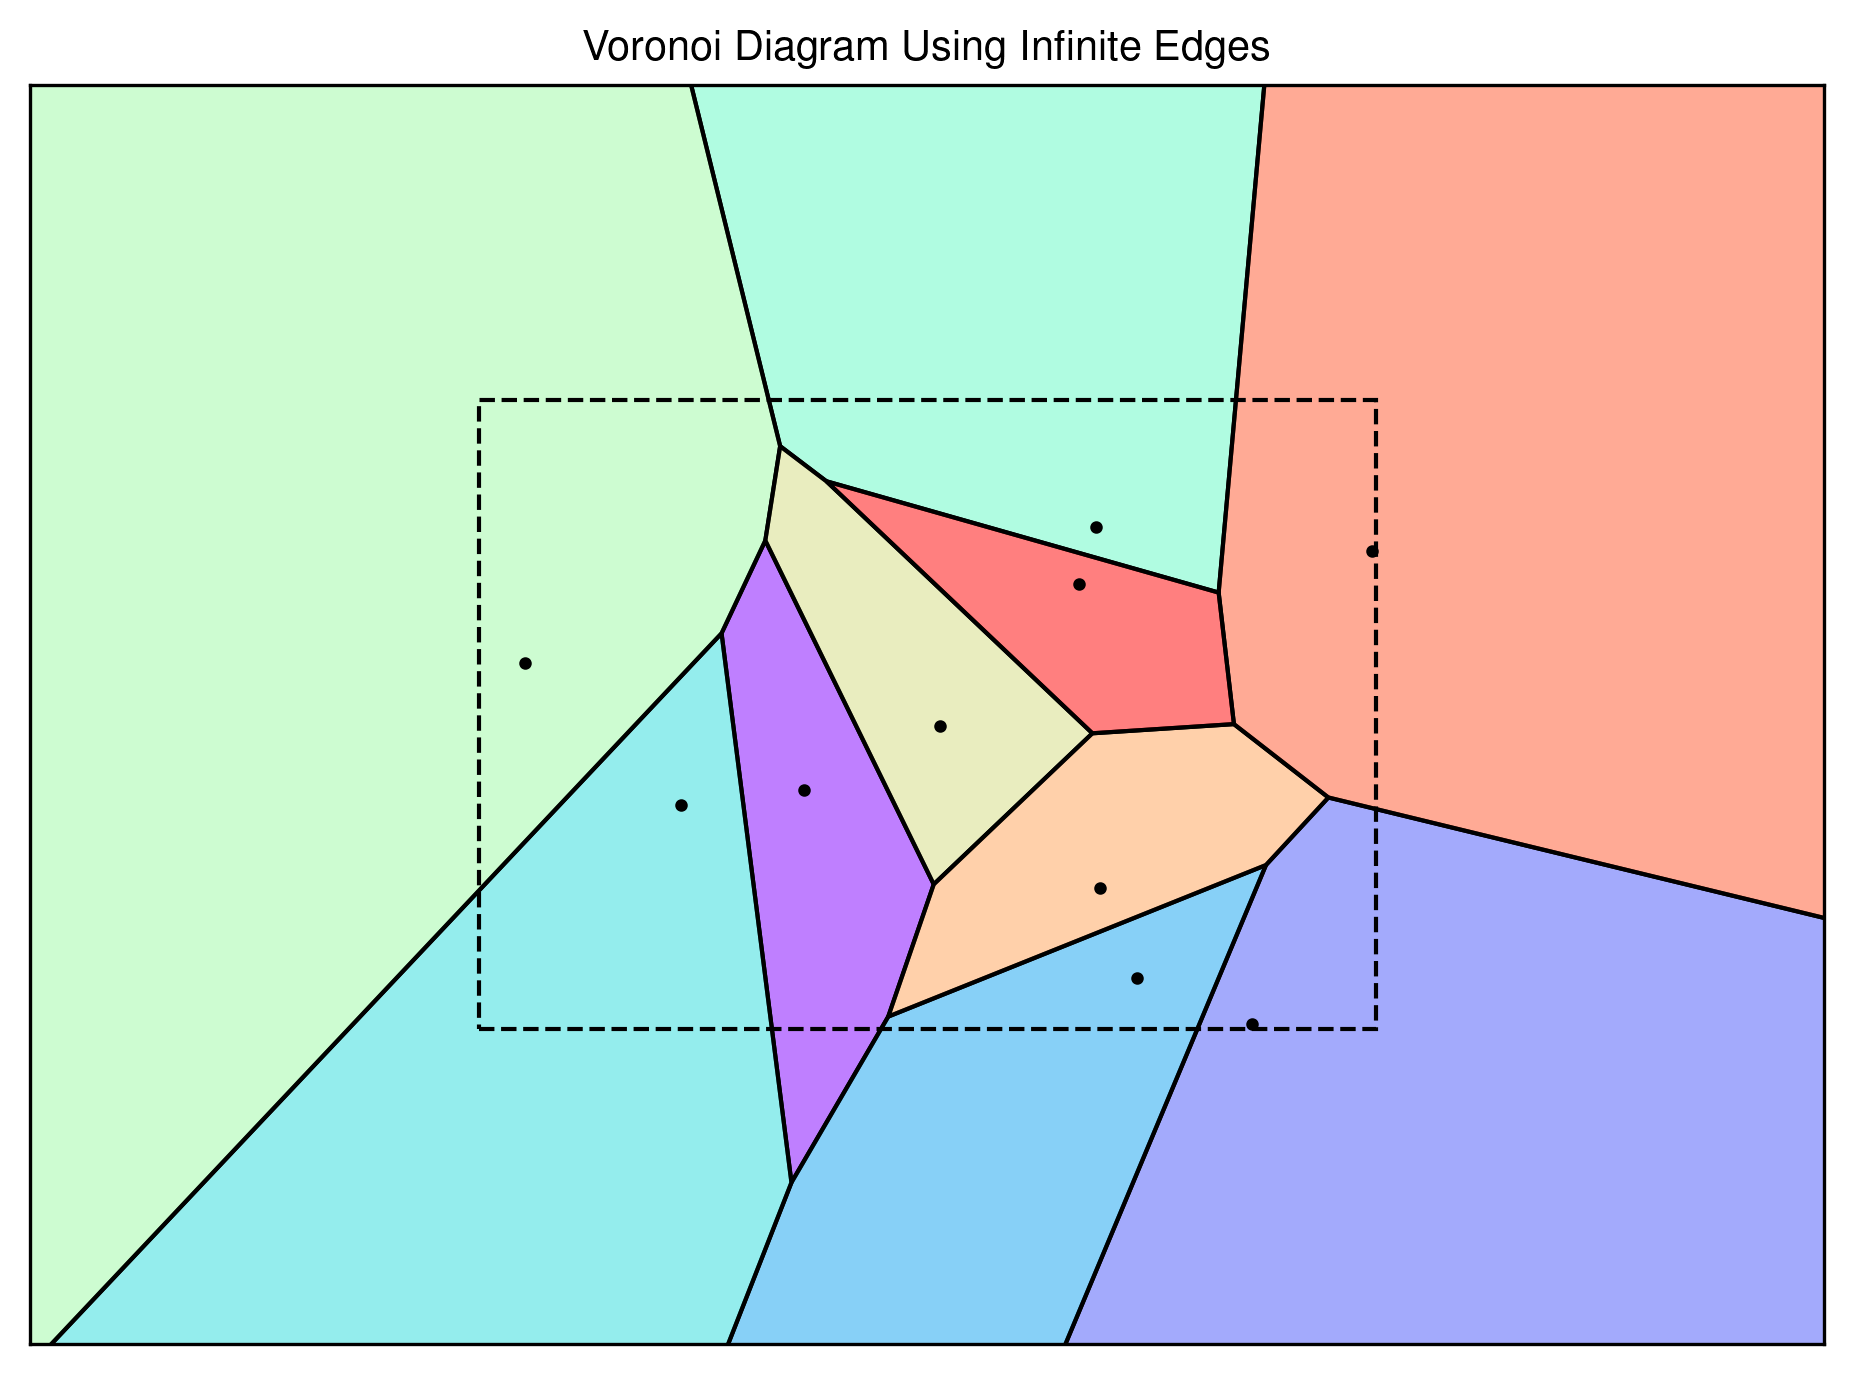

In [8]:
sites = points_xy

def get_delaunay_edges(hull, lowers):
    """ 
    Find all the edges in the Delaunay triangulation by grabbing all the pairs of faces in the convex hull that share an edge.
    If one of the faces in a pair is not downward-facing, the edge is infinite.
    Arguments:
        hull: scipy.ConvexHull object
        lowers: indices of the hull faces that are downward-facing (finite delaunay triangles)
    Returns:
        neighbors: array of pairs of hull face indices that are unique neighbors defining a delaunay edge
        infinite: boolean mask giving all the edges that are infinite
    """
    
    # the neighbors attribute contains the indices of the 3 faces that are the neighbors
    # of the face corresponding to each position in the array
    neighbors = np.zeros((lowers.shape[0], 2 * hull.ndim), dtype = int)
    
    # Each valid face has three edges that start at that faces index
    neighbors[:, 0::2] = lowers[:, None] # set every other element to the face index
    neighbors[:, 1::2] = hull.neighbors[lowers] # set the remaining elements to the neighbors' indices
    
    # Reshape array to be a list of pairs of indices (start and stop indices) defining an edge
    neighbors = np.sort(neighbors.reshape([-1,2]), axis = 1)
    # Remove any duplicate edges
    neighbors = np.unique(neighbors, axis = 0)
    
    # Make a mask of edges that are finite (connect faces that are both downward facing)
    infinite = np.isin(neighbors, lowers).sum(axis=1) != 2
    
    return neighbors, infinite

def get_vertices(hull):
    """
    Calculate the two vertices corresponding to each edge in the convex hull, i.e. the
    dual of the Delaunay triangulation.
    """
    # Get indices for faces of the hull that are downward facing (finite edges)
    lowers = get_lower_facing(hull)
    
    neighbors, infinite = get_delaunay_edges(hull, lowers)
    
    # Suppress divide by zero errors for this bit since there will be some infs
    old_settings = np.seterr(invalid = 'ignore', divide = 'ignore')
    # Calculate all the vertices from the hull equations
    vertices = -0.5 * hull.equations[:,:2] / hull.equations[:,2][:, None]
    
    # Get the vertices corresponding to each edge
    vertices = vertices[neighbors]
    
    # overwrite the infinite vertices to clip to the bounding box
    vertices[infinite] = [get_infinite_vertices(hull, edge, lowers) for edge in neighbors[infinite]]
    
    # Revert to the old error settings
    np.seterr(**old_settings)
        
    return vertices, neighbors

def get_infinite_vertices(hull, edge, lowers):
    """
    Calculate the dual vertices when one of the faces defining the edge is not downward-facing
    """
    # Determine which face defining the edge is the nasty one
    is_lower = np.isin(edge, lowers)
    f1, f2 = edge[is_lower], edge[~is_lower]

    # Check that only one face is bad
    if np.sum(is_lower) != 1:
        print("An edge is only infinite if one of the two faces is nasty.")
        return
    
    # Get the two vertices the faces have in common
    triangle = hull.simplices[f1]
    verts = np.intersect1d(triangle, hull.simplices[f2])
    p1, p2 = hull.points[verts[0]], hull.points[verts[1]] # vertices in form [x y z]
    edge = np.stack((p1[:2],p2[:2]))
    
    # get the one point in the triangle f1 that isn't on the shared edge
    p3 = hull.points[triangle[~np.isin(triangle, verts)]][0, :2]
    
    # the dual vertex of the lower-facing plane is calculated normally
    v1 = (-0.5 * hull.equations[f1, :2] / hull.equations[f1, 2])[0]
    
    # Calculate another point on the line to define the infinite edge
    # Calculate the slope of the line perpendicular to the line connecting p1 and p2
    m = -(p2 - p1)[0] / (p2 - p1)[1]
    dx = w #- v1[0]
    dy = m * dx
    delta = np.array([dx, dy])
   
    if np.dot(delta, np.mean(edge, axis=0) - p3) < 0:
        # if delta is pointing towards p3, flip it around
        delta *= -1
    
    v2 = v1 + delta

    return np.stack((v1, v2))

def get_cells(hull):
    """
    Get the indices of the edges corresponding to each site
    """
    sites = hull.points
    vertices, neighbors = get_vertices(hull)
    triangles = hull.simplices[neighbors] # get the indices of the vertices for each face
    # Find the common edge between each pair of neighboring triangles
    edge_sites = np.array([np.intersect1d(pair[0], pair[1]) for pair in triangles])
    
    # Get all the edges containing each vertex
    cells = []
    cell_vertices = []
    for i, site in enumerate(sites):
        # get the indices of the edges containing each site
        edge_idx = np.argwhere(edge_sites == i)[:,0]
        cells.append(edge_idx)
        verts = vertices[edge_idx]
        # remove duplicate vertices
        verts = np.unique(np.reshape(verts, (-1,2)), axis = 0)
        
        # Sort the vertices in clockwise order
        verts = np.array(sorted(verts,
                                key = lambda v: np.arctan2((v[0] - site[0]), (v[1] - site[1]))))

        cell_vertices.append(verts)
    
    return cell_vertices

# Define the bounding box
box = np.array([[0,0],[0,h],[w,h],[w, 0]], dtype=float)

fig, ax = plt.subplots()

# Get all the cell vertices from the Convex Hull
cells = get_cells(hull)

colors = mpl.cm.get_cmap(name='rainbow')(np.linspace(0,1,n))
for i, cell in enumerate(cells):
    if cell.size ==0:
        continue
    # Plot the cell before clipping to the boundaries
    ax.fill(cell[:,0], cell[:,1],
            facecolor=mpl.colors.to_rgba(colors[i],0.5), edgecolor='black')

# Plot the original sites
ax.plot(sites[:,0], sites[:,1], 'ko')

# Show the bounding box
ax.add_patch(plt.Rectangle((0,0),w,h, color='k', ls='--', fill=False))

#ax.set_xlim(-.5*w,1.5*w)
#ax.set_ylim(-.5*h,1.5*h)
ax.set_xlim(-.5*w,1.5*w)
ax.set_ylim(-.5*h,1.5*h)

no_ticks(ax)
ax.set_title(f"Voronoi Diagram Using Infinite Edges")
#plt.savefig('clipping_infinite_edges.png')

plt.show()

### Sutherland-Hodgman Algorithm

The Sutherland-Hodgman algorithm is a well-known polygon clipping method that only requires ther *vertices* of each polygon rather than the *edges*, so it's perfect for the data structure we've been using so far.

This algorithm takes the vertices in clockwise order and looks at one edge (two consecutive vertices) at a time. For each edge there are four possibilities:

1. **Both vertices are inside:** Add the second vertex to the output list
2. **First vertex is outside, second is inside:** Add the second vertex to the output list, as well as the intersection of the boundary and the edge.
3. **First vertex is inside, second is outside:** Add the intersection of the boundary and the edge to the output list
4. **Both vertices are outside:** Move on

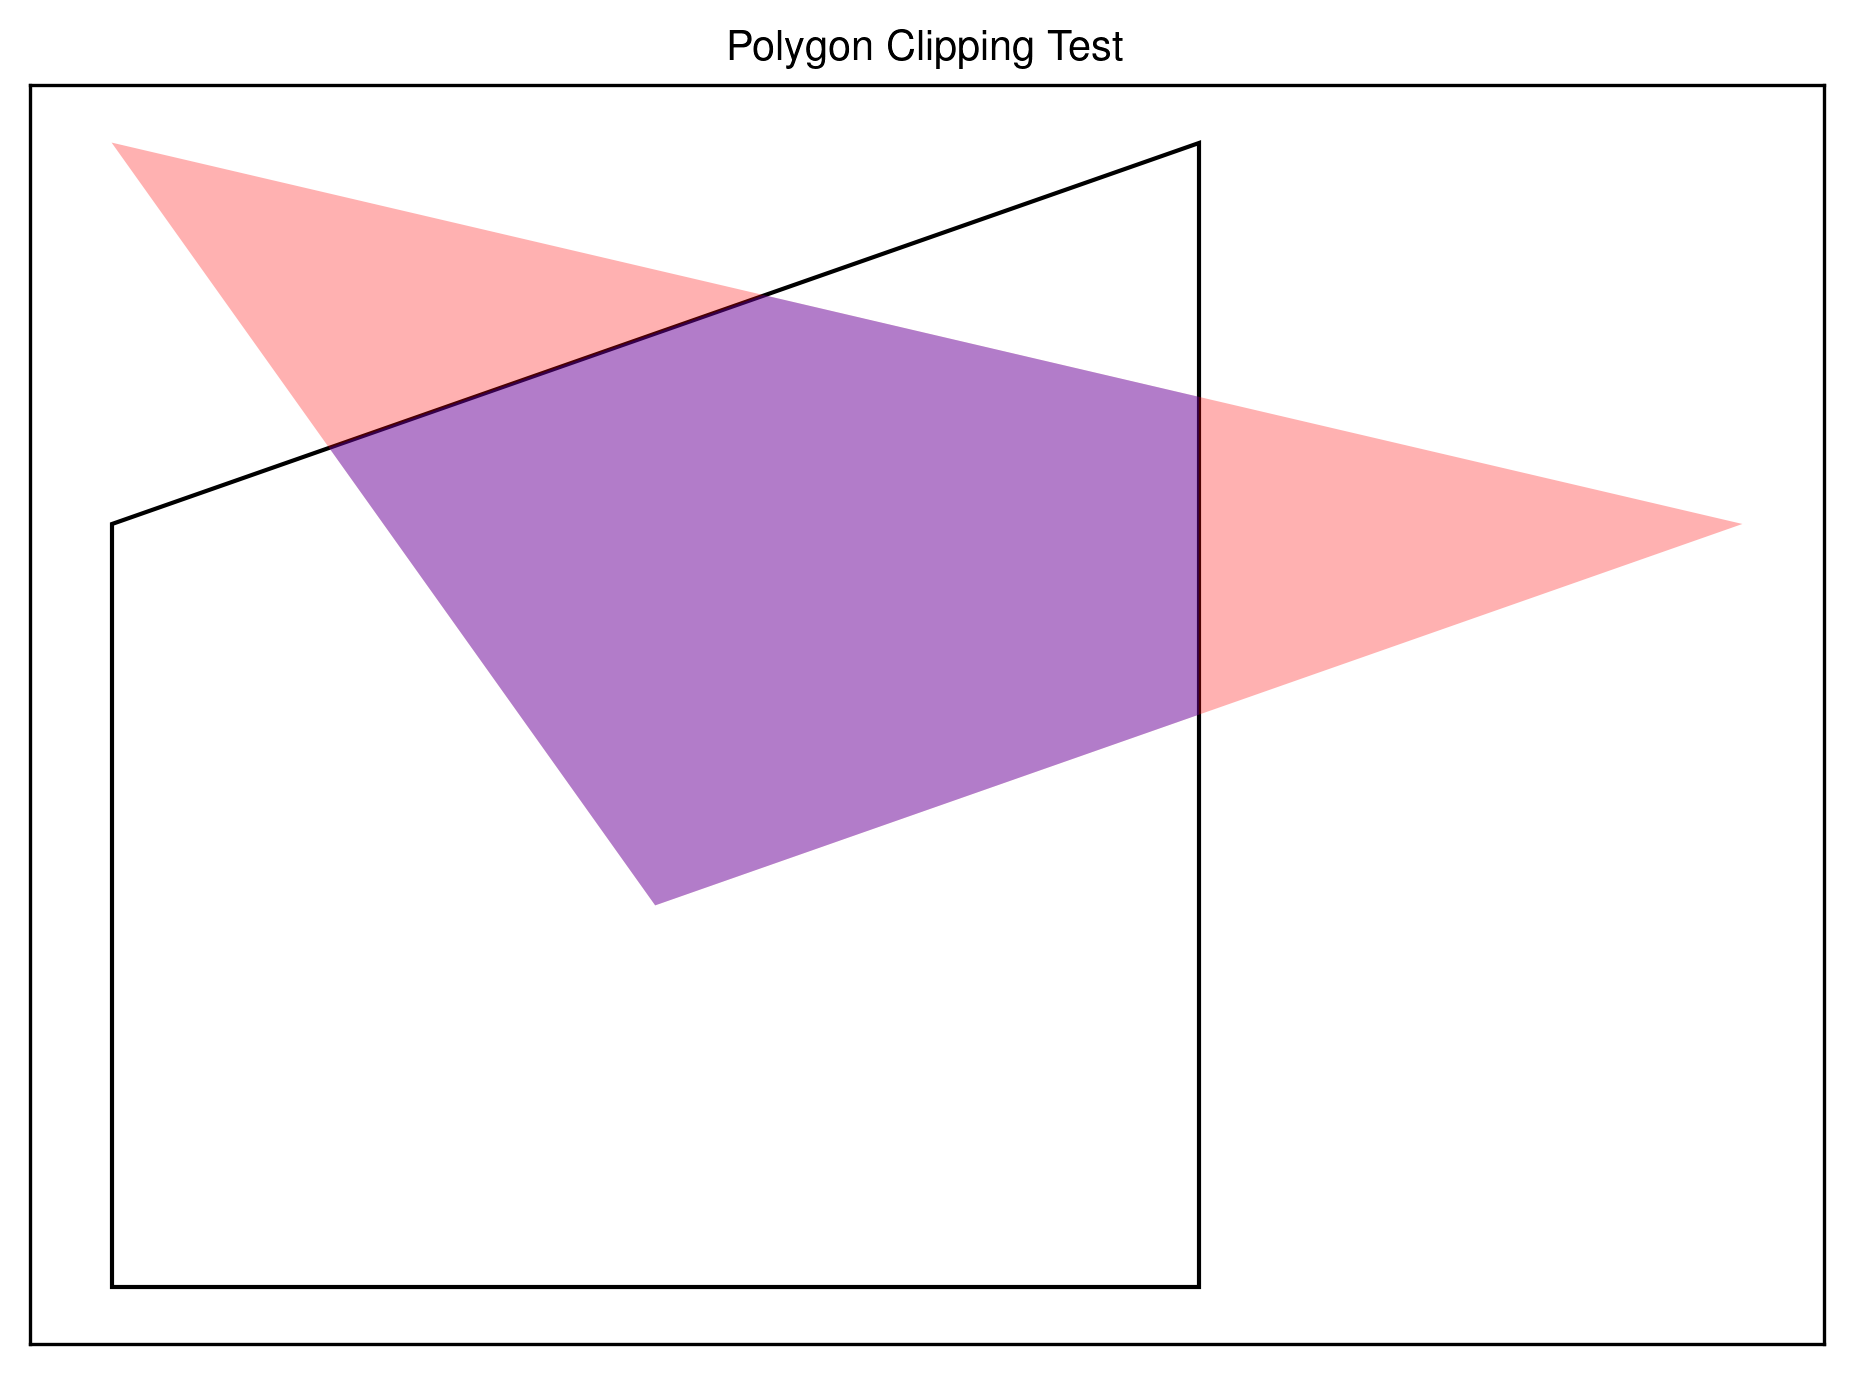

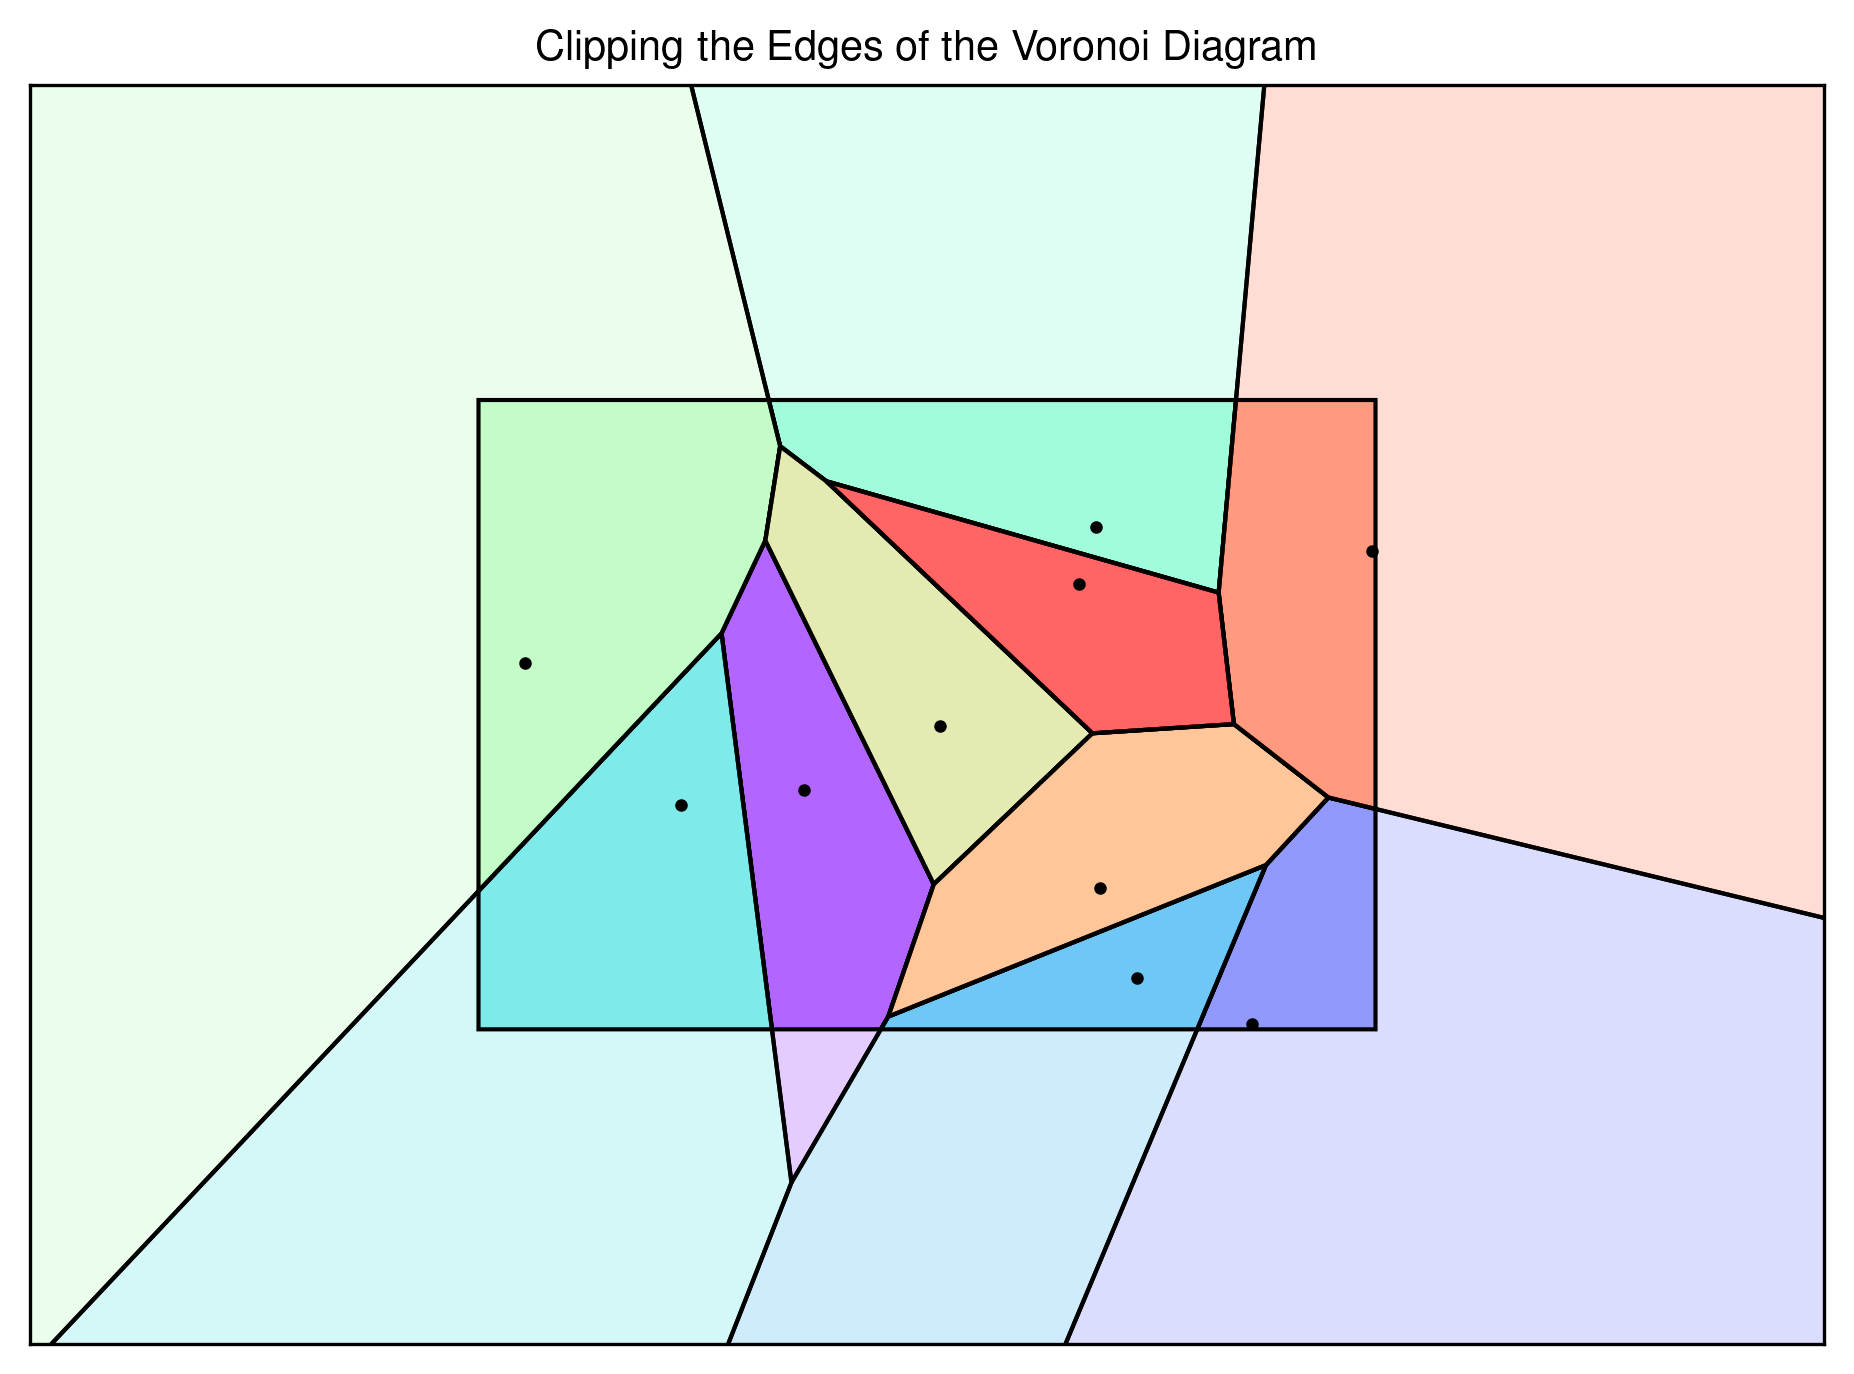

In [9]:
def inside(point, line):
    """
    Determine if a point is on the right side of a line
    
    When going clockwise, being on the right side of an edge means 
    the point is inside the box
    Arguments:
        point:  numpy array in format [x, y]
        line:   numpy array in format [[x1,y1],[x2,y2]]
                where the line starts at (x1,y1) and ends at (x2,y2)
    Returns:
        True if point is on or to the right of line, else False
    """
    P = np.flip(np.diff(line, axis=0)[0]) # gives [(y2-y1),(x2-x1)]
    P *= point - line[0] # gives [(y2-y1)(x - x1), (x2-x1)(y-y1)]
    P = np.diff(P)[0]
    return P <= 0

def get_intersect(line1, line2):
    """
    Determine the coordinates of the intersection between two lines
    by projecting into 3D space and taking the cross product
    Arguments:
        line1, line2:   numpy arrays in format [[x1,y1],[x2,y2]]
    Returns:
        P:  intersection point in format [x,y]
    """
    # get the equation of each line from the cross product of two points
    # line t = p1 x p2 must pass through both p1 and p2
    # since t . p1 = (p1 x p2) . p1 = 0
    points = np.vstack((line1, line2))
    
    # Add a third homogeneous coordinate
    points_3D = np.hstack((points, np.ones((4,1))))
    
    # Get vectors representing each line
    l1 = np.cross(points_3D[0], points_3D[1])
    l2 = np.cross(points_3D[2], points_3D[3])
    
    # Get the intersection of the two lines
    x,y,z = np.cross(l1, l2)
    
    if z == 0:
        return np.array([float('inf'), float('inf')])
    return np.array([x / z, y / z])

def clip(boundary, polygon):
    """
    Clip a polygon defined by its vertices to the given bounding box
    Arguments:
        boundary:   numpy array of the vertices of the bounding polygon to clip to,
                    given in clockwise order
        polygon:    numpy array of the vertices of the polygon to be clipped,
                    given in clockwise order
        
    """
    clipped = polygon.copy()
    
    box_edges = np.stack((boundary, np.roll(boundary, -1, axis=0)), axis =1)

    for box_edge in box_edges:
        edge_clipped = []
        for i, v1 in enumerate(clipped):
            v2 = clipped[i-1]
            is_inside = [inside(v1, box_edge), inside(v2, box_edge)]
            
            # if both vertices are outside, move along
            if np.all(is_inside):
                # Both vertices are inside the box, add the second vertex to final shape
                edge_clipped.append(v2)
                continue
            elif is_inside[0]:
                # Only the first vertex is inside, add the intersect to final shape
                edge_clipped.append(get_intersect(np.array([v1, v2]), box_edge))
                continue
            elif is_inside[1]:
                # Only the second vertex is inside, add both the second vertex and
                # the intersect to the final shape
                edge_clipped.append(v2)
                edge_clipped.append(get_intersect(np.array([v1, v2]), box_edge))
        edge_clipped = np.array(edge_clipped)
        # update the polygon after clipping to each edge
        clipped = edge_clipped
    return clipped


# Test the clipping algorithm
box = np.array([[2,3],[2,0],[0,0],[0,2]], dtype=float)
shape = np.array([[1,1],[0,3],[3, 2]], dtype=float)

fig, ax = plt.subplots()
ax.fill(box[:,0], box[:,1], facecolor = (0,0,0,0), edgecolor='black')
ax.fill(shape[:,0], shape[:,1], facecolor = 'red', alpha=.3)

new_shape = clip(box, shape)
ax.fill(new_shape[:,0], new_shape[:,1], facecolor = 'blue', alpha=.3)
no_ticks(ax)
ax.set_title(f"Polygon Clipping Test")

plt.show()


# Plot the clipped Voronoi diagram
fig, ax = plt.subplots()

# Define the edges of the box in clockwise order
box = np.array([[w,h],[w,0],[0,0],[0,h]], dtype=float)

for i, cell in enumerate(cells):
    
    # Plot the cell before clipping to the boundaries
    ax.fill(cell[:,0], cell[:,1],
            facecolor=mpl.colors.to_rgba(colors[i],0.2), edgecolor='black')
    # Clip the cell to the boundary and plot
    new_shape = clip(box, cell)
    if new_shape.shape[0] == 0:
        continue
    ax.fill(new_shape[:,0], new_shape[:,1],
        facecolor=mpl.colors.to_rgba(colors[i],0.5), edgecolor='black')

# Plot the original sites
ax.plot(sites[:,0], sites[:,1], 'ko')

ax.set_xlim(-.5*w,1.5*w)
ax.set_ylim(-.5*h,1.5*h)

no_ticks(ax)
ax.set_title(f"Clipping the Edges of the Voronoi Diagram")
#plt.savefig('clipping_infinite_edges.png')

plt.show()

### Putting it all together

Now we can package all of these functions into a class for power diagrams, stored in <code>voronoi.py</code>. Putting this calculation into a class also lets us save certain attributes for each instance of the class rather than repeating any calculations that we've already done.

First let's double check that the this class is working as intended:

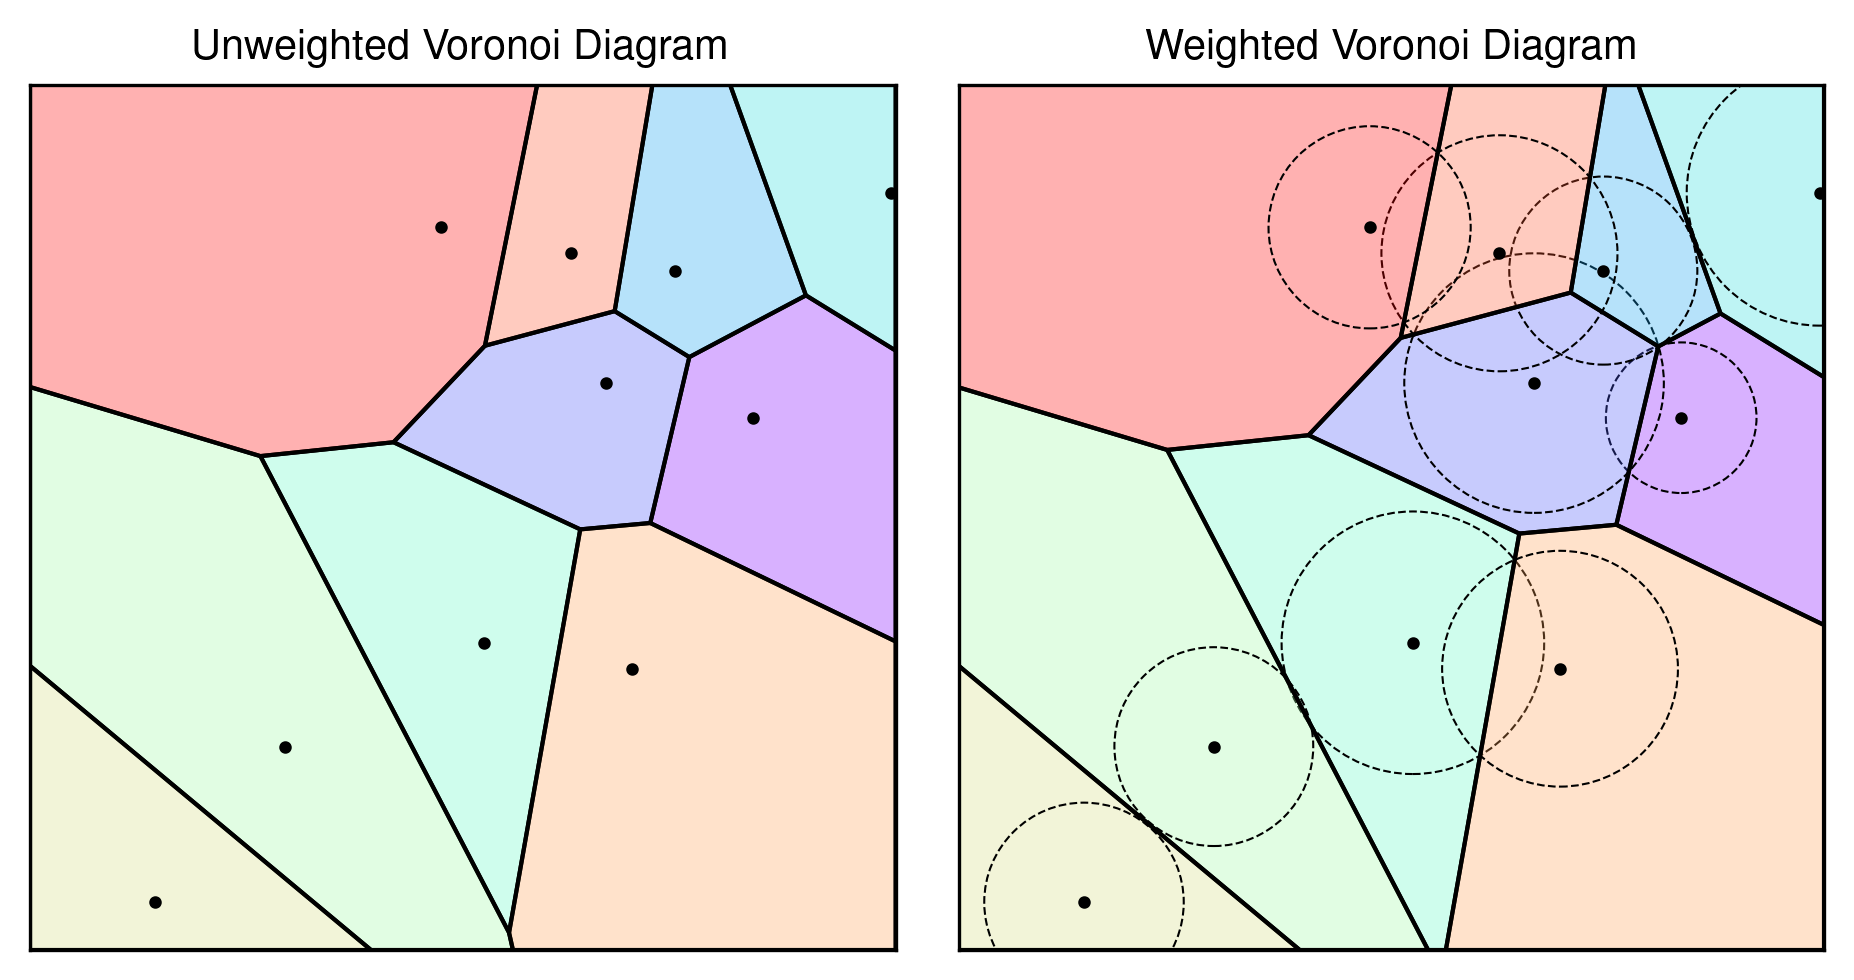

In [10]:
h, w = 100,100
N = 10

import voronoi

X, Y = np.indices((h,w))
weights = np.random.rand(N)*250

# Randomly pick an index
idx = np.arange(X.size)
rand_idx = np.random.choice(idx, N, replace = False)

# Get the coordinates of each sampled point
pts = np.array([X.flatten()[rand_idx], Y.flatten()[rand_idx]], dtype=float).T

# Calculate the unweighted Voronoi
unweighted = voronoi.Voronoi(pts, (h, w))
# Calculate the weighted Voronoi
weighted = voronoi.Voronoi(pts, (h,w), weights)

fig, (ax1, ax2) = plt.subplots(1,2)

unweighted.plot(ax=ax1)
weighted.plot(ax=ax2, plot_weights = True)

ax1.set_title('Unweighted Voronoi Diagram')
ax2.set_title('Weighted Voronoi Diagram')

plt.show()

All centroids within 1.0% after 31 iterations of Lloyd relaxation


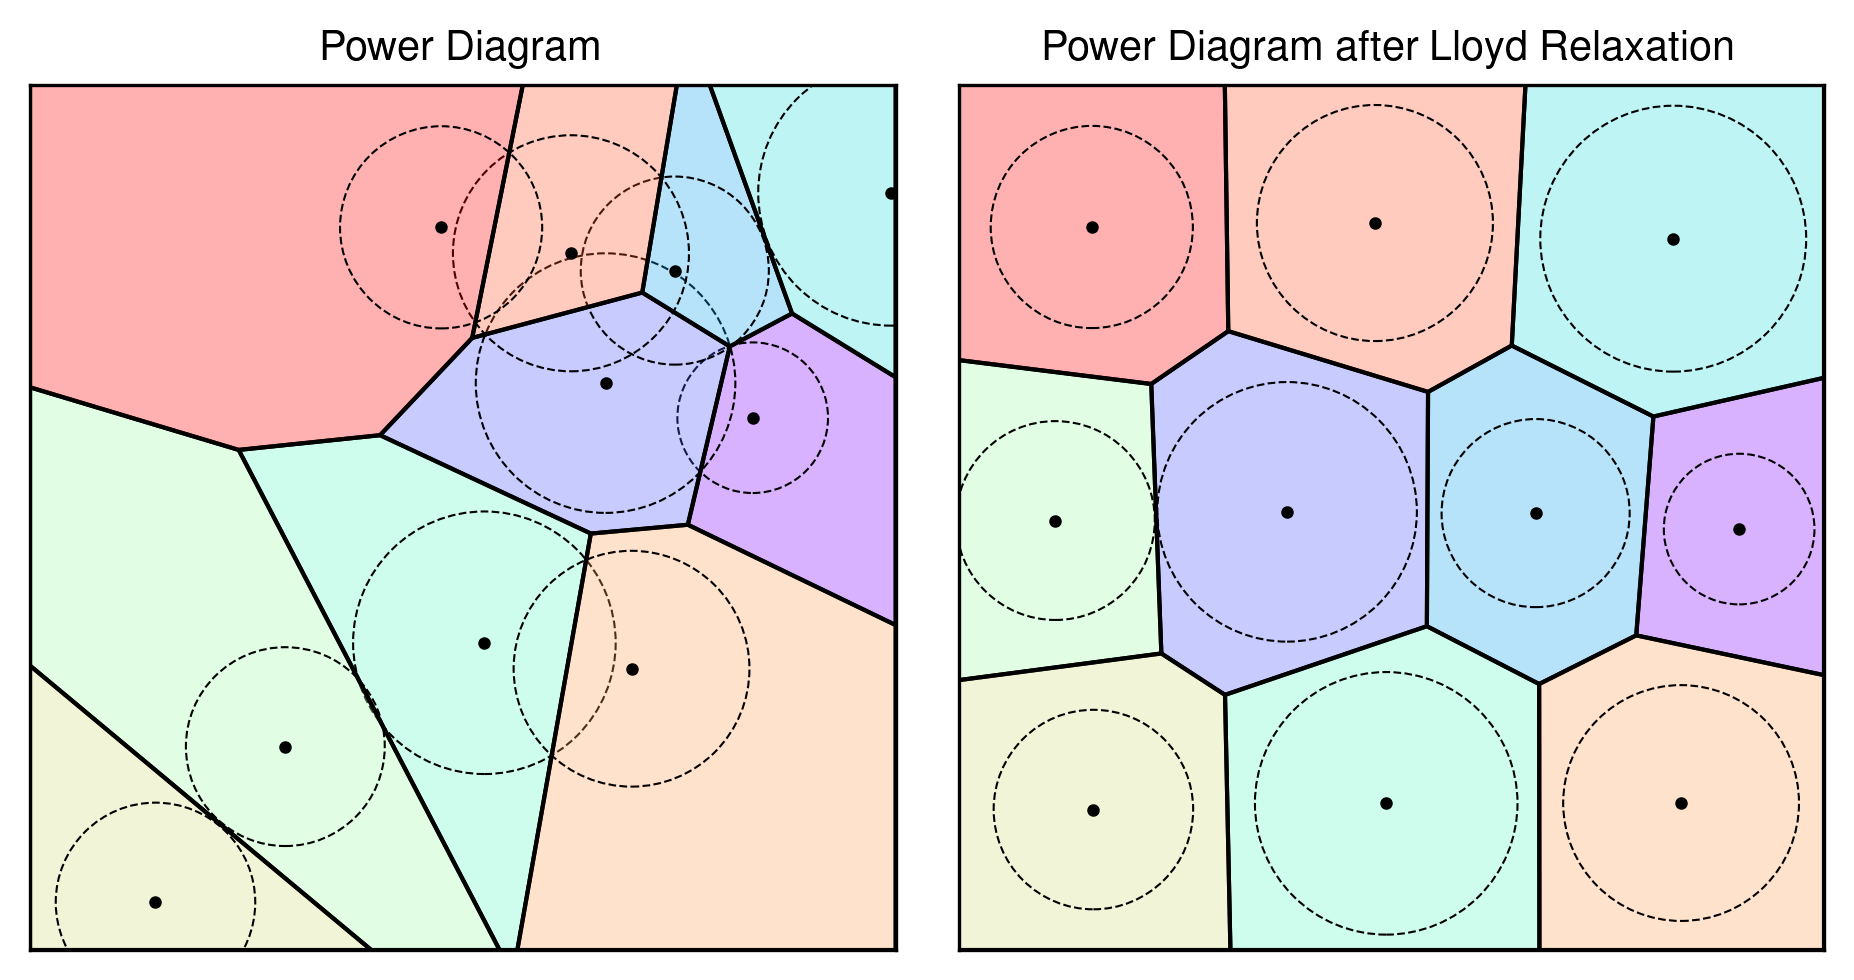

In [11]:
# Test out Lloyd relaxation

vor = voronoi.Voronoi(pts, (h, w), weights)

fig, (ax1, ax2) = plt.subplots(1,2)
vor.plot(ax=ax1, plot_weights=True)

vor.lloyd(threshold=.01)
vor.plot(ax=ax2, plot_weights=True)
ax2.set_title("Power Diagram after Lloyd Relaxation")
plt.show()

## 2. Power Diagrams of Image Data

Now it's time to look at how these power diagrams act when we calculate them for a given *image*. How does the image change things? **The intensity of a pixel acts as a weight when we calculate the the properties of the Voronoi cell containing that pixel**, meaning that if we have two Voronoi cells with the exact same shape but one is on a bright spot in the image and the other a dark spot, the cell on the bright spot will have a larger *weighted* area. Similarly different intensities within a single Voronoi cell will skew the cell's *weighted* center of mass toward the brighter areas of the cell. 

### Weighted Area, Center of Mass, and Moment of Inertia

The weighted area of a cell is found using the intensity of each pixel enclosed or crossed by the edges of the cell. 

Because we will need many many cells for this analysis (Kasim recommends around 80% of the number of pixels in the image being processed), the size of the cells will be of the same order as the size of the pixels in the image, so the portion of a pixel that is inside vs outside a cell is significant. This means we not only need a way to select all the pixels that are fully enclosed by a cell, but we also need to determine the *fraction of the area* that is inside the cell for any pixels that are intersected by the edges of the cell. The helper script <code>rasterize.py</code> contains all the functions to do this.

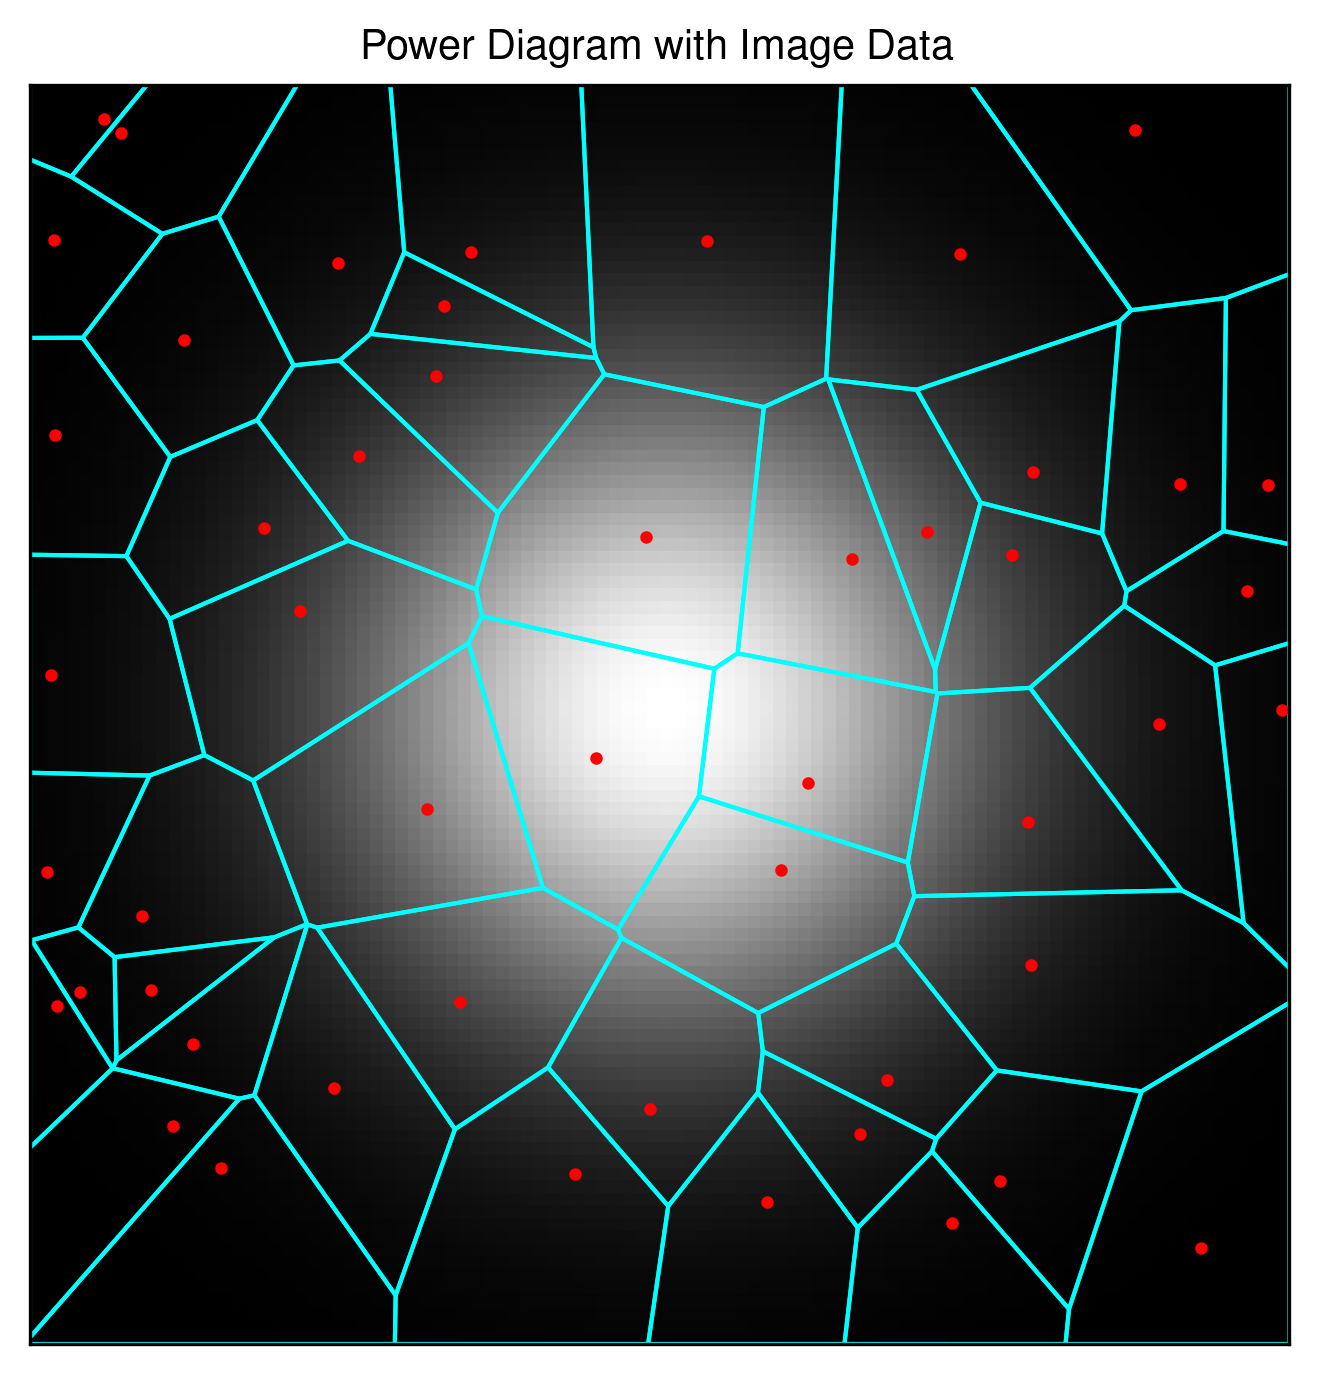

CPU times: user 832 ms, sys: 1.47 s, total: 2.3 s
Wall time: 1.57 s


In [12]:
%%time

# Generate a test image and deploy some sites onto it
h, w = 100,100
N = 50
shape = (h, w)

Y, X = np.indices(shape, dtype=float)

sigma = .25*h
gauss = lambda x, y: np.exp(-((x - w//2)**2 + (y - h//2)**2)/sigma**2)
image = gauss(X,Y)
image /= np.sum(image)

# Randomly pick N points
pts = np.random.rand(N, 2)
pts[:,0] *= w-1
pts[:,1] *= h-1
vor = voronoi.Voronoi(pts, shape=(h,w), image=image, clip = True)

fig, ax = plt.subplots()
vor.plot(ax=ax, plot_image = True)
ax.set_title('Power Diagram with Image Data')
plt.show()

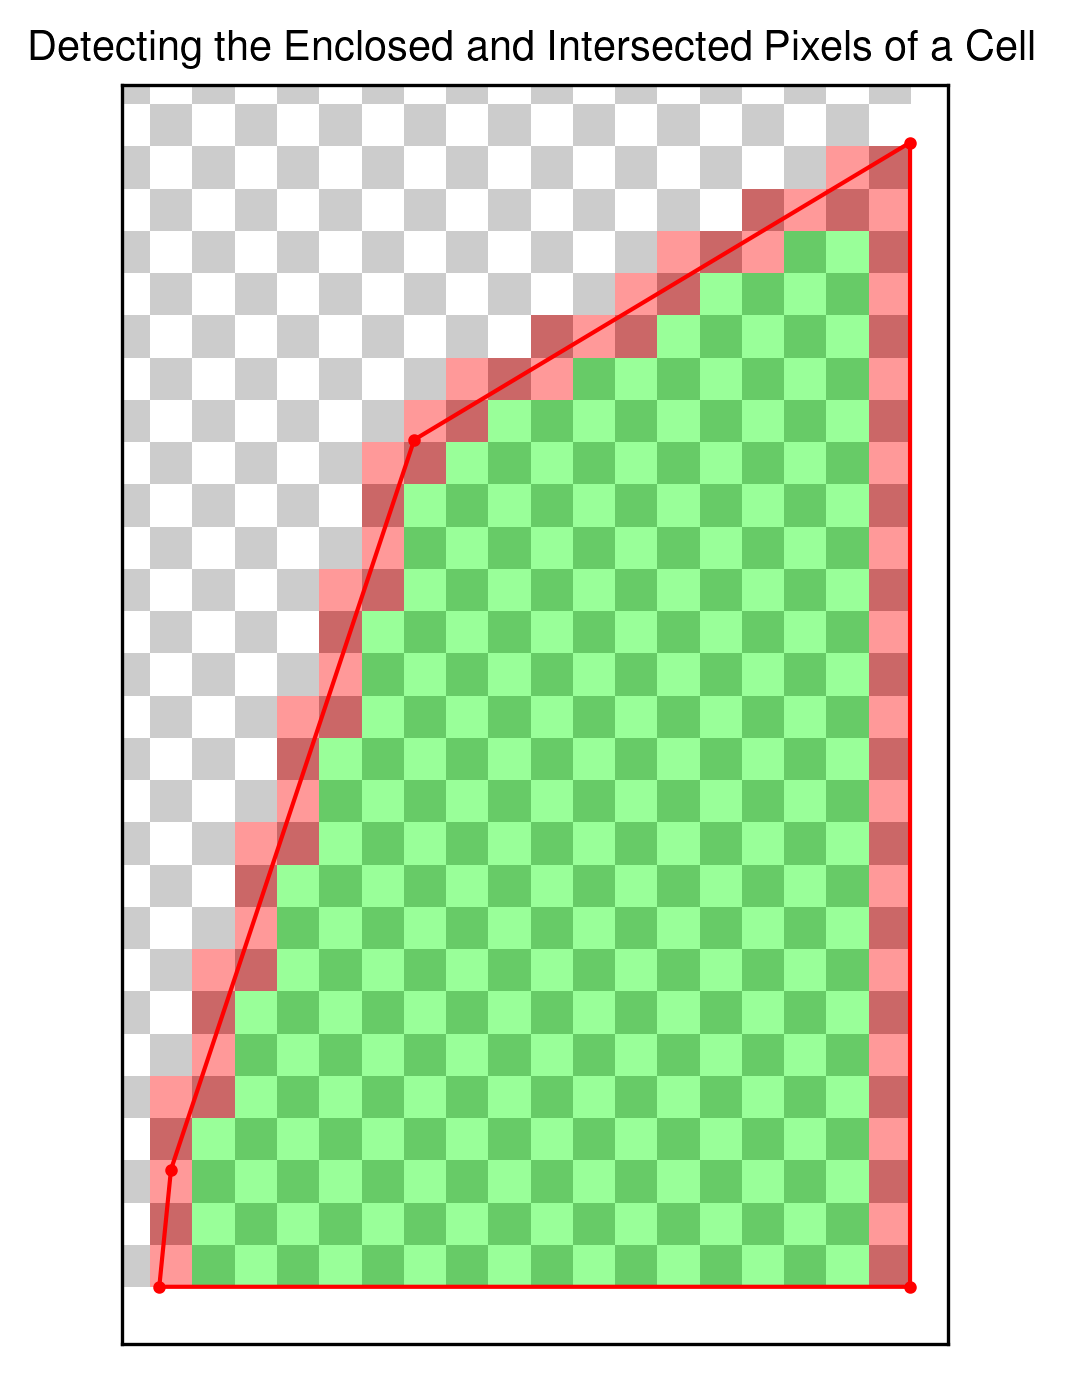

In [13]:
# Grab one site and its cell for testing
site = 0
point = vor.sites[site]
cell = vor.regions[site]

fig, ax = plt.subplots()
ax.set_title('Detecting the Enclosed and Intersected Pixels of a Cell')

# Plot the cell's original polygon
cell.plot(ax=ax, facecolor=(1,0,0,0), edgecolor='red', zorder=3)
freeze_ax(ax)

def int_grid(ax=None):
    ''' Add an integer checkered grid to help visualize pixels in a plot '''
    if ax is None:
        ax = plt.gca()
    freeze_ax()
    # Define the checkers
    int_grid = np.zeros((h,w), dtype=int)
    int_grid[::2,::2] = 1
    int_grid[1::2,1::2] = 1
    # Draw the grid
    ax.imshow(int_grid, cmap='gray', alpha = 0.2)
    ax.set_aspect('equal')
    return


import rasterize as ras
edges = ras.get_edge_pixels(cell, (h,w))

# Plot the intersected pixels in red
cmap = mpl.colors.ListedColormap([(0,0,0,0), 'red'])
ax.imshow(edges, cmap=cmap, alpha=.5)

#grid = voronoi_grid(np.fliplr(img_tess.sites), (h, w))

enclosed = ras.get_enclosed_pixels(cell, (h,w))

# Remove any pixels from the enclosed list that are already part of the edges
enclosed[edges] = False

# Plot the fully enclosed pixels in green
cmap = mpl.colors.ListedColormap([(0,0,0,0), 'lime'])
ax.imshow(enclosed, cmap=cmap, alpha=.5)

int_grid()
no_ticks()
plt.show()

For the fully enclosed pixels, the contribution to any of these weighted functions is simple, since the pixel area is normalized to 1. For those that are intersected by the edges of the cell, however, the pixel needs to be clipped to the edge of the cell before its area can be calculated and added into the rest of the cells.

Let's take a look at this single cell again to make sure that the individual pixels are being clipped to the edges of the cell correctly:

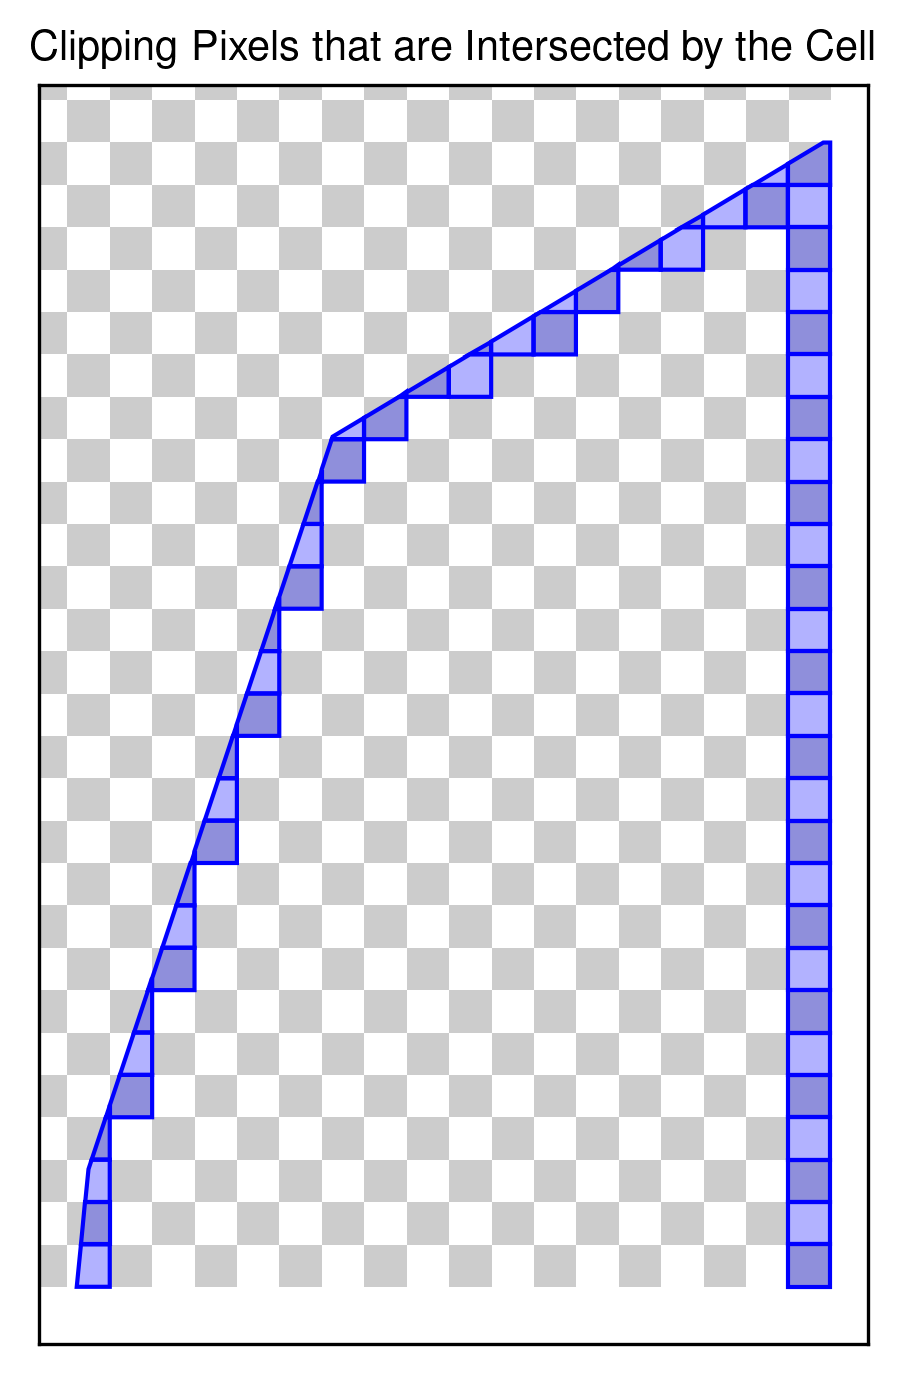

In [14]:
fig, ax = plt.subplots()
ax.set_title('Clipping Pixels that are Intersected by the Cell')

# Rasterize the cell and plot each edge pixel after being clipped to the cell
ras.rasterize(cell, (h,w), plot=True, plot_points=False, facecolor=(0,0,1,.3), edgecolor='b')
int_grid()
no_ticks()
plt.show()

Using these clipped pixels we can calculate the area and center of mass of each pixel in the cell and map these onto the intensity values of our image to get weighted statistics for the cell.

Running these calculations one after another is super slow, so I implemented a multiprocessing method to run these in parallel for all the cells in the power diagram.

After some considerable restructuring of the code these weighted statistics can be used in the Lloyd relaxation algorithm rather than weighting the sites by the intensity of the image, which is a significant improvement in the accuracy of the relaxation, especially when there aren't many sites compared to the number of pixels in the image.

To check that we're on the right track let's compare the center of mass of this cell with and without the image intensity weighting the calculation:

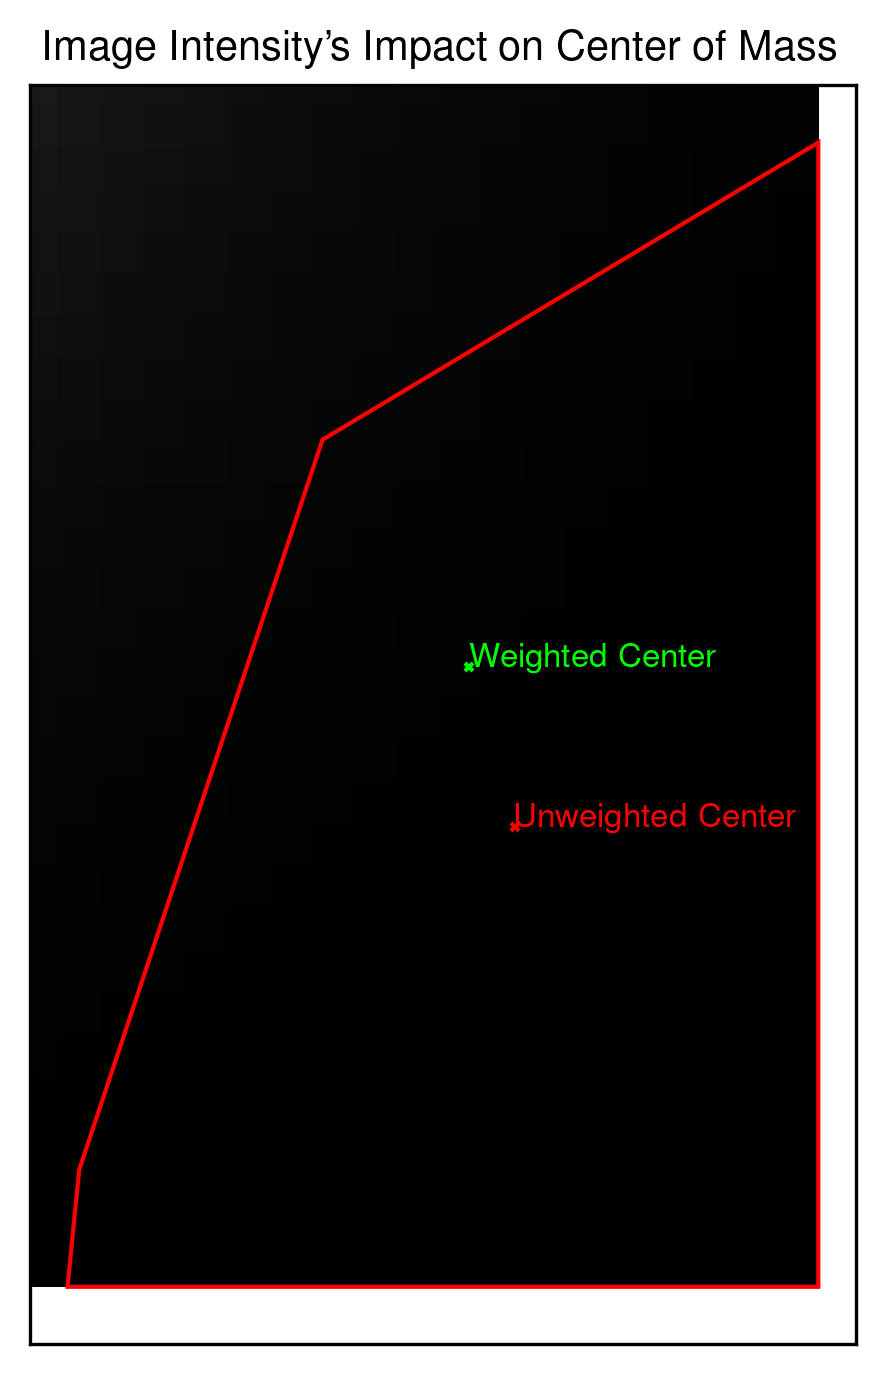

In [15]:
import shapes

fig, ax = plt.subplots()
ax.set_title("Image Intensity's Impact on Center of Mass")

no_ticks()
cell.plot(ax=ax, facecolor=(1,0,0,0), edgecolor='r', plot_points=False, zorder=3)
c_weighted = cell.c
ax.plot(*c_weighted, 'x', c='lime')
ax.text(*(c_weighted), 'Weighted Center',c='lime', size=8, ha = 'left')

unweighted = shapes.Polygon(cell.vertices)
c_unweighted = unweighted.c
ax.plot(*c_unweighted, 'rx')
ax.text(*(c_unweighted), 'Unweighted Center',c='red', size=8, ha = 'left')
freeze_ax()

ax.imshow(image, cmap='gray')
ax.set_aspect('equal')
plt.show()

Now we can see how these weighted properties affect the Lloyd relaxation of this Voronoi diagram:

All centroids within 5.0% after 14 iterations of Lloyd relaxation


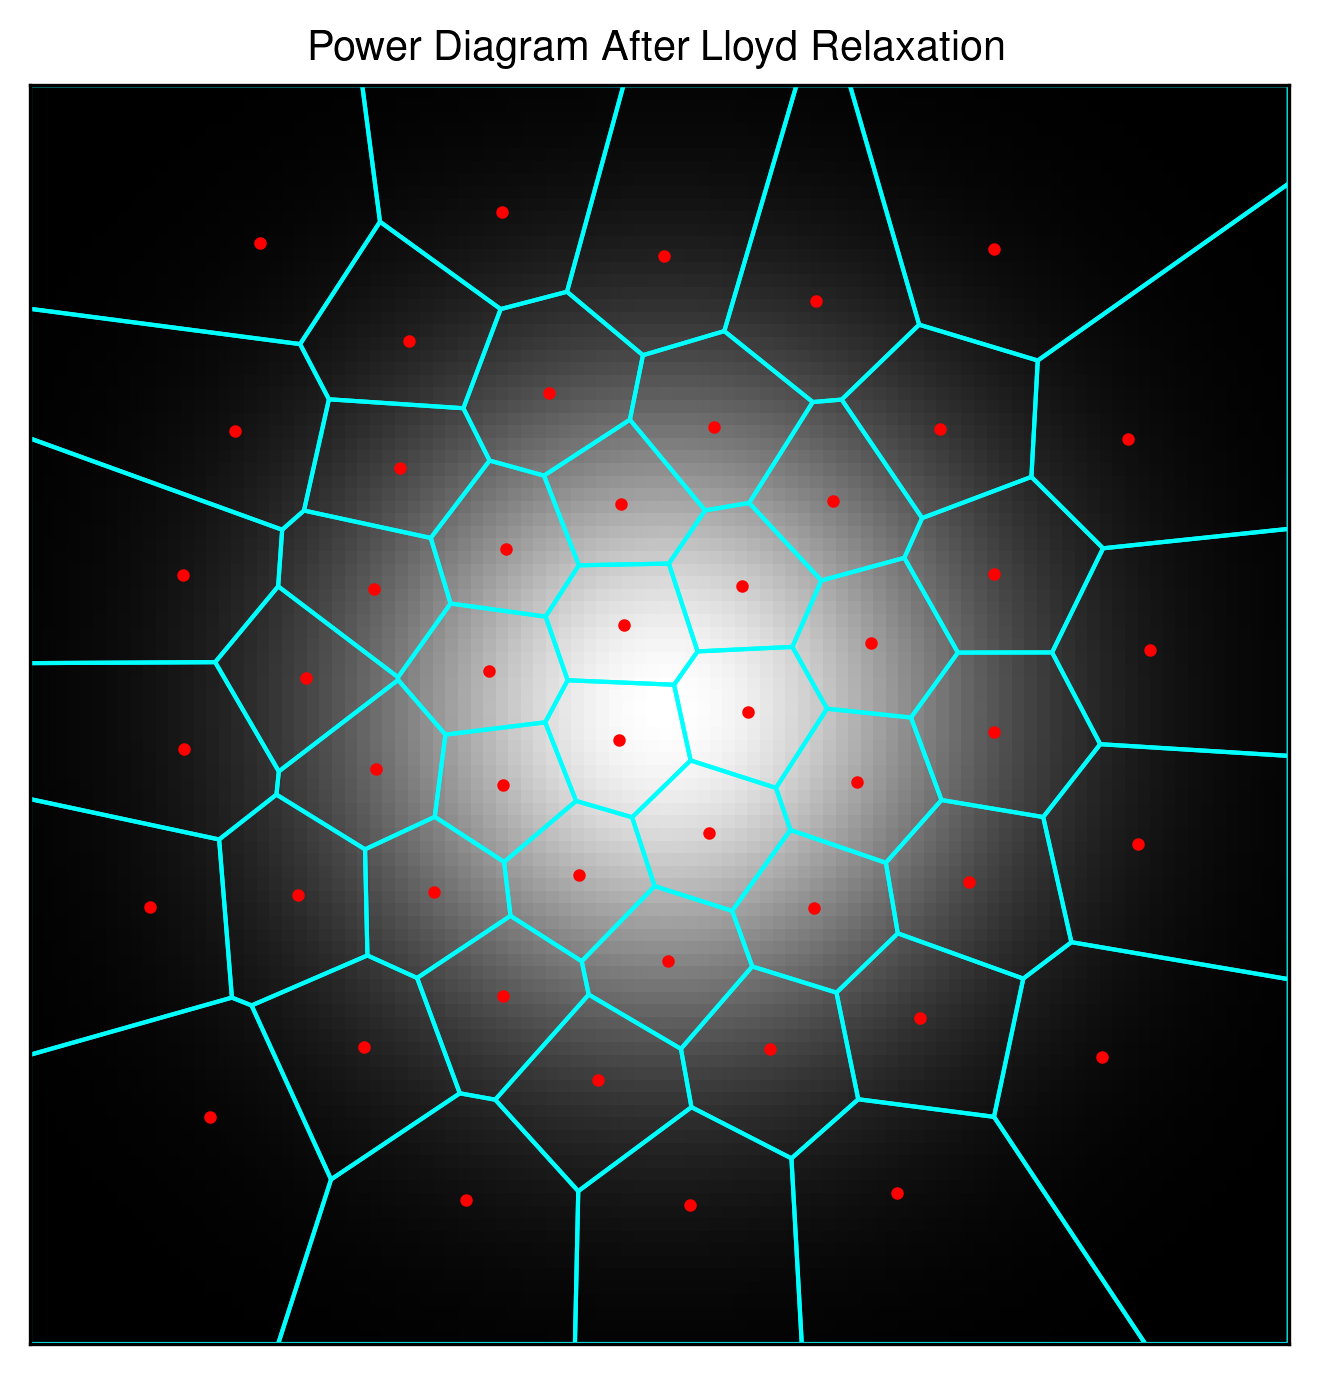

In [16]:
vor.lloyd()

fig, ax = plt.subplots()
vor.plot(ax=ax, plot_image = True)
ax.set_title('Power Diagram After Lloyd Relaxation')

plt.show()

As you can see including these pixel intensities in our area, centroid, and moment of inertia calculations makes the Lloyd algorithm converge to cells of uniform *flux* rather than geometric area as it was before. Great! This is what we wanted. Now we can move on to the actual deflection potential calculation.

## 3. Test Data and Importance Sampling

First thing's first, we'll need some test data to use while developing all of these methods.

### Forward-Mapping the Deflection Potential

In order to verify that our analysis is working, we need to start with a deflection potential we know, and determine the target image it would give us for a given source image. Then we can feed that source and target image pair to the invert-shadowgraphy code we've written so far in order to check that it returns a deflection potential similar to what we started with.

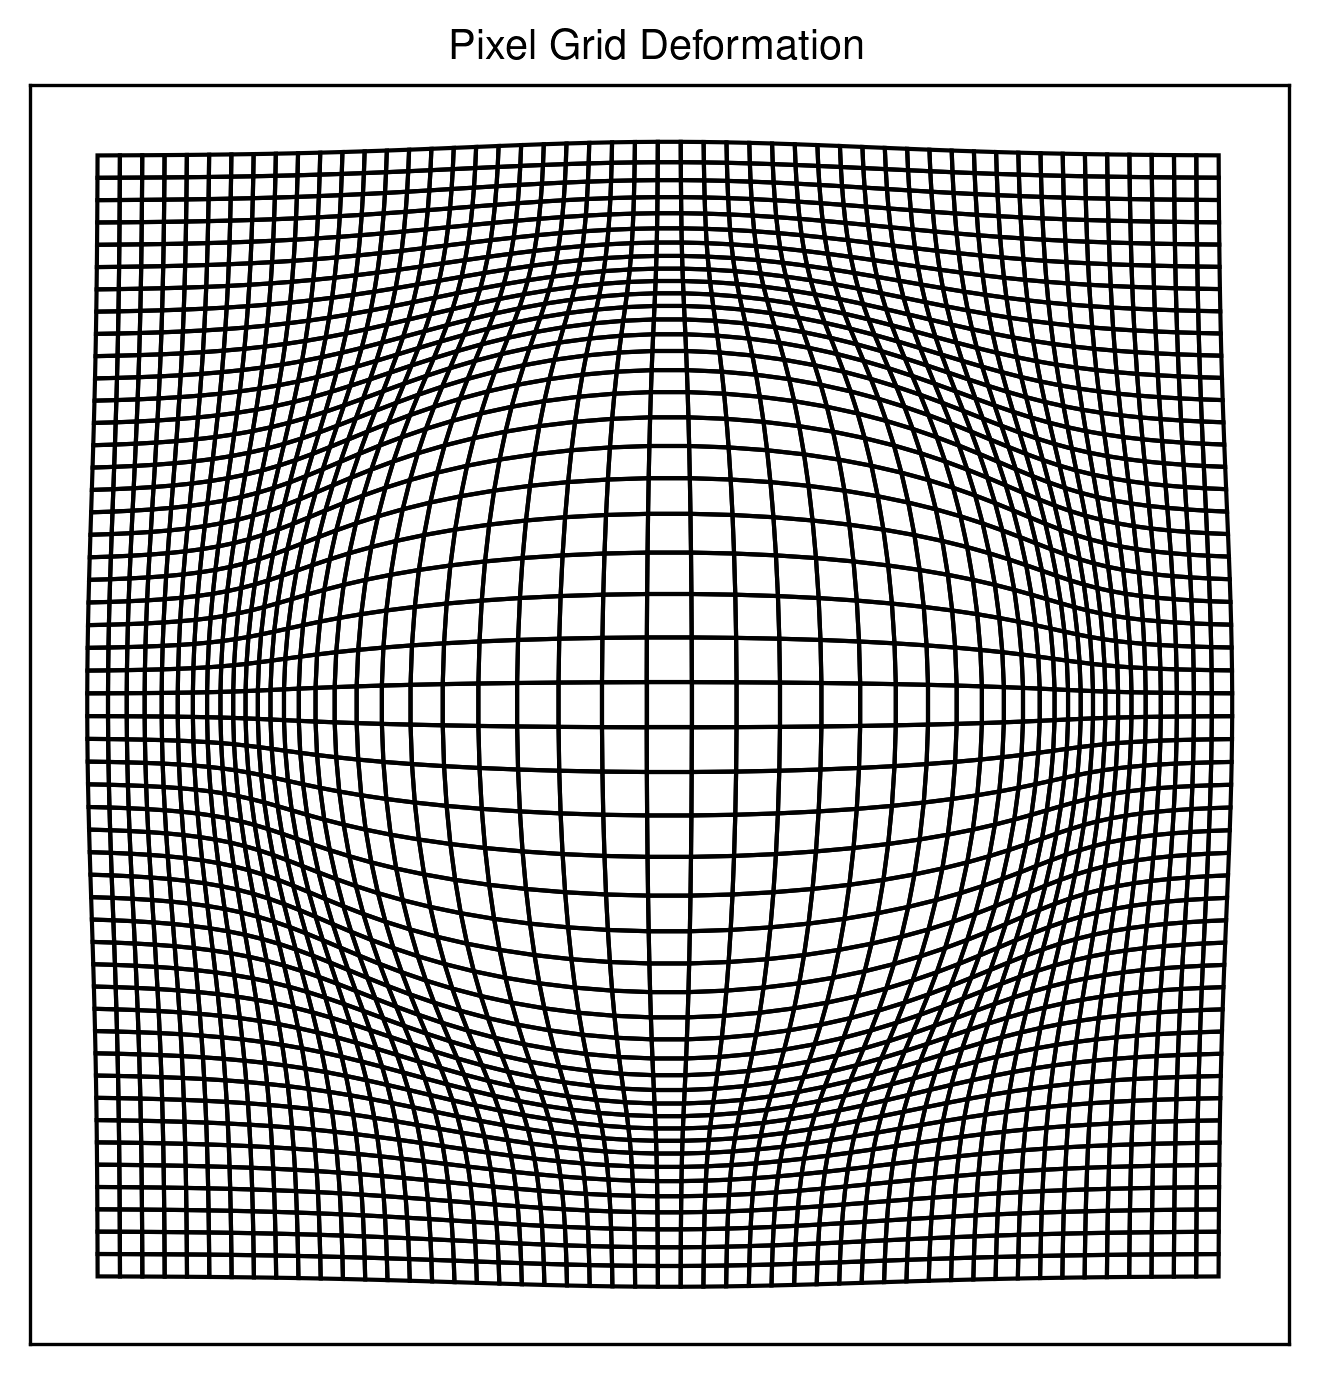

CPU times: user 14.5 s, sys: 212 ms, total: 14.7 s
Wall time: 14.4 s


In [17]:
%%time
from multiprocessing import Pool
import shapes
import rasterize as ras

# Define the image size and distance from source to target plane
h, w = 50,50
shape = (h,w)
L = 1 # distance between source and target in *pixels*

# Define the source image (just a Gaussian for now)
Y, X = np.indices(shape)
source_image = np.exp(-((X.astype(float) - w//2)**2 + (Y.astype(float) - h//2)**2)/(sigma**2))#np.ones((h,w))
source_image /= np.sum(source_image)

# Define a Gaussian deflection potential
sigma = 0.25 * h
phi_0 = 80 # peak value of the deflection potential
phi_func = lambda x, y: phi_0 * np.exp(-((x - w//2)**2 + (y - h//2)**2)/sigma**2)

# get the coordinates of each *corner* of the pixels (i.e. each intersection on the grid)
pix_y, pix_x = np.indices((h+1, w+1), dtype=float) - 0.5

# evaluate the deflection potential at each pixel corner
phi = phi_func(pix_x,pix_y)

# Get the deflection in each direction from the gradient of the deflection potential
ay, ax = np.gradient(phi)

# Calculate the final x and y coordinates of each pixel vertex on the target plane
xmap = pix_x - ax * L
ymap = pix_y - ay * L

target_image = np.zeros_like(source_image)

fig, ax = plt.subplots()
points = np.stack((xmap, ymap)).T # [w, h, axis]

# For each pixel in the source plane, map it onto the target plane
for i, j in zip(X.flatten(), Y.flatten()):
    # Get the four vertices of the pixel
    p1 = points[i, j]
    p2 = points[i+1, j]
    p3 = points[i, j+1]
    p4 = points[i+1, j+1]
    verts = np.array([p1, p2, p3, p4])
    
    # Calculate the mean coordinate to estimate the center of the polygon (for clockwise sorting)
    center = np.mean(verts, axis=0)
    # sort the vertices in clockwise order
    verts = np.array(sorted(verts,
                            key = lambda v: np.arctan2((v[0] - center[0]), (v[1] - center[1]))))
        
    pixel = shapes.Polygon(verts)
    # Get the pixel intensity on the source plane
    I_0 = source_image[j, i] / pixel.A
    
    # Get the map of how much of this deformed pixel'a area is in each pixel of the target image
    A_map, _, _ = ras.rasterize(pixel, shape)
    
    # Add this source pixels contribution to the target plane image
    target_image += I_0 * A_map
    
    # Show how the pixel has been deformed by the deflection potential
    pixel.plot(ax=ax, plot_points = False)

no_ticks()
ax.set_title('Pixel Grid Deformation')
plt.show()

Of course there's a much faster way to do this forward mapping using multiprocessing methods I've written in the helper script <code>forward_deflection.py</code>, that will do this several times faster. Let's take a look at the final target plane image this gives us:

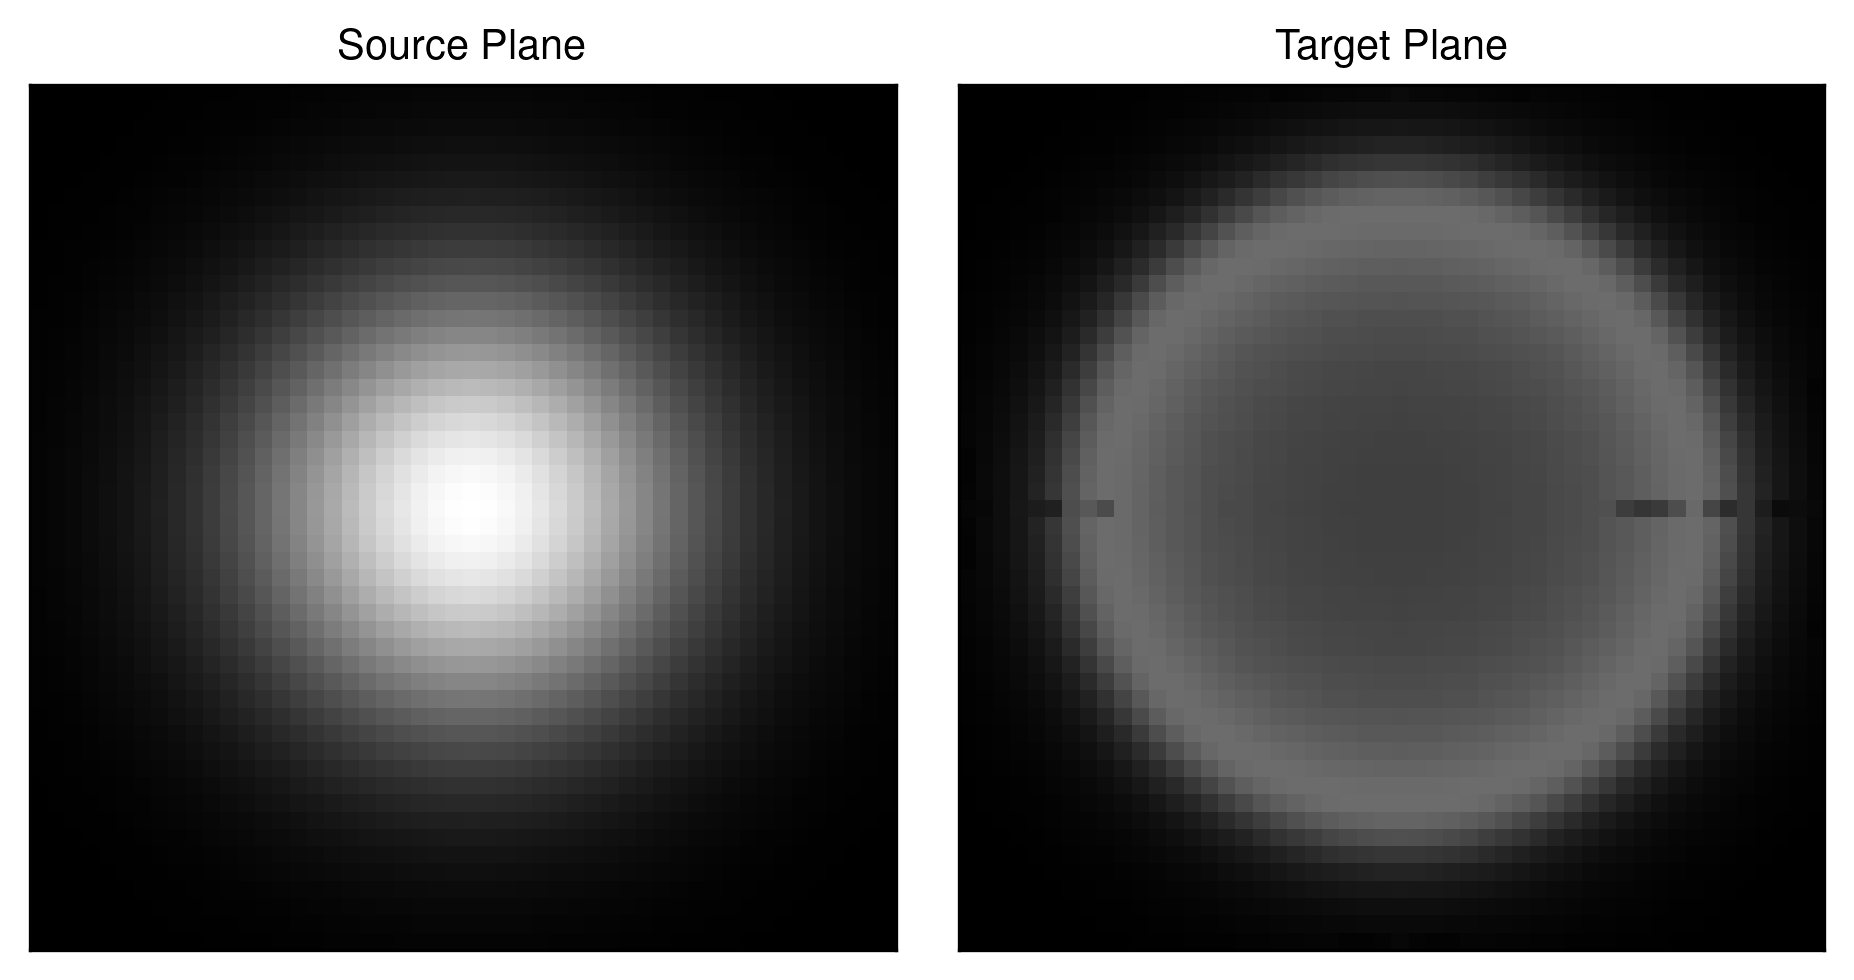

CPU times: user 986 ms, sys: 1.59 s, total: 2.58 s
Wall time: 2.11 s


In [17]:
%%time
import forward_deflection as fw

h, w = 50,50
shape = (h,w)
L = 1 # distance between source and target planes in _pixels_

Y, X = np.indices(shape)

sigma = 0.25 * h # sigma of the gaussian
phi_0 = 80 # peak value of the deflection potential

# Define a gaussian function for the deflection potential
phi = lambda x, y: phi_0 * np.exp(-((x - w/2.)**2 + (y - h/2.)**2)/sigma**2)

# define the source plane image
source_image = np.exp(-((X.astype(float) - w/2)**2 + (Y.astype(float) - h/2)**2)/(sigma**2))#np.ones((h,w))
source_image /= np.sum(source_image)

target_image = fw.forward_map(source_image, phi, L)

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.pcolormesh(X,Y, source_image, cmap='gray', vmax=source_image.max(), vmin = 0)
ax1.set_aspect('equal')
no_ticks(ax1)
ax1.set_title("Source Plane")

ax2.pcolormesh(X, Y, target_image, cmap='gray', vmax=source_image.max(), vmin = 0)
ax2.set_aspect('equal')
no_ticks(ax2)
ax2.set_title("Target Plane")
plt.show()

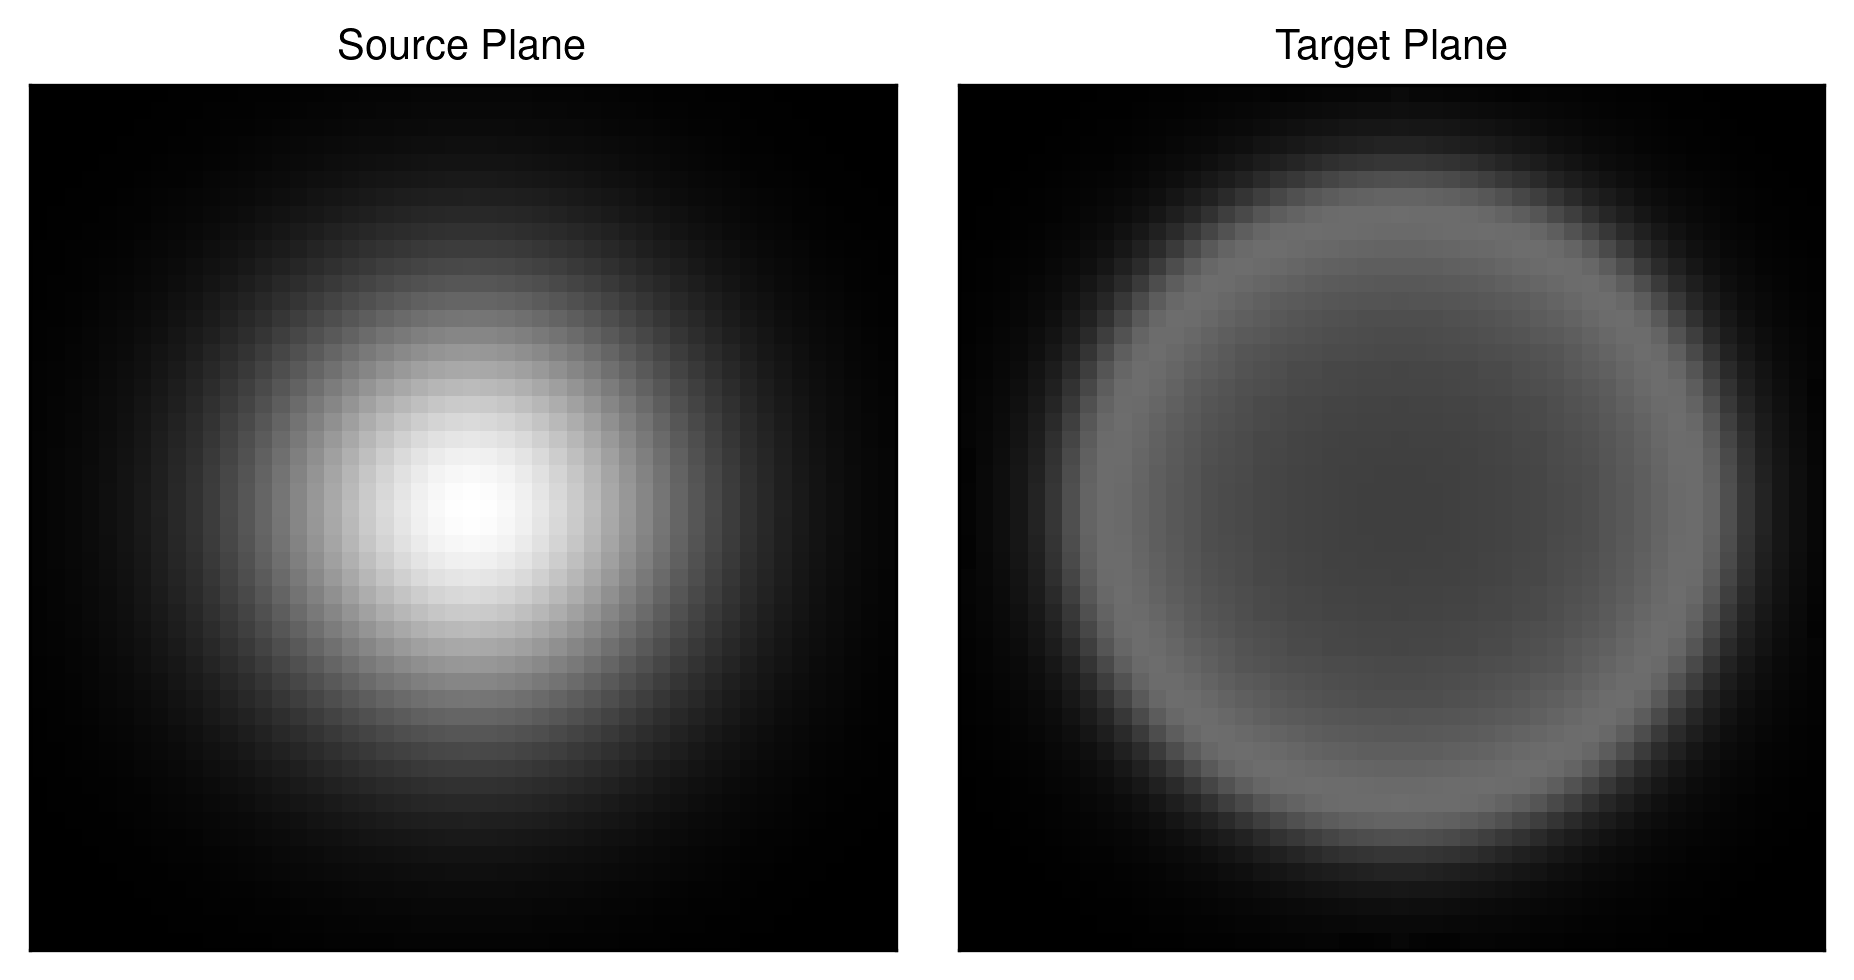

In [18]:
# Fix the funky row of pixels along the center row
target_image[h//2,:] = (target_image[h//2+1,:] + target_image[h//2-1,:])/2
target_image /= np.sum(target_image)

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.pcolormesh(X,Y, source_image, cmap='gray', vmax=source_image.max(), vmin = 0)
ax1.set_aspect('equal')
no_ticks(ax1)
ax1.set_title("Source Plane")

ax2.pcolormesh(X, Y, target_image, cmap='gray', vmax=source_image.max(), vmin = 0)
ax2.set_aspect('equal')
no_ticks(ax2)
ax2.set_title("Target Plane")
plt.show()


### Weighted Random Sampling

We could deploy sites entirely randomly on top of our source image and continue the analysis from there, but we are trying to keep things speedy, so it's best to start with sites that already look like the image. This will speed up the Lloyd relaxation on the source plane significantly for nonuniform background signal.

Deploying N = 2000 sites onto the source plane.
All centroids within 10.0% after 19 iterations of Lloyd relaxation


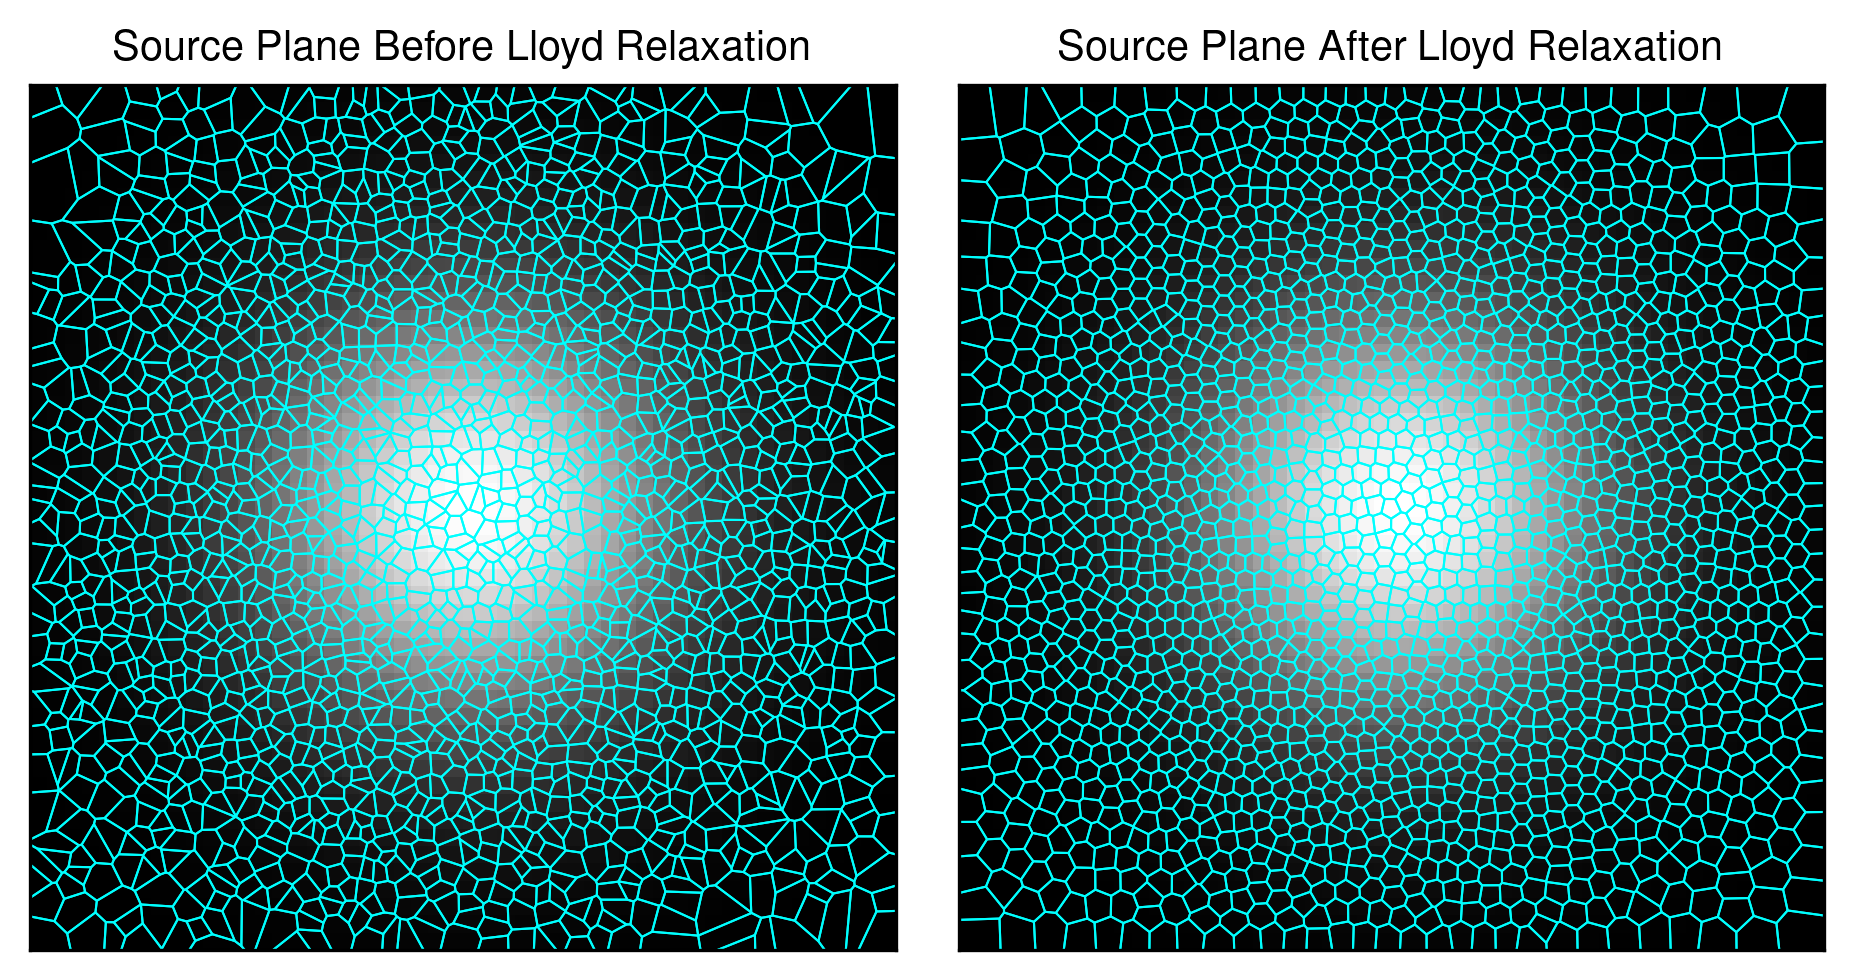

CPU times: user 10.1 s, sys: 4.39 s, total: 14.5 s
Wall time: 1min 3s


In [81]:
%%time
# Kasim et. al. recommends using 80% of the number of pixels for the number of sites
N = int(.8*w*h)
print(f'Deploying N = {N} sites onto the source plane.')

# Use the image intensities as the sampling weights for each pixel
weights = np.sqrt(source_image).flatten() / np.sum(np.sqrt(source_image))
idx = np.arange(len(weights))

# Randomly pick indices in the image *weighted by the source image*
rand_idx = np.random.choice(idx, N, replace = False, p = weights)

# Get the coordinates of each sampled point
points = np.array([X.flatten()[rand_idx], Y.flatten()[rand_idx]], dtype=float).T
# Add some noise to the site positions since integer coordinates can sometimes trip up the
# convex hull calculations
noise = np.random.rand(*points.shape) - 0.5
points += noise

# Deploy these sites on the source plane
source = voronoi.Voronoi(points, shape, image = source_image, clip = False)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.pcolormesh(X,Y, source_image, cmap='gray')
ax1.set_aspect('equal')
source.plot(ax=ax1, transparent=True,sites=False, lw = .5)
ax1.set_title("Source Plane Before Lloyd Relaxation")

# Perform Lloyd relaxation on the source plane
source.lloyd(threshold=.1)

ax2.pcolormesh(X,Y, source_image, cmap='gray')
ax2.set_aspect('equal')
source.plot(ax=ax2, transparent=True,sites=False, lw = .5)
ax2.set_title("Source Plane After Lloyd Relaxation")

plt.show()

## 4. Optimal Transport

The stage is finally set to start analyzing some data.

We want to find the weights of each of our Voronoi cells such that the intensity profile matches the target profile (our image data) using the site locations from the source profile (background image) such that the total distance traveled from source to target is minimized for all the cells. In other words, this is an optimal transport problem.

The weights we want can be found in the minimum of this function:
\begin{align}
f(\boldsymbol{w}) = - \sum_i \left[w_i S(V_i) + \int_{P_i^\boldsymbol{w}}(|\vec{r} - \vec{r}_{0i}|^2 - w_i) I(\vec{r}) d\vec{r}\right]
\end{align}

where $S(V_i)$ is the flux of the $i$th region on the source plane, and $P_i^w$ is the $i$th region on the target plane with weights $\boldsymbol{w}$, with associated flux $T(P_i^\boldsymbol{w})$ on the target plane. The gradient of this function is

\begin{align}
\frac{\partial f(\boldsymbol{w})}{\partial w_i} = T(P_i^\boldsymbol{w}) - S(V_i)
\end{align}

To minimize this process we can iterate through this process:
1. Calculate the weighted Voronoi diagram
2. Calculate $T(P^\boldsymbol{w}_i)$ for each cell
3. Calculate $f(\boldsymbol{w})$ and $\nabla_{\boldsymbol{w}}f(\boldsymbol{w})$
4. Set $\boldsymbol{w} \to \boldsymbol{w} - \alpha \nabla_{\boldsymbol{w}}f(\boldsymbol{w})$
5. Repeat until stopping conditions are satisfied.

Here $\alpha$ is the learning rate of the gradient descent algorithm. First thing's first, we need a way to calculate $f(\boldsymbol{w})$. To do this we need the weighted area, weighted center of mass, and moment of inertia of each cell in the power diagram. In order to do so, we need an efficient mechanism for determining which pixels in our image are fully enclosed by a polygon, and which pixels are overlapped by that polygon.

### Defining $f(\boldsymbol{w})$

Now we have the weighted areas ($S(V_i)$ and $T(P_i^{\boldsymbol{w}})$), centers of mass ($r_{0i}$ and $r_i$), and weighted moments of inertia ($\int_{P_i^\boldsymbol{w}} |r - r_{0i}|^2 I(r) dr$) of each cell, we can calculate the function $f(\boldsymbol{w})$ for each power diagram.

\begin{align}
f(\boldsymbol{w}) &= - \sum_i \left[w_i S(V_i) + \int_{P_i^\boldsymbol{w}}(|\vec{r} - \vec{r}_{0i}|^2 - w_i) I(\vec{r}) d\vec{r}\right]\\
&= - \sum_i \left[w_i [S(V_i) -T(P_i^\boldsymbol{w})] + \int_{P_i^\boldsymbol{w}}|\vec{r} - \vec{r}_{0i}|^2 I(\vec{r}) d\vec{r}\right]\\
&= \sum_i \left[w_i [ T(P_i^\boldsymbol{w})-S(V_i)] - I_{0i}\right]
\end{align}

This minimization function has the delightfully simple gradient
\begin{align}
\frac{\partial f(\boldsymbol{w})}{\partial w_i} = T(P_i^{\boldsymbol{w}}) - S(V_i)
\end{align}

So we can feed this function and its gradient into an established gradient-descent minimization algorithm from Scipy and let it minimize $f(\boldsymbol{w})$ for us.

In [82]:
%%time
from scipy.optimize import minimize
from datetime import datetime as dt

# get the sites from the source plane
sites = source.sites

# Initial guess of the weights
w0 = np.zeros(N)

# Put the source plane sites onto the target plane
target = voronoi.Voronoi(sites, shape, image = target_image, weights = w0, clip = False)

def f(weights, source, target):
    """ Returns the minimization function and its gradient"""
    S = source.A
    target.weights = weights
    
    T = target.A
    I = target.I
    c = target.c
    p = target.sites
    
    I_0 = I - T * np.sum(c**2, axis=1) + T * np.sum((p - c)**2, axis=1)
    
    f = np.sum(weights * (T - S) - I_0)
    grad = T - S

    #print(f'f = {f:.2e},  mean(grad) = {np.mean(T-S):.2e}')
    return f, grad

bounds = [(0,None) for site in sites]
max_iter = 100
result = minimize(f, w0, args=(source, target), 
                        jac = True, 
                        bounds = bounds,
                        method='L-BFGS-B',
                        options={'maxiter':max_iter}
                 )


if result.success:
    print(f'Minimization succeeded after {result.nit} iterations and {result.nfev} power diagrams')
else:
    print(f'Minimization failed after {result.nit} iterations and {result.nfev} power diagrams')
    print(result.message)
target.weights = result.x

Minimization succeeded after 20 iterations and 219 power diagrams
CPU times: user 1min 11s, sys: 34 s, total: 1min 45s
Wall time: 13min 7s


In [88]:
# Load the results from optimization into a new weighted Voronoi diagram
weights = result.x

res = voronoi.Voronoi(sites, shape, image=target_image, weights=weights)

Now that the weights have been optimized, we need to move the sites closest to each corner to the corners so that our displacement map covers the entire area of the image. Then we can interpolate the displacement for each pixel in the image.

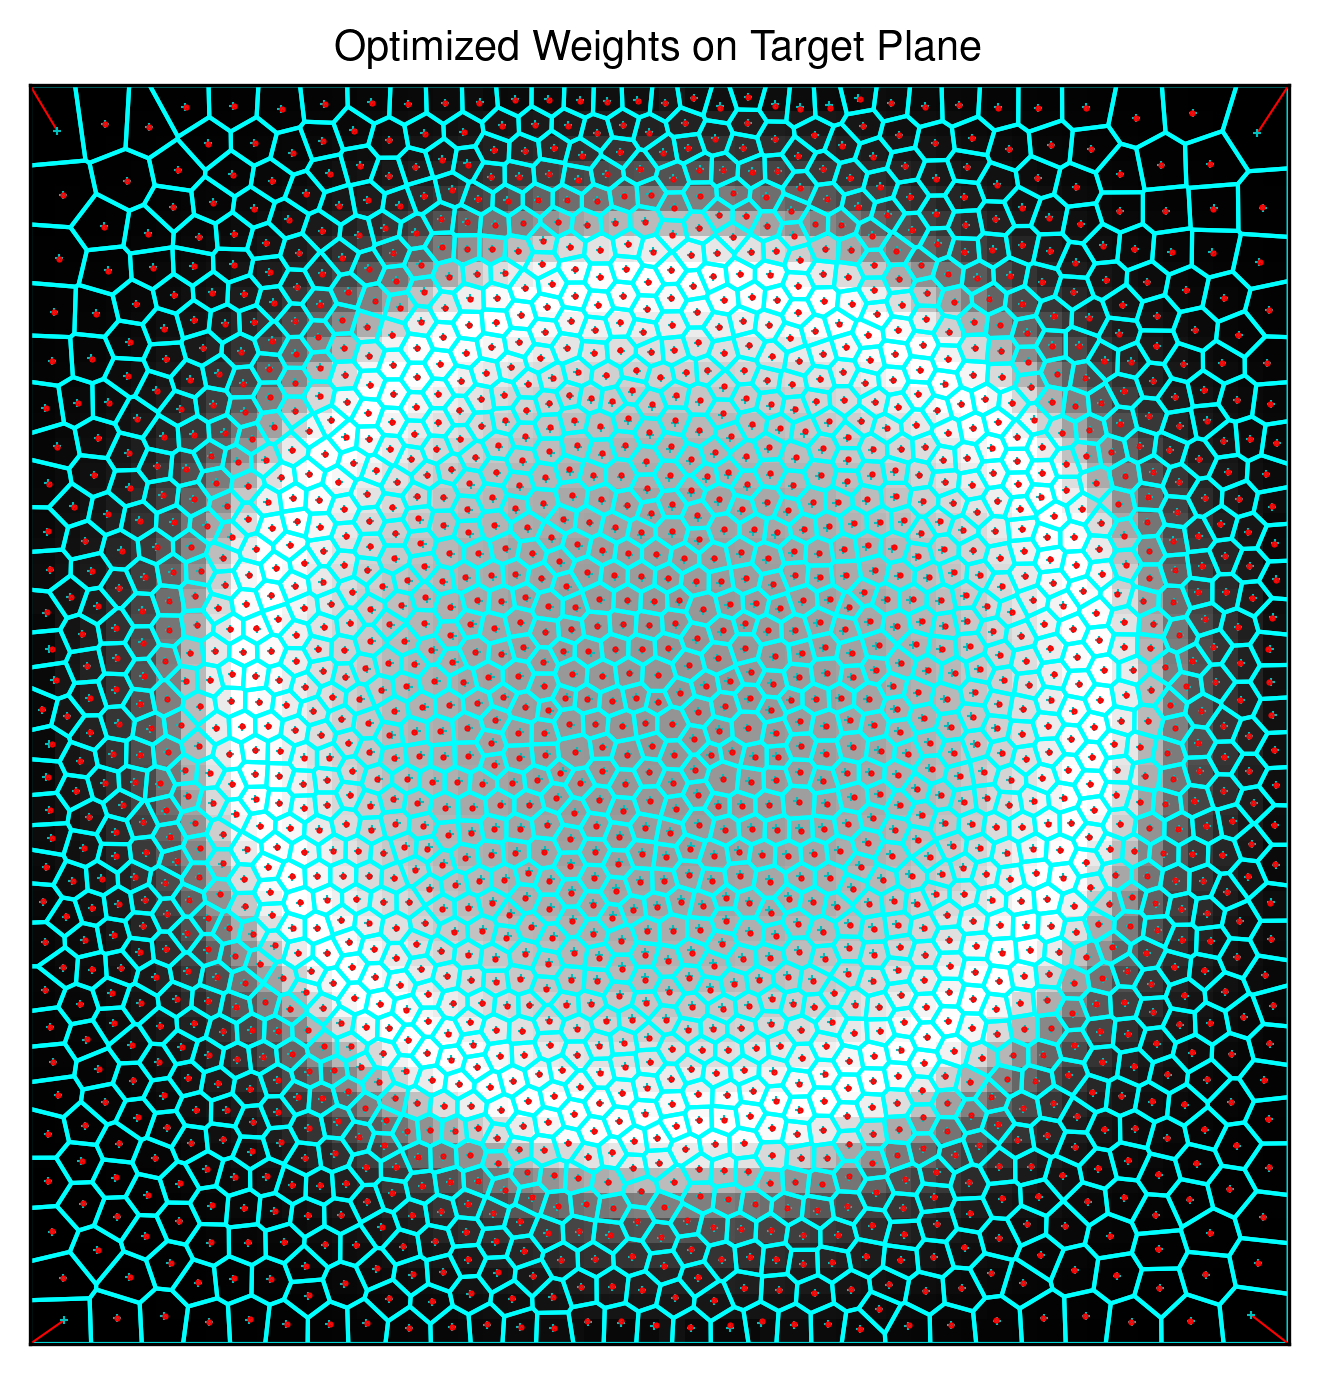

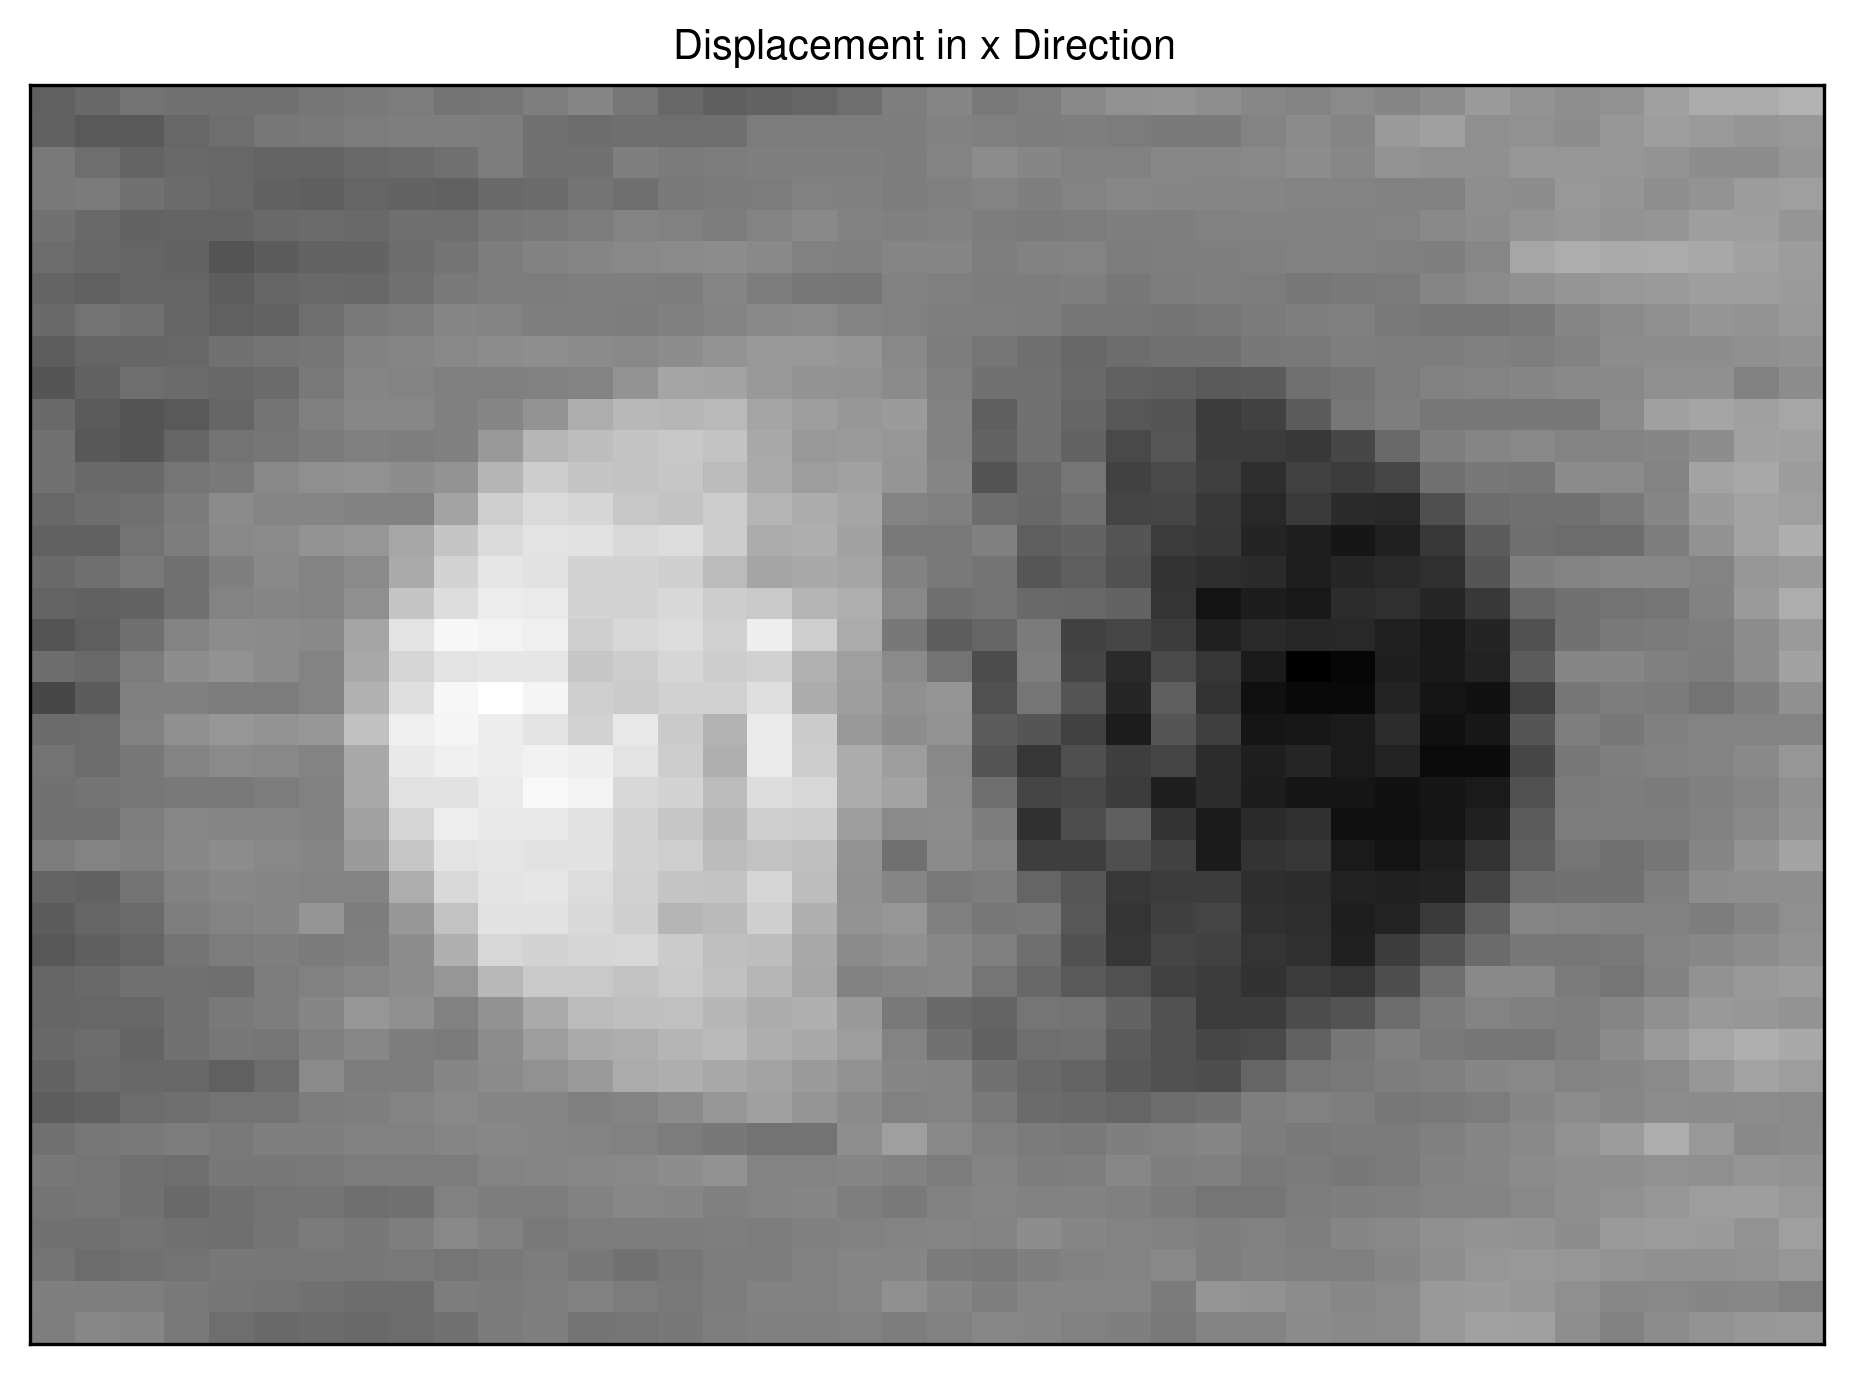

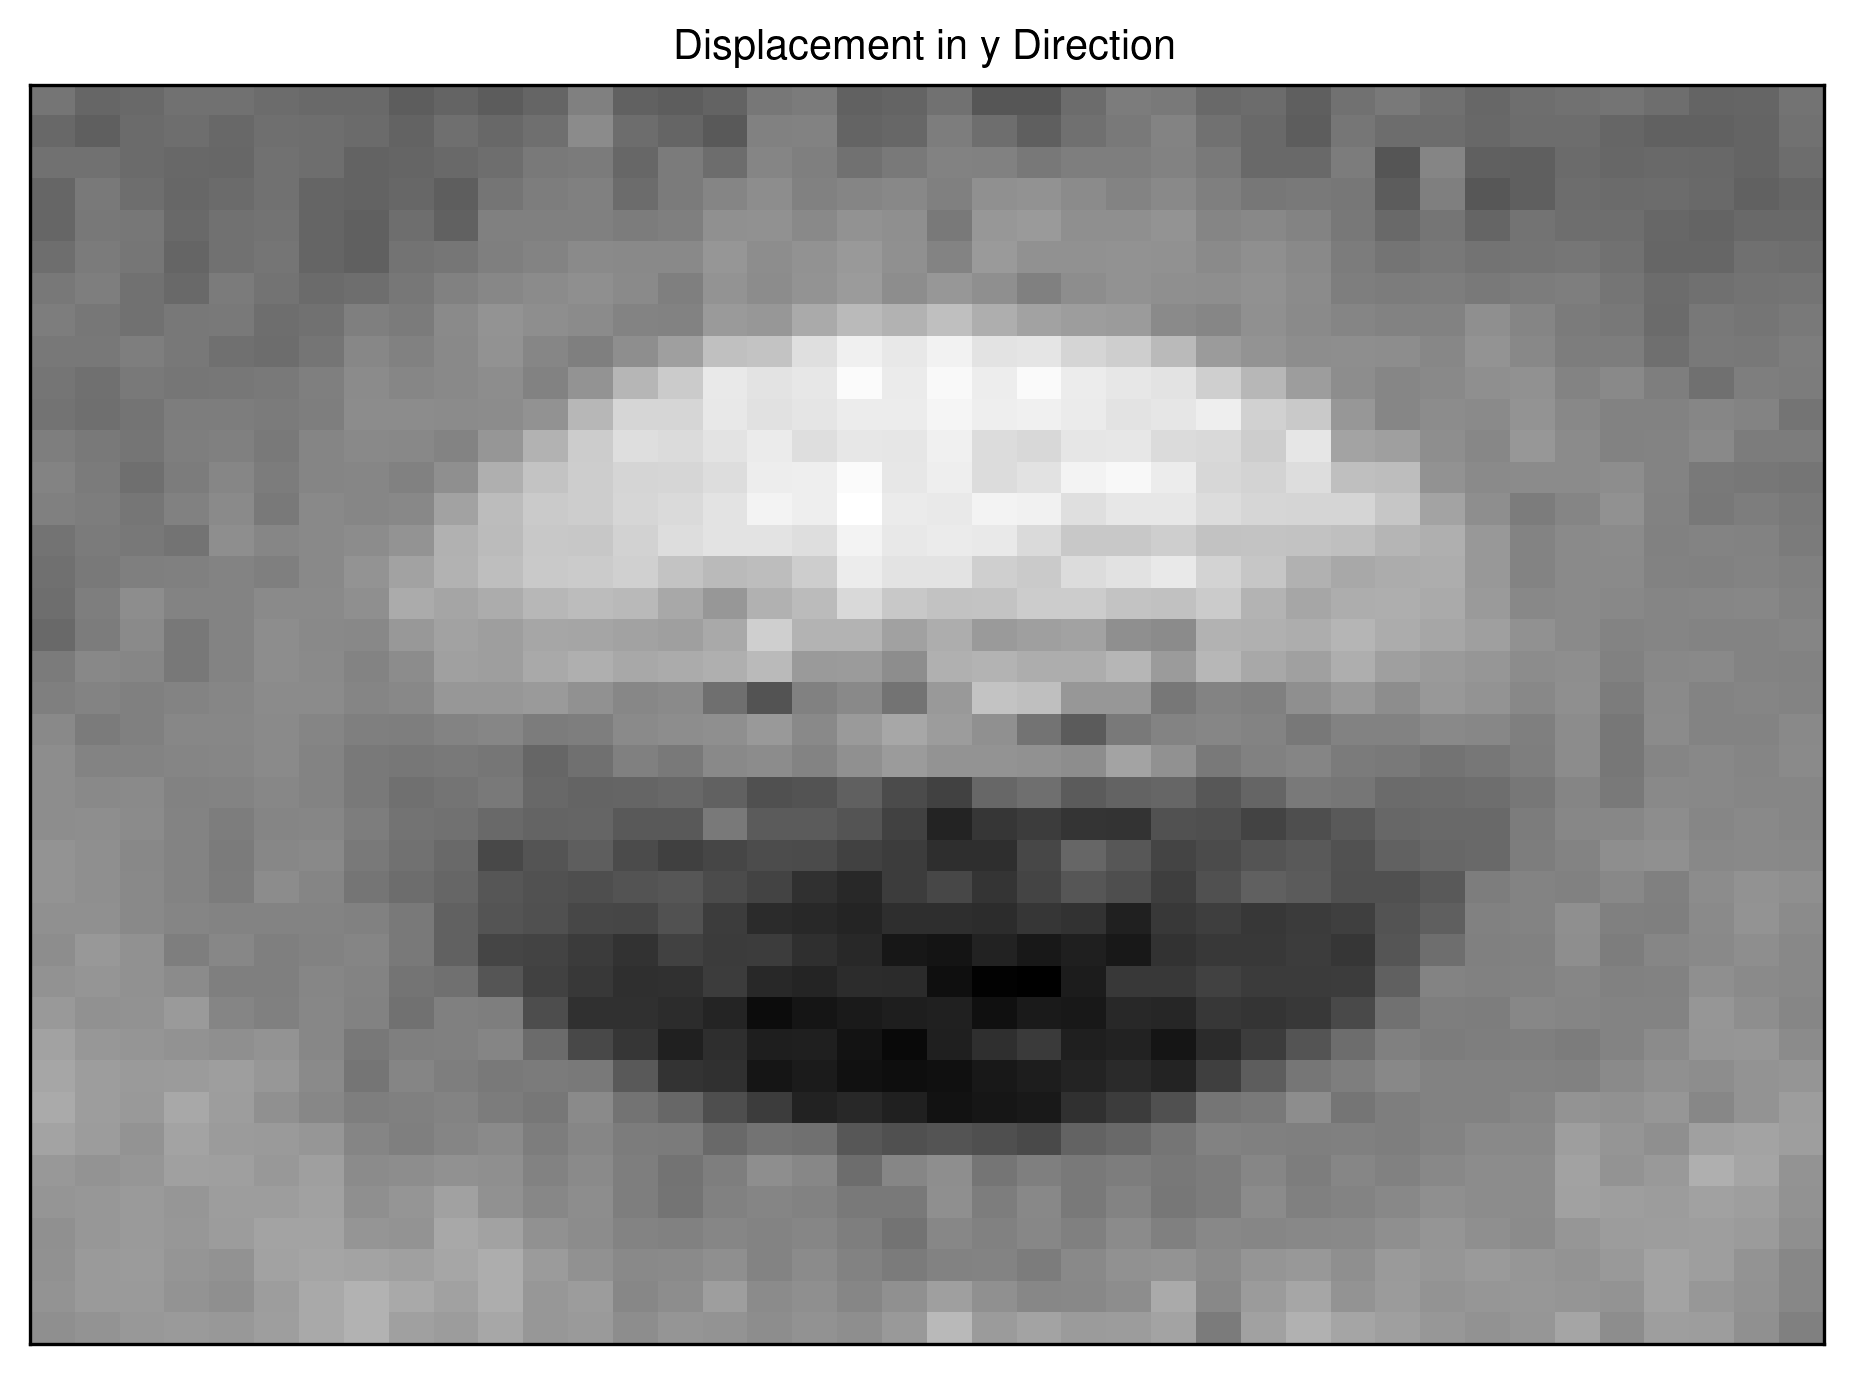

In [89]:
from scipy.spatial import distance
import natural_neighbor as nn
from scipy.interpolate import griddata

fig, ax = plt.subplots()
Y, X = np.indices((h, w))

ax.pcolormesh(X,Y, target_image, cmap='gray')
ax.set_aspect('equal')
freeze_ax()
res.plot(ax=ax, transparent=True, sites=False)
ax.set_xlim(-.5,w-.5)
ax.set_ylim(-.5,h-.5)
ax.set_title("Optimized Weights on Target Plane")

def corner_centroids(shape, centroids):
    h, w = shape
    corners = np.array([[0,0], [0,h],[w,h],[w,0]]) - 0.5
    for corner in corners:
        closest_index = distance.cdist([corner], centroids).argmin()

        centroids[closest_index] = corner
    return centroids

centroids = np.copy(res.c)
sites = np.copy(res.sites)

centroids = corner_centroids(shape, centroids)

points = np.stack((centroids, sites))
disp = np.diff(points, axis=0)[0]

disp_x = griddata(centroids,disp[:,0],(X, Y), method= 'cubic' )
disp_y = griddata(centroids,disp[:,1],(X, Y), method= 'cubic' )
#disp_x = nn.interpolate(centroids, disp[:,0], (h, w))
#disp_y = nn.interpolate(centroids, disp[:,1], (h, w))

for i, (site, centroid) in enumerate(zip(sites,centroids)):
    points = np.stack((site, centroid))
    ax.plot(points[:,0], points[:,1], 'r-', lw=.5)
ax.plot(sites[:,0], sites[:,1],'c+', mew=.5)
ax.plot(centroids[:,0], centroids[:,1], 'ro', ms=.5)

no_ticks()
plt.show()

fig, ax = plt.subplots()
no_ticks()
ax.set_title('Displacement in x Direction')
ax.imshow(disp_x[5:-5, 5:-5], cmap='gray')
plt.show()

fig, ax = plt.subplots()
ax.set_title('Displacement in y Direction')
no_ticks()
ax.imshow(disp_y[5:-5, 5:-5], cmap='gray')
plt.show()

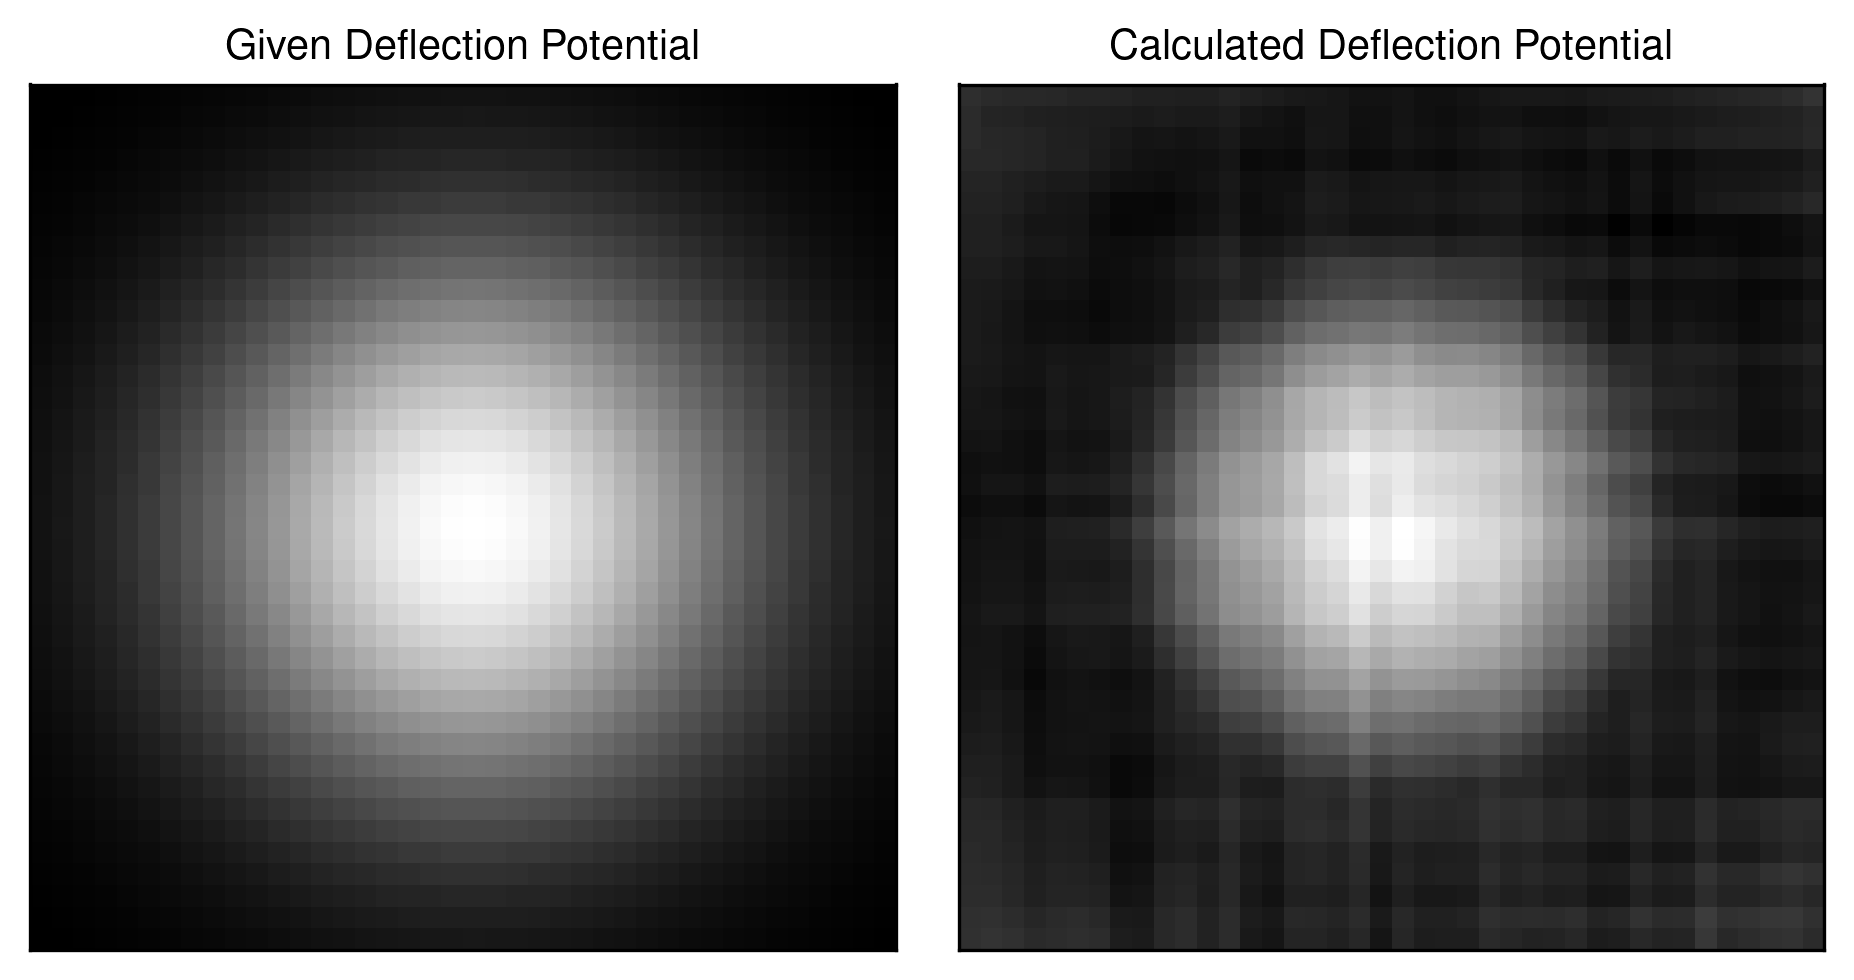

In [90]:
deflection_potential_x = np.cumsum(disp_x[5:-5, 5:-5], axis=1)
#deflection_potential_x = deflection_potential_x -(deflection_potential_x[h//2, :])[None,:]

deflection_potential_y = np.cumsum(disp_y[5:-5, 5:-5], axis=0)
#deflection_potential_y -= (deflection_potential_y[:, w//2])[:,None]

phi_x = (deflection_potential_x) #+ (deflection_potential_y[h//2, :])[None,:])
phi_y = (deflection_potential_y) #+ (deflection_potential_x[:, w//2])[:,None])
phi_c = (phi_x + phi_y)/2
# Set the minimum of the deflection potential to zero
phi_c -= np.min(phi_c)

fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True)
ax2.set_title('Calculated Deflection Potential')
ax2.imshow(phi_c, cmap='gray')

ax1.set_title('Given Deflection Potential')
phi_t = phi(X,Y)[5:-5, 5:-5]
ax1.imshow(phi_t, cmap='gray')

no_ticks(ax1)
no_ticks(ax2)
ax1.set_aspect('equal')
ax2.set_aspect('equal')
plt.show()

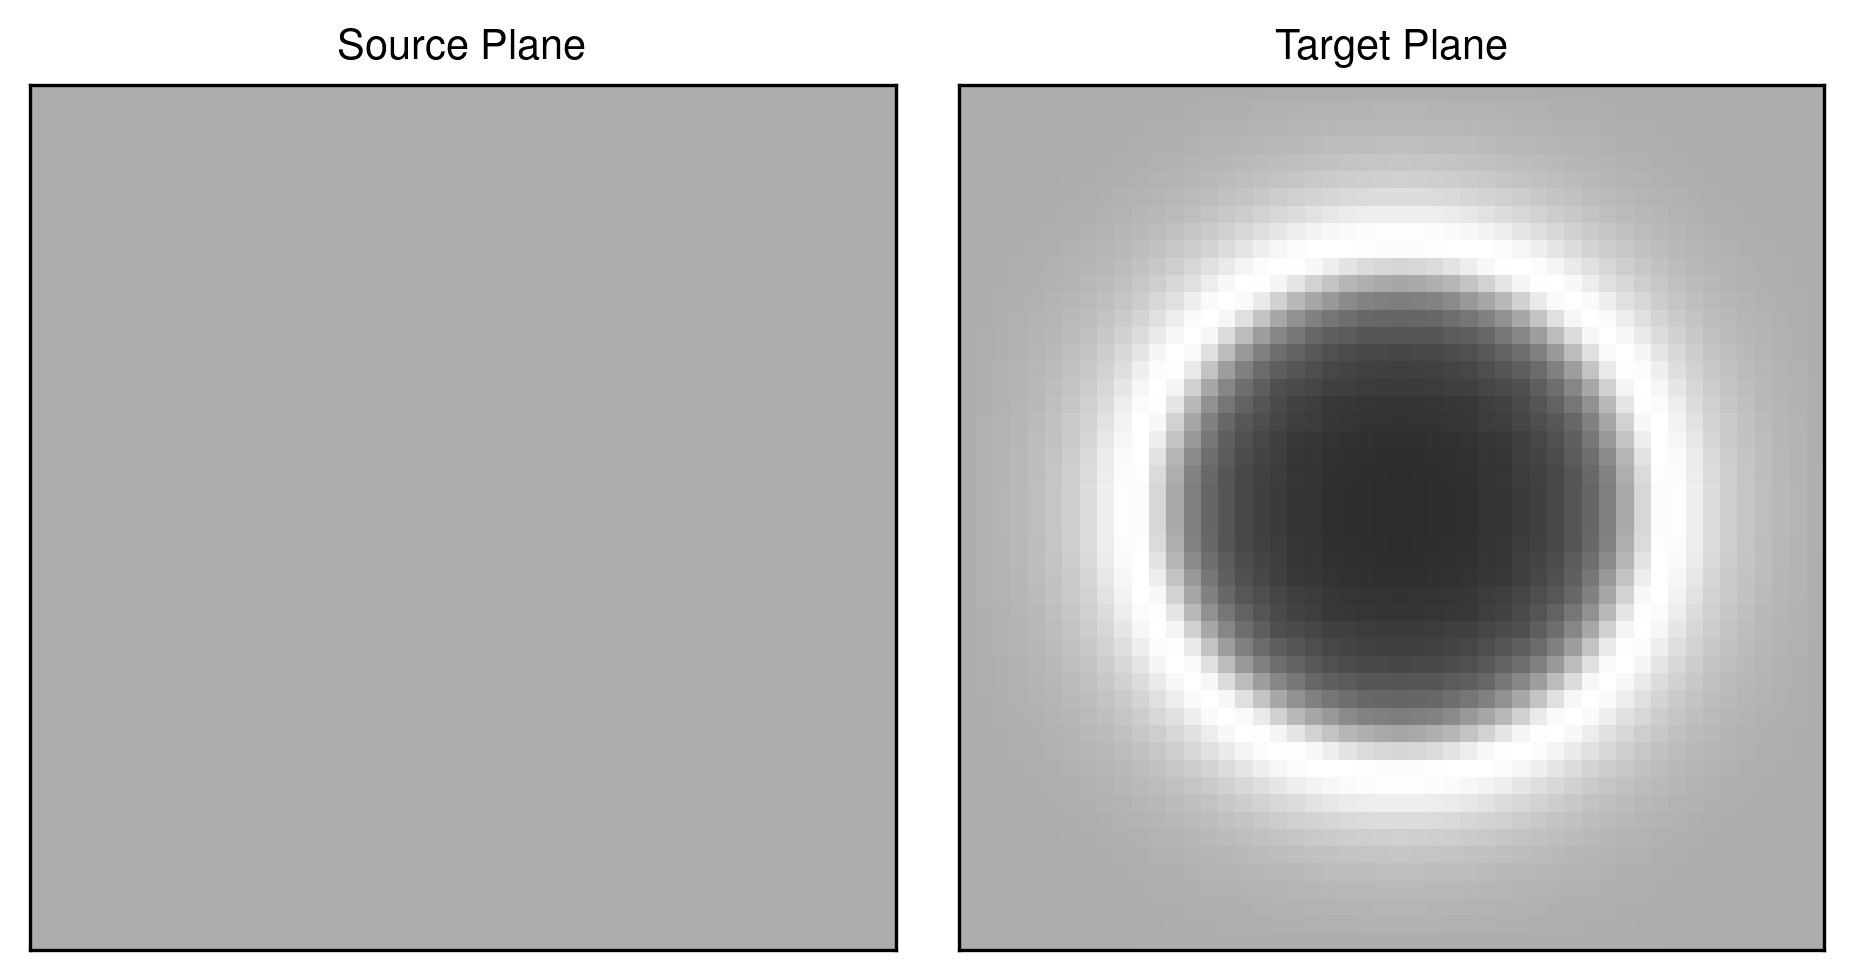

CPU times: user 946 ms, sys: 1.57 s, total: 2.52 s
Wall time: 2.05 s


In [39]:
%%time

h, w = 50,50
shape = (h,w)
L = 1 # distance between source and target planes in _pixels_

Y, X = np.indices(shape)

sigma = 0.2 * h # sigma of the gaussian
phi_0 = 50 # peak value of the deflection potential

# Define a gaussian function for the deflection potential
phi = lambda x, y: phi_0 * np.exp(-((x - w/2.)**2 + (y - h/2.)**2)/sigma**2)

# define the source plane image
source_image = np.ones(shape)#np.exp(-((X.astype(float) - w/2)**2 + (Y.astype(float) - h/2)**2)/(sigma**2))#np.ones((h,w))

source_image /= np.sum(source_image)

target_image = fw.forward_map(source_image, phi, L)

# Fix the funky row of pixels along the center row
target_image[h//2,:] = (target_image[h//2+1,:] + target_image[h//2-1,:])/2
target_image /= np.sum(target_image)

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.pcolormesh(X,Y, source_image, cmap='gray', vmax=target_image.max(), vmin = 0)
ax1.set_aspect('equal')
no_ticks(ax1)
ax1.set_title("Source Plane")

ax2.pcolormesh(X, Y, target_image, cmap='gray', vmax=target_image.max(), vmin = 0)
ax2.set_aspect('equal')
no_ticks(ax2)
ax2.set_title("Target Plane")
plt.show()

In [40]:
%%time
import optimal_transport as ot

N = 500
target, phi_c = ot.get_deflection_potential(target_image, source_image, N, lloyd_thresh = .05)

Deploying N = 500 sites on the source plane...
Performing Lloyd relaxation on the source plane...
All centroids within 5.0% after 19 iterations of Lloyd relaxation
Optimizing cell weights on the target plane (this will take a while)...
Minimization succeeded after 5 iterations and 28 power diagrams
Calculating the centroids of the optimized cells...
Moving nearest sites to the corners of the image...
Interpolating the displacements...
Calculating the deflection potential...
Finished
CPU times: user 9.19 s, sys: 4.86 s, total: 14 s
Wall time: 59.3 s


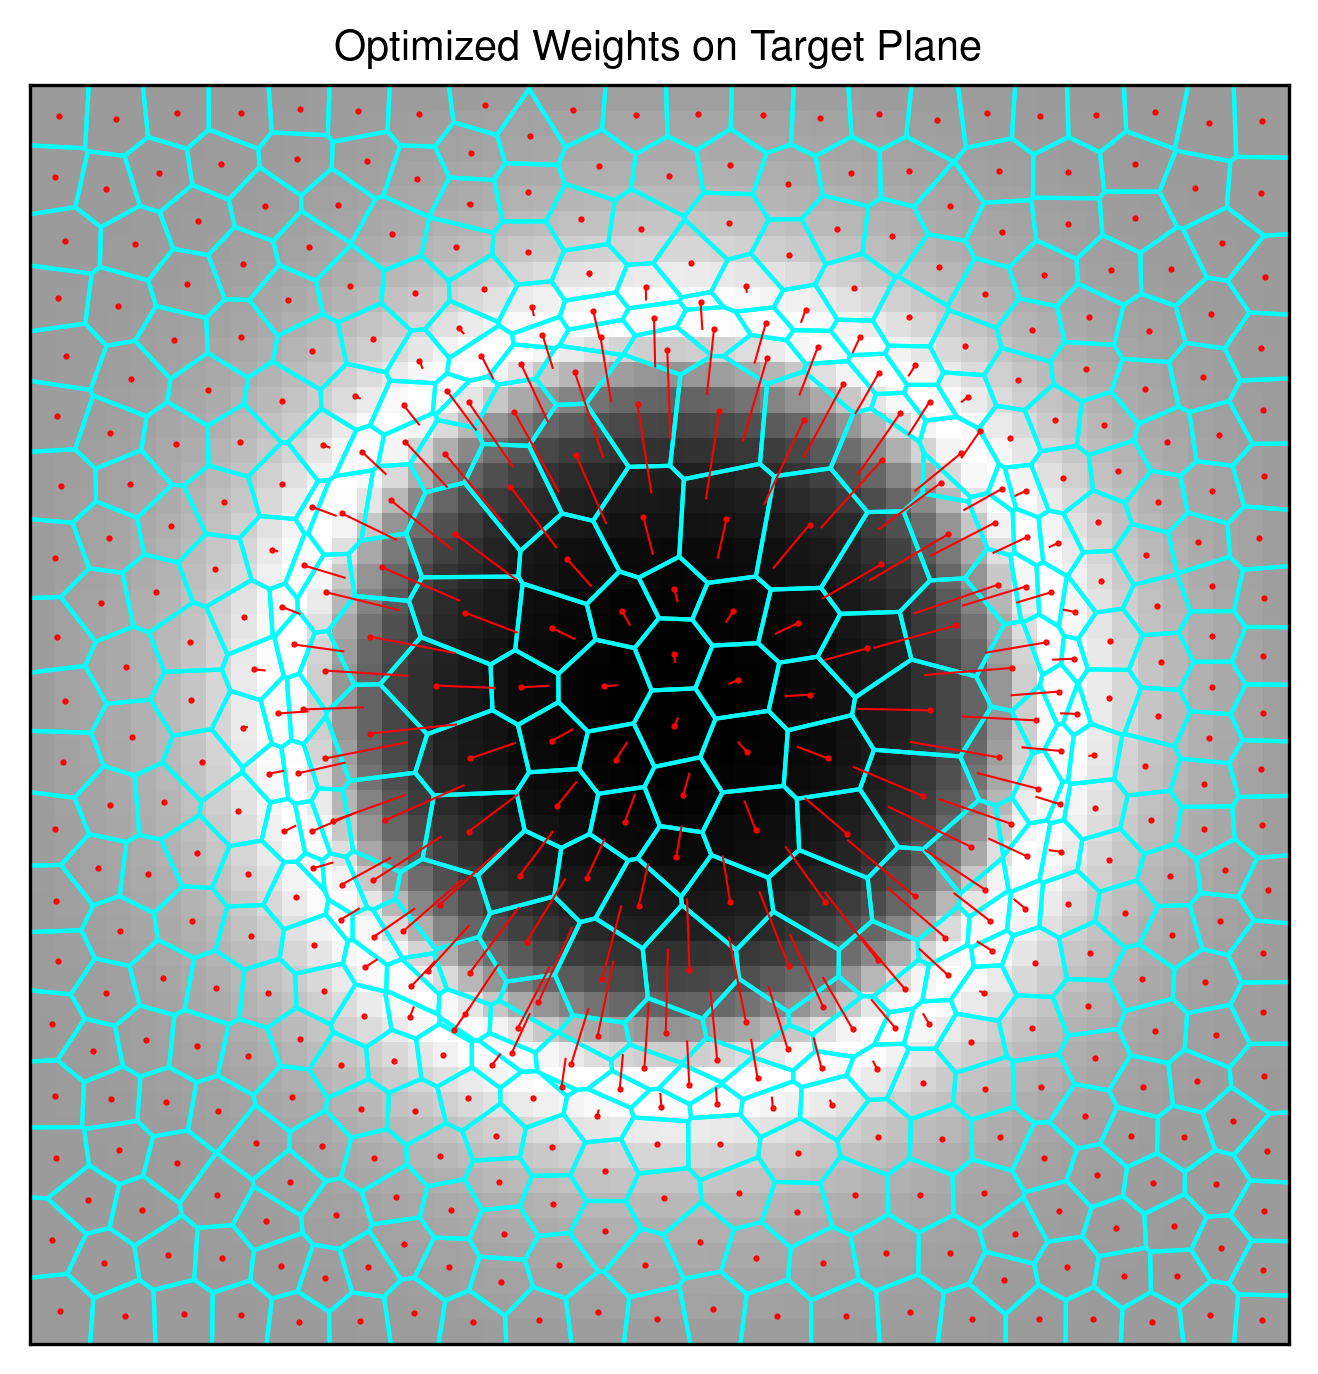

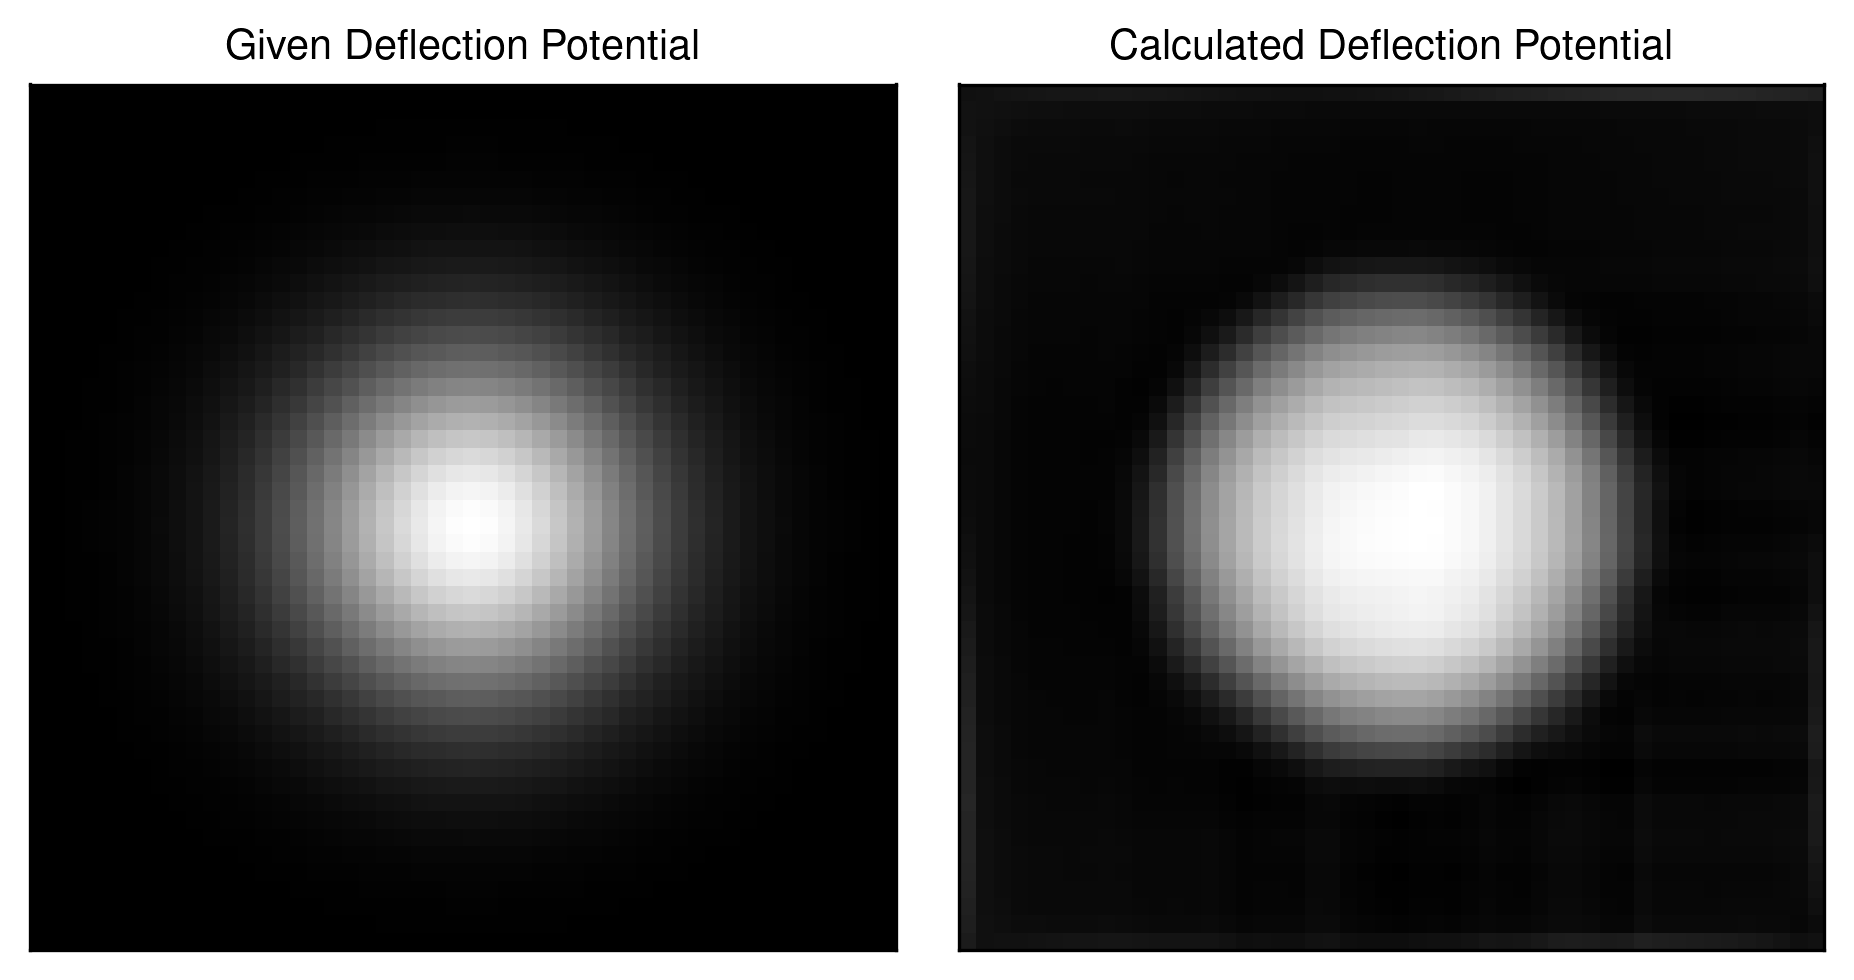

28.14341604508672
114.82790132472216%


In [41]:
from scipy.spatial import distance
import natural_neighbor as nn
from scipy.interpolate import griddata

fig, ax = plt.subplots()
Y, X = np.indices((h, w))

ax.pcolormesh(X,Y, target_image, cmap='gray')
ax.set_aspect('equal')
freeze_ax()
target.plot(ax=ax, transparent=True, sites=False)
ax.set_xlim(-.5,w-.5)
ax.set_ylim(-.5,h-.5)
ax.set_title("Optimized Weights on Target Plane")

def corner_centroids(shape, centroids):
    h, w = shape
    corners = np.array([[0,0], [0,h],[w,h],[w,0]]) - 0.5
    for corner in corners:
        closest_index = distance.cdist([corner], centroids).argmin()

        centroids[closest_index] = corner
    return centroids

centroids = np.copy(target.c)
valid = np.all(centroids != -1, axis=1)
centroids = centroids[valid]
sites = target.sites[valid]

for i, (site, centroid) in enumerate(zip(sites,centroids)):
    points = np.stack((site, centroid))
    ax.plot(points[:,0], points[:,1], 'r-', lw=.5)
#ax.plot(sites[:,0], sites[:,1],'c+', mew=.5)
ax.plot(centroids[:,0], centroids[:,1], 'ro', ms=.5)

no_ticks()
plt.show()

pad = 5

fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True)
ax2.set_title('Calculated Deflection Potential')
ax2.imshow(phi_c, cmap='gray', vmax = phi_c[pad:-pad, pad:-pad].max())

ax1.set_title('Given Deflection Potential')
phi_t = phi(X,Y)
ax1.imshow(phi_t, cmap='gray')

no_ticks(ax1)
no_ticks(ax2)
ax1.set_aspect('equal')
ax2.set_aspect('equal')
plt.show()

print(f'{phi_c[pad:-pad, pad:-pad].max()}')
error = abs(phi_t - phi_c) / phi_t
print(f'{np.mean(error[pad:-pad, pad:-pad]) * 100}%')

## Natural Neighbor Interpolation

Scipy's griddata function does not have an option for *natural* neighbor interpolation, so above cubic spline interpolation was used. Thankfully natural neighbor interpolation is based on the same geometric principles we've become all too familiar with: Delaunay triangulation and circumcircles.

Natural neighbor interpolation takes the form of the simple formula
\begin{align}
f(\vec{x})\approx \sum_{i=1}^n \lambda_i f(\vec{x}_i)
\end{align}

where $\vec{x}$ is the point at which we want an interpolated value of some function $f$, and $\vec{x}_i$ are the points at which we have true values of that function. The weights $\lambda_i$ of each known point can be found in several different ways, but we'll use a method outlined in [this delightfully thorough explanation by G.W. Lucas](https://gwlucastrig.github.io/TinfourDocs/NaturalNeighborTinfourAlgorithm/index.html).

**A triangle is a natural neighbor of a point if the circumcircle of that triangle containt the point.**

So step one is determining the triangles that are the natural neighbors of each point. Let's take a look at the Delaunay triangulation we have for this shadowgraphy problem:

In [ ]:
centroid_vor = voronoi.Voronoi(centroids, weights = weights, shape = (h, w))
centroid_vor.plot(plot_delaunay=True, plot_cells=False)
ax = plt.gca()

ax.set_title('Delaunay Triangulation')
plt.show()

Testing with this many points will be a pain, so let's make a more simple case while we develop this algorithm.

In [ ]:
h, w = 100,100
N = 10

X, Y = np.indices((h,w))

# Give each site a value that we want to interpolate
# In our real use case these values would be the displacement of each centroid in x or y
values = np.arange(N)

# Randomly pick N points
pts = np.random.rand(N, 2)
pts[:,0] *= w
pts[:,1] *= h

# Calculate the unweighted Voronoi
vor = voronoi.Voronoi(pts, (h,w))
vor.lloyd(threshold=.1)
pts = vor.sites

vor.plot(plot_delaunay=True)
ax=plt.gca()
ax.set_title('Voronoi Diagram and Delaunay Triangulation')

plt.show()

First let's get all the Delaunay triangles and their circumcircles and determine the triangles that are natural neighbors of a given interpolation point.

In [ ]:
# Define a test point to interpolate
point = np.array([30,50])

# Get all the Delaunay triangles
triangles = vor.sites[vor.triangles]

fig, ax = plt.subplots()
ax.set_xlim(0, w)
ax.set_ylim(0, h)
no_ticks()

triangles_in_envelope = []
triangles_outside_envelope = []

for triangle in triangles:
    tri = shapes.Triangle(triangle)
    if tri.inside_circle(point):
        # If the interpolating point is inside a triangle's circumcircle, then that triangle is a
        # natural neighbor of the point
        triangles_in_envelope.append(triangle)
        tri.plot(ax=ax, plot_circle=True, edgecolor='b', facecolor=(0,0,0,0),
                circle_options = {'edgecolor': 'r', 'facecolor':(1,0,0,.2)}, zorder = 3)
    else:
        triangles_outside_envelope.append(tri)
        tri.plot(ax=ax, plot_circle=True, edgecolor='k', facecolor=(0,0,0,0), 
                 circle_options = {'ls':':'})

# Show the interpolation point as a red X
ax.plot(point[0], point[1], 'r+', markersize = 10, zorder=3)
ax.set_title('Delaunay Triangles that are Natural Neighbors of the Interpolation Point')
plt.show()

Now that we have the natural neighbors, we need to remove those triangles from the original Delaunay triangulation to make room for the interpolation point. The outer edges of this hollowed out region define the **Bowyer-Watson envelope**.

Note that with those triangles removed, there are no circles that contain any points in the image, all points lie on the *edge* of the circles, because they are vertices of the triangles being circumscribed. By removing the triangles whose circumcircles contained the interpolation point, we can now redefine the Delaunay triangles *inside* the Bowyer-Watson envelope to include the interpolation point as a vertex and complete the Delaunay triangulation.

In [ ]:
num_triangles = len(triangles_in_envelope)

envelope_vertices = np.unique(np.array(triangles_in_envelope).reshape((3 * num_triangles, 2)), axis=0)
envelope_vertices = shapes.clockwise_sort(envelope_vertices)
envelope = shapes.Polygon(envelope_vertices)

fig, ax = plt.subplots()
ax.set_title('The Bowyer-Watson Envelope')
ax.set_xlim(0, w)
ax.set_ylim(0, h)
no_ticks()

# Plot the Bowyer-Watson envelope in red
envelope.plot(ax=ax, edgecolor='r', facecolor=(1,0,0,.2), zorder=3)

# Plot the rest of the Delaunay triangles
for tri in triangles_outside_envelope:
    tri.plot(ax=ax, plot_circle=True, circle_options = {'ls':':'})

ax.plot(point[0], point[1], 'r+', markersize = 10, zorder=3)

plt.show()

Now that we have the Bowyer-Watson (BW) envelope, we only need to worry about what's happening inside the envelope and can ignore the rest of the triangulation.

To complete the interpolation we now connect the interpolation point to each vertex of the envelope to complete a new Delaunay triangulation that contains the interpolation point as one of its sites.

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim(0, w)
ax.set_ylim(0, h)
no_ticks()
#Show the original voronoi diagram before inserting the point in cyan
vor.plot(ax, sites=False)

# Plot the Bowyer-Watson envelope in red
envelope.plot(ax=ax, edgecolor='r', zorder=3)

# Get the interpolation point's Voronoi cell using the circumcenters of the Delaunay triangles
# inside the BW envelope
cell_verts = []
for i, v2 in enumerate(envelope_vertices):
    v1 = envelope_vertices[i-1]
    v3 = point
    triangle = shapes.Triangle(np.stack((v1,v2,v3)))
    cell_verts.append(triangle.circumcenter)
    triangle.plot(ax=ax, plot_points=False, lw=0.5)

# Plot the rest of the Delaunay triangles outside the BW envelope
for tri in triangles_outside_envelope:
    tri.plot(ax=ax, lw=0.5)

# Plot the new Voronoi cell around the interpolated point in blue
cell = shapes.Polygon(np.array(cell_verts))
cell.plot(ax=ax, edgecolor='b', zorder=2)
ax.plot(point[0], point[1], 'r+', markersize = 10, zorder=3)
A = cell.A

# Show the area 'stolen' from each original Voronoi cell in the envelope 
# by filling in the intersection between the original cells and the new cell
colors = mpl.cm.get_cmap(name='rainbow')(np.linspace(0,1,vor.N))
colors[:,3] = 0.5

lambdas = np.zeros(N)
for i, (site, og_cell) in enumerate(zip(vor.sites, vor.regions)):
    if np.isin(site, envelope_vertices).all(0):
        # If the cell is inside the BW envelope, find the area in the original
        # Voronoi diagram that is replaced by the new cell surrounding the interpolation point
        stolen = shapes.Polygon(og_cell.vertices)
        stolen.clip_to(cell)
        if stolen.N != 0:
            stolen.plot(plot_points=False, facecolor = colors[i])
            # calculate that site's weight in the interpolation
            lambdas[i] = stolen.A / A

# Calculated the interpolated value at the given point
value = np.sum(lambdas * values)

ax.set_title('Inserting a New Voronoi Cell inside the BW Envelope')
plt.show()

Now that we have these "stolen" regions, we can calculate the weight of each site's contribution to the value of the interpolation point. Let's take a look at the value of each site and see if our calculated value makes sense:

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim(0, w)
ax.set_ylim(0, h)
no_ticks()
#Show the original voronoi diagram before inserting the point
vor.plot(ax)

# Plot the new Voronoi cell around the interpolated point in blue
cell.plot(ax=ax, edgecolor='b', zorder=2)
ax.plot(point[0], point[1], 'r+', markersize = 10, zorder=3)

# Show the area 'stolen' from each original Voronoi cell in the envelope 
# by filling in the intersection between the original cells and the new cell
colors = mpl.cm.get_cmap(name='rainbow')(np.linspace(0,1,N))
np.random.shuffle(colors)
colors[:,3] = 0.3

for i, (site, og_cell) in enumerate(zip(vor.sites, vor.regions)):
    ax.text(site[0]-1, site[1]+1, f'{values[i]}',
            c='k', size=8, ha = 'center')
    
ax.text(point[0], point[1]-5, f'{value:.2f}',
        c='r', size=8, ha = 'center')

ax.set_title('Interpolated Value using Natural Neighbor')
plt.show()

This looks reasonable, hurrah!

The method I've written up so far is easy to follow and makes some very pretty pictures, but when we have thousands of cells and tens of thousands of pixels to interpolate, it's much more efficient to take a purely mathematical approach to find the stolen areas once we have the BW envelope defined.

When we're interpolating on a grid, in particular, we can take advantage of the rasterization functions we've already written to streamline the process. Here's the plan:

1. Get the Delaunay triangulation of the final centroid positions
2. Get the circumcircle for each triangle
3. Use the rasterize functions to get a bolean map of pixels enclosed by each circumcircle
4. Determine the minimum set of Bowyer-Watson envelopes necessary to cover the entire space
5. For each of these envelopes calculate the areas of the included cells before inserting any new sites, since this will be the same for all the pixels corresponding to that envelope
6. For each pixel with a given envelope, calculate the new circumcenters if there were a site at that pixel, and use those as new vertices for each of the cells
7. Calculate the interpolated value at that pixel using the change in cell areas and move on.

A few things to note:
- We don't actually need the whole area of a cell to know the difference after inserting the new cell. *All the vertices outside the BW envelope will remain the same*, and since the Voronoi edges act as perpendicular bisectors of the Delaunay triangulation, we can use the midpoint of each Delaunay edge as vertices of the cell and ignore all the other vertices. However, our class for Voronoi tesselation is already calculating the cell areas as it goes, so there may not be an advantage to optimizing this much.
- For this interpolation process we want the **unweighted** Voronoi tesselation using the centroids as sites. We're done with the shadowgraphy image and the optimized weights now that we have these centroid positions, and it's pure geometry from here on in.

In [ ]:
%%time
'''
Perform 2D natural neighbor interpolation of scattered data with a given value at each site
onto a pixel grid of the given shape.
'''
h, w = 100,100
N = 500
shape = (h, w)

Y, X = np.indices(shape, dtype=float)
# Give each site a value that we want to interpolate
# In our real use case these values would be the displacement of each centroid in x or y
sigma = .25*h
gauss = lambda x, y: np.exp(-((x - w//2)**2 + (y - h//2)**2)/sigma**2)

source_image = 10 * gauss(X,Y)

# Use the image intensities as the weights for each pixel
weights = np.sqrt(source_image).flatten() / np.sum(np.sqrt(source_image))
# Randomly pick an index
idx = np.arange(len(weights))

rand_idx = np.random.choice(idx, N, replace = False, p = weights)

# Get the coordinates of each sampled point
points = np.array([X.flatten()[rand_idx], Y.flatten()[rand_idx]], dtype=float).T
noise = np.random.rand(*points.shape) - 0.5
points += noise
values = source_image.flatten()[rand_idx]

vor = voronoi.Voronoi(points, shape)
vor.lloyd(threshold=.1)

# Move some sites to the corners
pts = vor.sites

pts[0] = [0,0] 
pts[1] = [h,w]
pts[2] = [h,0]
pts[3] = [0,w]
pts[:4] -= 0.5

values[0] = source_image[0,0] 
values[1] = source_image[-1,-1]
values[2] = source_image[-1,0]
values[3] = source_image[0,-1]

vor = voronoi.Voronoi(pts, shape = (h,w))

# Grab the vertices of all the Delaunay triangles from the Voronoi object
indices = vor.triangles # indices of the sites defining each triangle
triangles = pts[indices]# (x,y) coordinates of the vertices of each triangle
centers = vor.circumcenters
radii = vor.radii

Y, X = np.indices(shape)
# Flatten grid into a list of coordinates
interp_points = np.stack((X.flatten(), Y.flatten())).T.astype(float)
interp_values = np.zeros(h*w)

in_circle = []

for i, triangle in enumerate(triangles):
    # Grab the circumcircle
    c = centers[i]
    r = radii[i]
    circle = mpl.path.Path.circle(center = c, radius = r)

    # Get a boolean map of all the pixels enclosed by the circumcircle
    enclosed = circle.contains_points(interp_points, radius= -.01)#.reshape(shape)
    in_circle.append(enclosed)

in_circle = np.array(in_circle).T # Now we have an array of format [point_idx, in_circle]
# Find all the unique combinations of triangles that are natural neighbors to the same points
unique_envelopes, npix = np.unique(in_circle, axis = 0, return_counts = True)
idxs = np.arange(triangles.shape[0])

for i, envelope in enumerate(unique_envelopes):
    if np.sum(envelope) == 0:
        print('no triangles')
        continue
    # find all the pixels corresponding to this envelope
    pixels = np.where((in_circle == envelope).all(1))[0]
    
    # get the indices of the triangles in the envelope
    envelope_triangles = idxs[envelope]

    # get the indices of the sites defining each triangle
    triangle_vertices = np.array(indices[envelope_triangles])

    # Define the Bowyer-Watson envelope
    envelope_vertices = np.unique(triangle_vertices)
    envelope_values = values[envelope_vertices]
    n_verts = envelope_vertices.shape[0]

    # get the coordinates of each vertex in the envelope
    vert_coords = shapes.clockwise_sort(pts[envelope_vertices])

    # get the midpoint of each edge
    midpoints = (vert_coords + np.roll(vert_coords, -1, axis=0)) / 2
    
    A_0 = np.zeros_like(envelope_vertices)
    # calculate the areas of the original voronoi cells inside the envelope
    for i, site in enumerate(envelope_vertices):
        # find the triangles that have the site as a vertex        
        tri_idx = np.argwhere(triangle_vertices == site)[:,0]
        # get the midpoints and circumcenters of the site's triangles
        c = centers[envelope_triangles[tri_idx]]
        m = [midpoints[i], midpoints[i-1]]
        verts = shapes.clockwise_sort(np.concatenate((m, c)))
        A_0[i] = shapes.area(verts)
    
    for pixel in pixels:
        point = interp_points[pixel]

        A_1 = np.zeros_like(envelope_vertices)        

        new_triangles = np.stack((vert_coords, np.roll(vert_coords, -1,axis=0), [point] * n_verts))
        new_triangles = new_triangles.transpose((1,0,2))

        new_centers = [shapes.circumcenter(verts) for verts in new_triangles]
        new_cells = np.stack((midpoints, 
                               new_centers, 
                               np.roll(new_centers, 1, axis=0), 
                               np.roll(midpoints, 1, axis=0))).transpose((1,0,2))
        A_1 = [shapes.area(verts) for verts in new_cells]
        weights = A_0 - A_1
        lambdas = weights / np.sum(weights)
        value = np.sum(lambdas * envelope_values)
        interp_values[pixel] = value

interp_values = interp_values.reshape((h,w))

In [ ]:
from scipy.interpolate import griddata

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
no_ticks(ax1)
no_ticks(ax2)
no_ticks(ax3)
no_ticks(ax4)
ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax3.set_aspect('equal')
ax4.set_aspect('equal')

ax1.set_title('Original Image')
ax1.pcolormesh(X,Y,source_image, cmap='gray', vmin=0, vmax=10)

ax2.set_title('Natural Neighbor Interpolation')
ax2.pcolormesh(X,Y, interp_values, cmap='gray', vmin=0, vmax=10)

ax3.set_title('Nearest Neighbor Interpolation')
nearest = griddata(pts, values, (X,Y), method = 'nearest')
ax3.pcolormesh(X,Y, nearest, cmap='gray', vmin=0, vmax=10)

ax4.set_title('Linear Interpolation')
linear = griddata(pts, values, (X,Y), method = 'linear')
ax4.pcolormesh(X,Y, linear, cmap='gray', vmin=0, vmax=10)
#for site, value in zip(pts, values):
#    ax.text(site[0]-1, site[1]+1, f'{value:.1f}',c='k', size=6, ha = 'center')
plt.show()

In [ ]:
arr = np.arange(12).reshape((2,3,2))
print(arr)
print(arr.transpose((1,0,2)))



In [ ]:
colors = mpl.cm.get_cmap(name='rainbow')(np.linspace(0,1,N))
np.random.shuffle(colors)
colors[:,3] = 0.3